# Emulators: First example

This example illustrates Bayesian inference on a time series, using [Adaptive Covariance MCMC](http://pints.readthedocs.io/en/latest/mcmc_samplers/adaptive_covariance_mcmc.html) with emulator neural networks .

It follows on from [Sampling: First example](../sampling/first-example.ipynb)

Like in the sampling example, I start by importing pints:

In [1]:
import pints

C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passi

Next, I create a model class using the "Logistic" toy model included in pints:

In [2]:
import pints.toy as toy
model = toy.LogisticModel()

In order to generate some test data, I choose an arbitrary set of "true" parameters:

In [3]:
true_parameters = [0.015, 500]

And a number of time points at which to sample the time series:

In [4]:
import numpy as np
times = np.linspace(0, 1000, 400)

Using these parameters and time points, I generate an example dataset:

In [5]:
org_values = model.simulate(true_parameters, times)

And make it more realistic by adding gaussian noise:

In [6]:
noise = 5
values = org_values + np.random.normal(0, noise, org_values.shape)

Using matplotlib, I look at the noisy time series I just simulated:

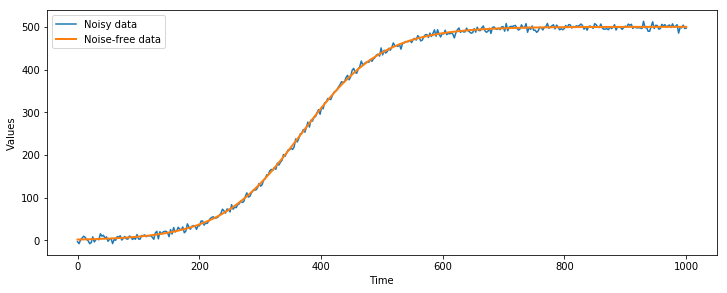

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4.5))
plt.xlabel('Time')
plt.ylabel('Values')
plt.plot(times, values, label='Noisy data')
plt.plot(times, org_values, lw=2, label='Noise-free data')
plt.legend()
plt.show()

Now, I have enough data (a model, a list of times, and a list of values) to formulate a PINTS problem:

In [8]:
problem = pints.SingleOutputProblem(model, times, values)

I now have some toy data, and a model that can be used for forward simulations. To make it into a probabilistic problem, a _noise model_ needs to be added. This can be done using the `GaussianLogLikelihood` function, which assumes independently distributed Gaussian noise over the data, and can calculate log-likelihoods:

In [9]:
#log_likelihood = pints.GaussianLogLikelihood(problem)
log_likelihood = pints.GaussianKnownSigmaLogLikelihood(problem, noise)

This `log_likelihood` represents the _conditional probability_ $p(y|\theta)$, given a set of parameters $\theta$ and a series of $y=$ `values`, it can calculate the probability of finding those values if the real parameters are $\theta$.

This can be used in a Bayesian inference scheme to find the quantity of interest:

$p(\theta|y) = \frac{p(\theta)p(y|\theta)}{p(y)} \propto p(\theta)p(y|\theta)$

To solve this, a _prior_ is defined, indicating an initial guess about what the parameters should be. 
Similarly as using a _log-likelihood_ (the natural logarithm of a likelihood), this is defined by using a _log-prior_. Hence, the above equation simplifies to:

$\log p(\theta|y) \propto \log p(\theta) + \log p(y|\theta)$

In this example, it is assumed that we don't know too much about the prior except lower and upper bounds for each variable: We assume the first model parameter is somewhere on the interval $[0.01, 0.02]$, the second model parameter on $[400, 600]$, and the standard deviation of the noise is somewhere on $[1, 100]$.

In [10]:
# Create bounds for our parameters and get prior
bounds = pints.RectangularBoundaries([0.01, 400], [0.02, 600])
log_prior = pints.UniformLogPrior(bounds)

With this prior, the numerator of Bayes' rule can be defined -- the unnormalised log posterior, $\log \left[ p(y|\theta) p(\theta) \right]$, which is the natural logarithm of the likelihood times the prior:

In [11]:
# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

Finally we create a list of guesses to use as initial positions. We'll run three MCMC chains so we create three initial positions:

In [12]:
xs = [
    np.array(true_parameters) * 0.9,
    np.array(true_parameters) * 1.05,
    np.array(true_parameters) * 1.15,
]

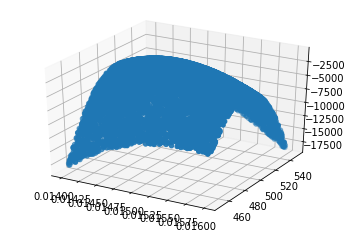

In [13]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 

# Create bounds for our parameters and get prior
bounds_nn = pints.RectangularBoundaries([0.014, 450], [0.016, 550])
log_prior_nn = pints.UniformLogPrior(bounds_nn)

input_parameters = log_prior_nn.sample(10000)
xs = [p[0] for p in input_parameters]
ys = [p[1] for p in input_parameters]
input_parameters[:5]

likelihoods = np.apply_along_axis(log_likelihood, 1, input_parameters)
likelihoods[:5]

#print(max(likelihoods))
#idx = list(likelihoods).index(max(likelihoods))
#print(input_parameters[idx])
#print(log_likelihood([0.015, 500]))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs, ys, list(likelihoods))
plt.show()

In [14]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(input_parameters, likelihoods, test_size=0.3, random_state=0)
emu = pints.MultiLayerNN(log_likelihood, X_train, y_train, input_scaler=MinMaxScaler(), output_scaler=StandardScaler())
emu.set_parameters(layers=6, neurons=64, hidden_activation='relu', activation='linear', learning_rate=0.0001)
hist = emu.fit(epochs=1000, batch_size=32, X_val=X_valid, y_val=y_valid, verbose=0)
#emu.summary()

In [15]:
emu([0.015, 500])

array([[-1219.2766]], dtype=float32)

In [16]:
log_likelihood([0.015, 500])

-1217.4515014644055

dict_keys(['val_loss', 'val_mean_absolute_error', 'loss', 'mean_absolute_error'])


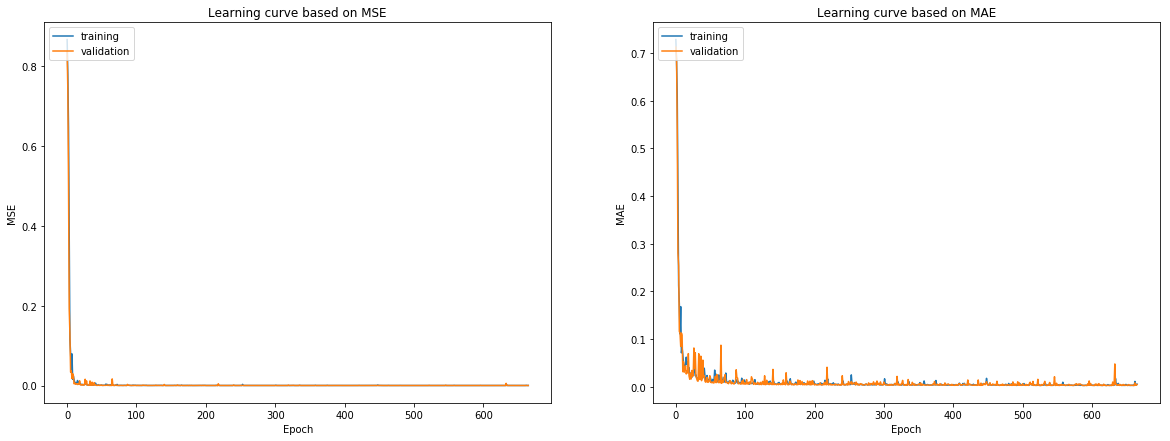

In [17]:
# summarize history for loss
print(hist.history.keys())
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))                 
ax1.title.set_text('Learning curve based on MSE')
ax2.title.set_text('Learning curve based on MAE')

ax1.plot(hist.history['loss'])
ax1.plot(hist.history['val_loss'])
ax1.set_ylabel('MSE')
ax1.set_xlabel('Epoch')
ax1.legend(['training', 'validation'], loc='upper left')

ax2.plot(hist.history['mean_absolute_error'])
ax2.plot(hist.history['val_mean_absolute_error'])
ax2.set_ylabel('MAE')
ax2.set_xlabel('Epoch')
ax2.legend(['training', 'validation'], loc='upper left')

plt.show()

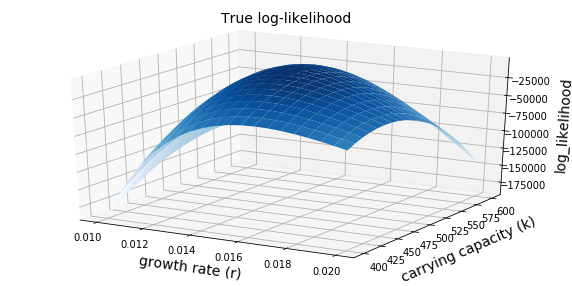

In [18]:
test_splits = 20 # number of splits along each axis
r_grid, k_grid, test_data = pints.generate_grid(bounds.lower(), bounds.upper(), test_splits)
model_prediction = pints.predict_grid(log_likelihood, test_data)

plt.figure(figsize = (10, 5))
ax = pints.plot.surface(r_grid, k_grid, model_prediction, title = "True log-likelihood",
                     x_label = "growth rate (r)",
                     y_label = "carrying capacity (k)")

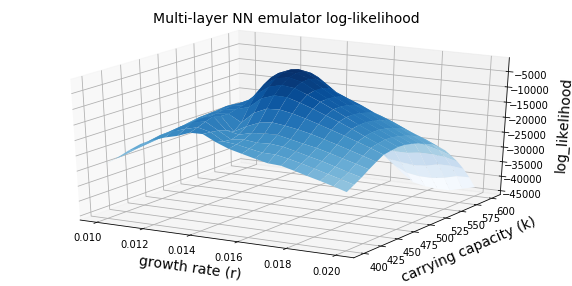

In [19]:
emu_prediction = pints.predict_grid(emu, test_data)

plt.figure(figsize = (10, 5))
ax = pints.plot.surface(r_grid, k_grid, emu_prediction, title = "Multi-layer NN emulator log-likelihood",
                        x_label = "growth rate (r)",
                        y_label = "carrying capacity (k)")

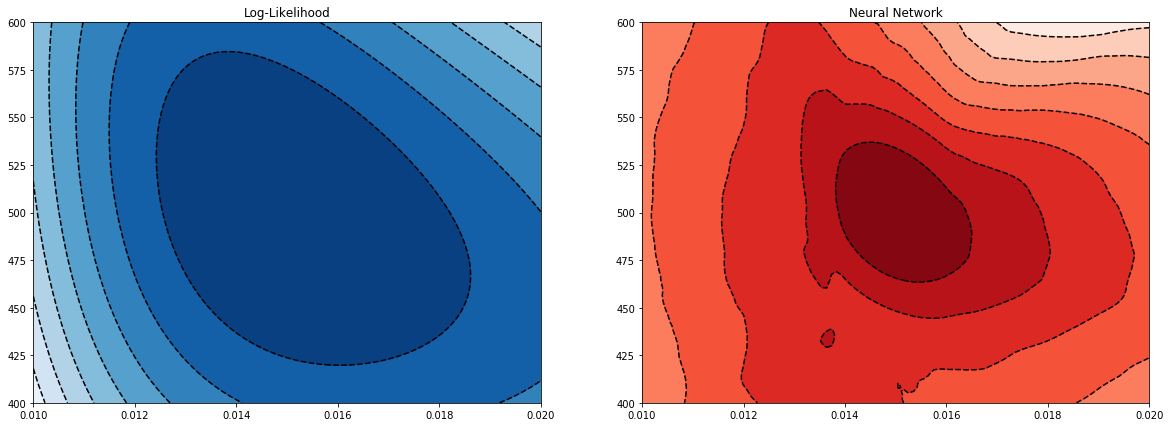

In [20]:
# Create grid
test_splits = 100 # number of splits along each axis
xx, yy, test_data = pints.generate_grid(bounds.lower(), bounds.upper(), test_splits)
xmin, xmax = np.min(xx), np.max(xx)
ymin, ymax = np.min(yy), np.max(yy)
params = [list(n) for n in zip(xx, yy)]
ll = np.apply_along_axis(log_likelihood, 1, params)
ll_emu = np.apply_along_axis(emu, 1, params)
ll_emu = [list(e[0][0]) for e in ll_emu]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
ax1.title.set_text('Log-Likelihood')
ax2.title.set_text('Neural Network')
ax1.contourf(xx, yy, ll, cmap='Blues', extent=[xmin, xmax, ymin, ymax])
ax1.contour(xx, yy, ll, colors='k')
ax2.contourf(xx, yy, ll_emu, cmap='Reds', extent=[xmin, xmax, ymin, ymax])
ax2.contour(xx, yy, ll_emu, colors='k')
plt.show()

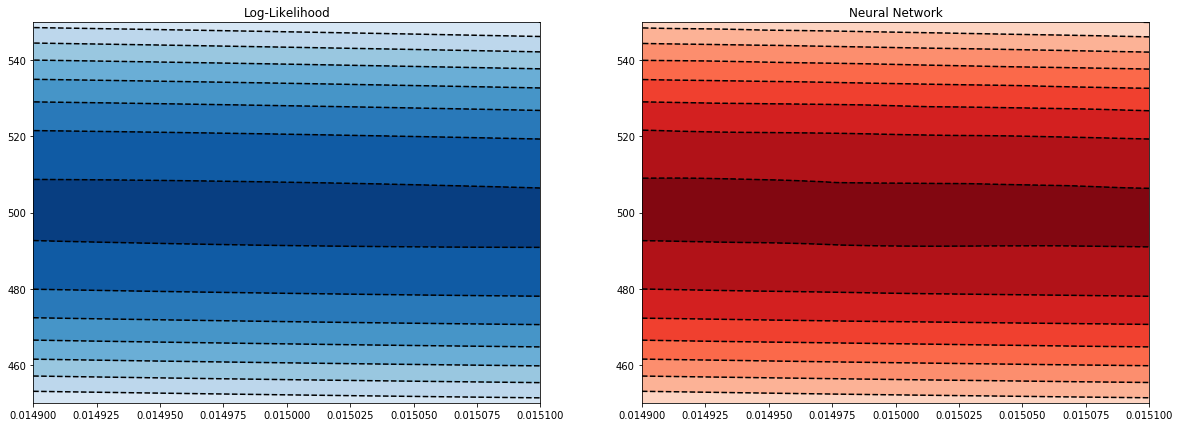

In [21]:
# Create grid
test_splits = 100 # number of splits along each axis
xx, yy, test_data = pints.generate_grid([0.0149, 450], [0.0151, 550], test_splits)
xmin, xmax = np.min(xx), np.max(xx)
ymin, ymax = np.min(yy), np.max(yy)
params = [list(n) for n in zip(xx, yy)]
ll = np.apply_along_axis(log_likelihood, 1, params)
ll_emu = np.apply_along_axis(emu, 1, params)
ll_emu = [list(e[0][0]) for e in ll_emu]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
ax1.title.set_text('Log-Likelihood')
ax2.title.set_text('Neural Network')
ax1.contourf(xx, yy, ll, cmap='Blues', extent=[xmin, xmax, ymin, ymax])
ax1.contour(xx, yy, ll, colors='k')
ax2.contourf(xx, yy, ll_emu, cmap='Reds', extent=[xmin, xmax, ymin, ymax])
ax2.contour(xx, yy, ll_emu, colors='k')
plt.show()

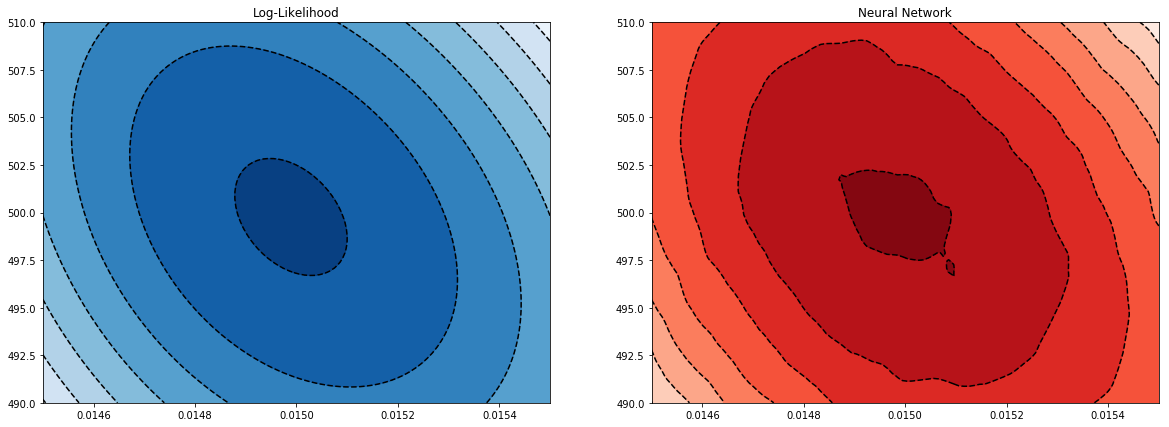

In [22]:
# Create grid
test_splits = 100 # number of splits along each axis
xx, yy, test_data = pints.generate_grid([0.0145, 490], [0.0155, 510], test_splits)
xmin, xmax = np.min(xx), np.max(xx)
ymin, ymax = np.min(yy), np.max(yy)
params = [list(n) for n in zip(xx, yy)]
ll = np.apply_along_axis(log_likelihood, 1, params)
ll_emu = np.apply_along_axis(emu, 1, params)
ll_emu = [list(e[0][0]) for e in ll_emu]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
ax1.title.set_text('Log-Likelihood')
ax2.title.set_text('Neural Network')
ax1.contourf(xx, yy, ll, cmap='Blues', extent=[xmin, xmax, ymin, ymax])
ax1.contour(xx, yy, ll, colors='k')
ax2.contourf(xx, yy, ll_emu, cmap='Reds', extent=[xmin, xmax, ymin, ymax])
ax2.contour(xx, yy, ll_emu, colors='k')
plt.show()

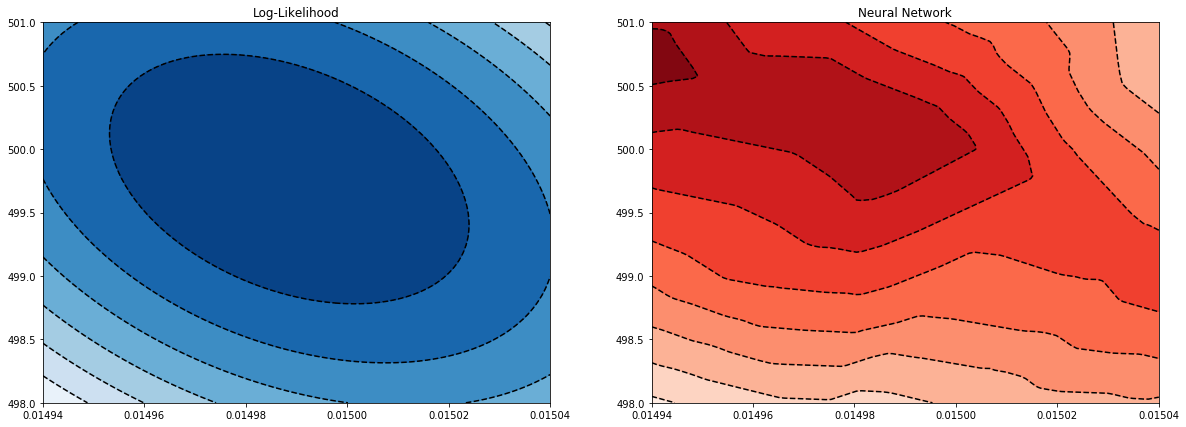

In [23]:
# Create grid
test_splits = 100 # number of splits along each axis
xx, yy, test_data = pints.generate_grid([0.01494, 498], [0.01504, 501], test_splits)
xmin, xmax = np.min(xx), np.max(xx)
ymin, ymax = np.min(yy), np.max(yy)
params = [list(n) for n in zip(xx, yy)]
ll = np.apply_along_axis(log_likelihood, 1, params)
ll_emu = np.apply_along_axis(emu, 1, params)
ll_emu = [list(e[0][0]) for e in ll_emu]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
ax1.title.set_text('Log-Likelihood')
ax2.title.set_text('Neural Network')
ax1.contourf(xx, yy, ll, cmap='Blues', extent=[xmin, xmax, ymin, ymax])
ax1.contour(xx, yy, ll, colors='k')
ax2.contourf(xx, yy, ll_emu, cmap='Reds', extent=[xmin, xmax, ymin, ymax])
ax2.contour(xx, yy, ll_emu, colors='k')
plt.show()

In [24]:
log_posterior_emu = pints.LogPosterior(emu, log_prior)
xs = [
    np.array(true_parameters) * 0.9,
    np.array(true_parameters) * 1.05,
    np.array(true_parameters) * 1.15,
]

Running...
[4.37304564e-02 4.51395772e+02]
-inf


[8.10201240e-03 5.25136625e+02]
-inf


[-5.72953539e-03  5.76676328e+02]
-inf


[1.79848173e-02 4.47827668e+02]
-21329.63310947356
accepted


[5.12565085e-03 5.27797524e+02]
-inf


[9.23146975e-03 5.73517714e+02]
-inf


[4.81289246e-03 4.47000448e+02]
-inf


[-9.93702708e-03  5.24161772e+02]
-inf


[-3.90469666e-03  5.76379837e+02]
-inf


[2.77930537e-02 4.49767388e+02]
-inf


[2.73129639e-02 5.26358443e+02]
-inf


[1.45378863e-02 5.78532116e+02]
-23352.3403697891
accepted


[2.43643981e-02 4.45968242e+02]
-inf


[8.54894230e-03 5.23892783e+02]
-inf


[-4.39465405e-03  5.81415334e+02]
-inf


[1.36766649e-02 4.49284071e+02]
-22314.67273430255


[5.26505460e-03 5.24854567e+02]
-inf


[1.26668248e-02 5.80038369e+02]
-30034.937060913067


[2.03496824e-02 4.50511944e+02]
-inf


[2.43864293e-02 5.22400351e+02]
-inf


[-2.97833906e-03  5.80219140e+02]
-inf


[1.12855698e-02 4.49249487e+02]
-85001.6810386705


[2.95097889e-02 5.25526295e+02]
-i

[1.53525376e-02 5.67842617e+02]
-22790.87749205535


[3.03444463e-02 4.47285423e+02]
-inf


[2.81605016e-02 5.22971594e+02]
-inf


[2.23572465e-02 5.70687947e+02]
-inf


[2.08415353e-02 4.46906815e+02]
-inf


[3.20763598e-03 5.28227976e+02]
-inf


[2.79479679e-03 5.72332524e+02]
-inf


[1.50674403e-02 4.49142098e+02]
-11465.140210607193


[1.55867243e-02 5.24524294e+02]
-6087.8554766438065
accepted


[7.94260464e-03 5.66079240e+02]
-inf


[2.04503938e-02 4.47928218e+02]
-inf


[7.54691158e-03 5.22431539e+02]
-inf


[1.42872901e-02 5.73483499e+02]
-19693.015532889676


[3.15143720e-02 4.46337271e+02]
-inf


[3.35509465e-02 5.24814803e+02]
-inf


[-1.58513620e-02  5.70606234e+02]
-inf


[3.21186431e-02 4.49064718e+02]
-inf


[2.34859466e-02 5.23473780e+02]
-inf


[2.19440251e-02 5.70666880e+02]
-inf


[2.88829412e-02 4.47038158e+02]
-inf


[3.72026722e-02 5.20737535e+02]
-inf


[-6.30864624e-03  5.75644213e+02]
-inf


[3.53639184e-02 4.48503730e+02]
-inf


[3.60443257e-02 5.27443449e+02]

[8.17518841e-03 5.23580424e+02]
-inf


[2.51148670e-02 5.68417675e+02]
-inf


[1.07054093e-02 4.47819389e+02]
-113108.3913985406


[3.05808085e-03 5.28932024e+02]
-inf


[2.70989056e-02 5.69184834e+02]
-inf


[1.95044460e-02 4.47454515e+02]
-35304.66593123746


[3.96363387e-02 5.31268627e+02]
-inf


[3.82446267e-02 5.70670852e+02]
-inf


[2.09965309e-02 4.49907562e+02]
-inf


[-2.04011066e-02  5.26377086e+02]
-inf


[1.05040238e-02 5.69783799e+02]
-90337.94261224665


[2.02796267e-02 4.49343468e+02]
-inf


[2.63897573e-02 5.30417673e+02]
-inf


[-4.66591326e-03  5.67296570e+02]
-inf


[2.55532573e-02 4.43195287e+02]
-inf


[2.44507165e-02 5.25284852e+02]
-inf


[2.25238522e-02 5.67780319e+02]
-inf


[1.68699312e-02 4.49405256e+02]
-13687.854654169529


[2.81744392e-02 5.27539911e+02]
-inf


[-2.76204469e-03  5.67729410e+02]
-inf


[2.43635190e-02 4.48699412e+02]
-inf


[2.62649943e-02 5.28878375e+02]
-inf


[1.82730858e-02 5.69167306e+02]
-67911.26273652932


[1.82404925e-03 4.51272918

-11091.158834173004


[1.48020407e-02 5.25108371e+02]
-3520.877969574268


[1.48886879e-02 5.62618902e+02]
-16613.738480372118


[1.56124475e-02 4.48075987e+02]
-10981.125274478944
accepted


[1.47368948e-02 5.25146183e+02]
-3475.3271824329586


[1.41748787e-02 5.62329774e+02]
-14398.42777181211
accepted


[1.57538675e-02 4.48068540e+02]
-10994.483070138866


[1.43960691e-02 5.25170455e+02]
-3690.04224380336


[1.43151794e-02 5.62377385e+02]
-14525.665942788204


[1.56064489e-02 4.48071463e+02]
-10984.594095915287


[1.39990060e-02 5.25166566e+02]
-5047.568380553943


[1.39514118e-02 5.62555518e+02]
-14647.430058258466


[1.55963422e-02 4.48054267e+02]
-10994.5688402379


[1.46311422e-02 5.25124485e+02]
-3448.2077291109317
accepted


[1.40720694e-02 5.61975442e+02]
-14279.03246229924
accepted


[1.54161982e-02 4.48050197e+02]
-11142.183619729409


[1.46083404e-02 5.25108190e+02]
-3450.7083139058786


[1.4314609e-02 5.6237703e+02]
-14524.762549968727


[1.56403864e-02 4.48101289e+02]
-1

[1.41658252e-02 5.24888088e+02]
-4287.437112010729
accepted


[1.60206364e-02 4.50269841e+02]
-10496.490569795915


[1.46398713e-02 5.20728795e+02]
-2763.2949534266263


[1.39652404e-02 5.22583741e+02]
-4961.461938986744


[1.61888208e-02 4.51304884e+02]
-10518.473476360892


[1.46195092e-02 5.22588423e+02]
-3042.0130531150717


[1.37670843e-02 5.39067398e+02]
-8455.016885377847


[1.60466386e-02 4.50409129e+02]
-10496.859068254063


[1.46186608e-02 5.21517571e+02]
-2885.3058888079468


[1.40818224e-02 5.30526343e+02]
-5420.0593198257575


[1.58561866e-02 4.49248881e+02]
-10629.100926407624


[1.46895415e-02 5.18806026e+02]
-2487.6069086523926
accepted


[1.40941766e-02 5.17016568e+02]
-3860.3894247152575
accepted


[1.59678446e-02 4.50037419e+02]
-10489.366087873897


[1.46852475e-02 5.19828823e+02]
-2623.159076908749


[1.43858389e-02 5.11551657e+02]
-2394.523478589236
accepted


[1.59706033e-02 4.50015980e+02]
-10501.029643415506


[1.46269487e-02 5.21936824e+02]
-2941.551190819244


[1.53538464e-02 4.52889223e+02]
-9378.177337919306


[1.50212412e-02 4.99283460e+02]
-1220.2695987142445


[1.52739691e-02 4.97412877e+02]
-1432.901133884354


[1.50778774e-02 4.54826340e+02]
-9228.678255196925
accepted


[1.50271929e-02 4.99015357e+02]
-1221.8462698201772
accepted


[1.51405956e-02 4.94106719e+02]
-1348.9464749587125


[1.47877802e-02 4.56129951e+02]
-9786.67895804731


[1.49898144e-02 5.01478873e+02]
-1229.456931772104


[1.50121385e-02 5.01882990e+02]
-1241.4976632466073


[1.55037887e-02 4.51454895e+02]
-9757.673616463435


[1.49986810e-02 5.00752682e+02]
-1222.423547183199
accepted


[1.51257733e-02 5.00009529e+02]
-1278.671028127204


[1.53279568e-02 4.53684294e+02]
-9126.74957931571
accepted


[1.49422247e-02 5.04102466e+02]
-1283.9133813841274


[1.53261989e-02 4.98180293e+02]
-1529.2425933677446


[1.54184503e-02 4.52458039e+02]
-9460.5803201857


[1.50242371e-02 4.99170804e+02]
-1220.9512994719323
accepted


[1.50431174e-02 5.02473368e+02]
-1268.854391139585


[1.54382100e-02 4.77722711e+02]
-3029.19899161134


[1.49879341e-02 5.00776937e+02]
-1221.4148054239683


[1.49766245e-02 5.00936840e+02]
-1222.1735315074993


[1.49242395e-02 4.81836800e+02]
-2633.7800362284715


[1.49922383e-02 5.00013111e+02]
-1217.6524906825077
accepted


[1.49674103e-02 4.99815266e+02]
-1218.6001808967405
accepted


[1.45639863e-02 5.22622329e+02]
-3083.925460802542


[1.49718669e-02 5.01302890e+02]
-1225.6750920864117


[1.49285636e-02 4.99572386e+02]
-1229.7254570209873


[1.47613211e-02 4.93229514e+02]
-1677.2050534841198


[1.49935508e-02 5.00086246e+02]
-1217.916741454305
accepted


[1.49238419e-02 5.00285129e+02]
-1228.8107028277045


[1.49772676e-02 4.89073375e+02]
-1693.7500920449463


[1.50209811e-02 4.98385732e+02]
-1224.6243540264602


[1.49248659e-02 4.99856192e+02]
-1229.6251721861925


[1.49212744e-02 4.86425726e+02]
-2029.3017170220871


[1.49818707e-02 5.00709873e+02]
-1220.544110101127


[1.49833364e-02 4.99374333e+02]
-1218.1468712715932
accepted

[1.50935180e-02 4.96509076e+02]
-1266.6150216151684


[1.49937474e-02 4.99334556e+02]
-1217.9289680424583
accepted


[1.50006708e-02 4.99486037e+02]
-1217.7766056824457
accepted


[1.51240424e-02 5.02176067e+02]
-1325.199786504067


[1.50083255e-02 4.99363989e+02]
-1218.5041117603216


[1.50006867e-02 4.99845046e+02]
-1217.8520321959722
accepted


[1.50869135e-02 4.95500595e+02]
-1287.0890078350305


[1.50141098e-02 4.98323577e+02]
-1224.7423555579326


[1.50397280e-02 4.99259581e+02]
-1224.3698522513273


[1.47917194e-02 5.09448700e+02]
-1561.8118328139574


[1.49892992e-02 4.99990816e+02]
-1217.5053987869203
accepted


[1.50017590e-02 4.99868711e+02]
-1217.9886148831904


[1.48393539e-02 5.02021663e+02]
-1280.9914295055485


[1.49763235e-02 5.00894952e+02]
-1221.8162071065292


[1.50051938e-02 5.00508832e+02]
-1221.4446321107405


[1.49324967e-02 4.98768697e+02]
-1235.8143959314664


[1.49891339e-02 5.00327930e+02]
-1218.6062464112704


[1.49970157e-02 4.99847871e+02]
-1217.593280553

-1231.4879413948413


[1.50063335e-02 4.98900590e+02]
-1220.038911350109
accepted


[1.49544346e-02 4.99217523e+02]
-1223.6894070178919


[1.49949589e-02 4.97239106e+02]
-1242.0538654224624


[1.50180812e-02 4.97677369e+02]
-1232.6780860447543


[1.49677043e-02 4.99417723e+02]
-1219.7233086312006


[1.49703295e-02 5.00527838e+02]
-1219.5461331005506
accepted


[1.50116534e-02 4.98675460e+02]
-1221.702887552333


[1.49837684e-02 5.00100060e+02]
-1217.6780950290233
accepted


[1.49482527e-02 5.02668082e+02]
-1247.0083624658923


[1.49793784e-02 4.99706182e+02]
-1217.5974736839717
accepted


[1.49760965e-02 4.99761756e+02]
-1217.7649636195335
accepted


[1.49744601e-02 4.98149977e+02]
-1230.381976713302


[1.49939820e-02 4.98952358e+02]
-1219.688383488019


[1.49693016e-02 4.99574225e+02]
-1218.8865034625962


[1.49677382e-02 4.99999919e+02]
-1218.457378298956
accepted


[1.49760482e-02 4.99743701e+02]
-1217.7889817917428
accepted


[1.49737095e-02 4.99795293e+02]
-1217.9327357521686
acce

[1.49798322e-02 4.98864422e+02]
-1221.4554088203745


[1.49347179e-02 5.01533215e+02]
-1231.2640674507138


[1.49882125e-02 4.99923016e+02]
-1217.378180444695
accepted


[1.49806893e-02 4.99290331e+02]
-1218.6898137110018
accepted


[1.49998948e-02 4.99504428e+02]
-1217.7142578546463
accepted


[1.49805446e-02 5.00026928e+02]
-1217.5866528099893


[1.49773150e-02 4.99532133e+02]
-1218.1053397277528
accepted


[1.49830344e-02 4.99745079e+02]
-1217.3824756135004
accepted


[1.50106374e-02 4.99970095e+02]
-1219.3636908888348


[1.49653420e-02 5.00049672e+02]
-1218.7526248916454
accepted


[1.49700710e-02 5.01235597e+02]
-1224.9217910237114


[1.49781825e-02 4.99684828e+02]
-1217.7064580645379
accepted


[1.49413355e-02 5.00167617e+02]
-1223.3865125903142


[1.49986385e-02 5.00571795e+02]
-1220.9402975956534


[1.49804986e-02 5.00277228e+02]
-1218.2140367299496
accepted


[1.49815919e-02 4.99942921e+02]
-1217.4571229273613
accepted


[1.49906034e-02 4.99738975e+02]
-1217.2902543943628
acce

-1220.0768798682839


[1.49850671e-02 4.99926061e+02]
-1217.3768244853763
accepted


[1.49390338e-02 4.99911658e+02]
-1224.486035501145


[1.50304498e-02 5.00296412e+02]
-1225.7867329163864


[1.49665019e-02 4.99604832e+02]
-1219.194669545438


[1.49904330e-02 4.99109611e+02]
-1218.9296102795872


[1.50119423e-02 4.99379313e+02]
-1218.8545644776602


[1.49767317e-02 5.00678462e+02]
-1220.2310120756033


[1.50045752e-02 5.00045898e+02]
-1218.787250047862
accepted


[1.49706694e-02 5.00659830e+02]
-1220.226403976032


[1.49743949e-02 4.99623583e+02]
-1218.1485523040108
accepted


[1.49885135e-02 5.00160831e+02]
-1217.9212848209468
accepted


[1.49860652e-02 5.00067367e+02]
-1217.6115417779552
accepted


[1.49462928e-02 5.00044734e+02]
-1222.238229005256


[1.49570577e-02 5.00569093e+02]
-1220.9380947369352


[1.49755077e-02 5.00767989e+02]
-1220.8368453301894


[1.49865425e-02 4.98828951e+02]
-1221.00359626261


[1.49677209e-02 4.99760013e+02]
-1218.644778992146
accepted


[1.49905336e-0

[1.49734971e-02 4.99995593e+02]
-1217.918253103167
accepted


[1.49578688e-02 5.00107791e+02]
-1219.8452086501484


[1.49890880e-02 4.99563171e+02]
-1217.4336287931917
accepted


[1.49517190e-02 4.99309604e+02]
-1223.7644041263004


[1.50132402e-02 4.99659606e+02]
-1219.0241079126558


[1.50050579e-02 4.99423548e+02]
-1218.142103522372


[1.49383879e-02 4.99857392e+02]
-1224.8531764813492


[1.50074659e-02 4.99819786e+02]
-1218.5047742541972


[1.49936941e-02 4.98809588e+02]
-1220.664482233878


[1.49902966e-02 5.00012583e+02]
-1217.5776569590994
accepted


[1.49975985e-02 4.98947984e+02]
-1219.636758467798


[1.49995335e-02 5.00254692e+02]
-1219.0904493973812


[1.49988031e-02 5.00302768e+02]
-1219.2548293500208


[1.49972080e-02 5.00240831e+02]
-1218.7873585080015
accepted


[1.49843757e-02 4.99938918e+02]
-1217.397288836125
accepted


[1.49702099e-02 4.99942194e+02]
-1218.191497145636
accepted


[1.49897705e-02 5.00438441e+02]
-1219.209328838194
accepted


[1.49763627e-02 4.99339578

[1.49852020e-02 4.99939646e+02]
-1217.390784763135
accepted


[1.49656404e-02 4.99296956e+02]
-1220.694252253998
accepted


[1.49354659e-02 4.99938794e+02]
-1225.5162897777564


[1.49999241e-02 4.99571255e+02]
-1217.6557793479508


[1.49832008e-02 4.99848181e+02]
-1217.3589660623604
accepted


[1.49203393e-02 5.01264156e+02]
-1232.6548846351498


[1.50131661e-02 5.00285373e+02]
-1221.3575770728398


[1.49926785e-02 5.00600995e+02]
-1220.4794674374054


[1.49866922e-02 4.99986562e+02]
-1217.4576719285906
accepted


[1.49814422e-02 5.00164996e+02]
-1217.856820151746
accepted


[1.50261347e-02 4.99057039e+02]
-1221.5419807256294


[1.49796826e-02 4.99360261e+02]
-1218.4810405550015


[1.49887935e-02 4.98073735e+02]
-1228.880934066892


[1.49525882e-02 5.01464073e+02]
-1228.0508487900095


[1.49787800e-02 4.99533631e+02]
-1217.976851016362


[1.49362699e-02 5.00656627e+02]
-1225.2751773024186


[1.50007580e-02 4.99623588e+02]
-1217.6864157419554
accepted


[1.49450837e-02 4.99892250e+02]
-

[1.49934924e-02 4.99805214e+02]
-1217.3802921030172
accepted


[1.49629303e-02 5.01154907e+02]
-1224.2701989724521


[1.49254803e-02 5.01223870e+02]
-1230.8811823172343


[1.50020430e-02 4.99229911e+02]
-1218.4162089862075


[1.49927358e-02 5.00164303e+02]
-1218.1286981425242
accepted


[1.49606543e-02 4.99898829e+02]
-1219.4846381028815


[1.49681863e-02 5.00447317e+02]
-1219.3311430570086


[1.49601321e-02 4.99775549e+02]
-1219.7870165670163


[1.49357245e-02 5.01069946e+02]
-1227.305387976507


[1.49646662e-02 5.00085554e+02]
-1218.8547244725496


[1.49913928e-02 5.00404950e+02]
-1219.1335368608254


[1.50386407e-02 4.99174446e+02]
-1224.098717390318


[1.49668841e-02 5.00200393e+02]
-1218.7452187453393
accepted


[1.50039702e-02 4.98954919e+02]
-1219.6601926550773


[1.50210178e-02 5.00181708e+02]
-1222.4235457954128


[1.49280569e-02 4.99999259e+02]
-1227.8704940442942


[1.49601113e-02 5.01882217e+02]
-1233.0995667628986


[1.49347918e-02 5.00954165e+02]
-1226.858605302713


[1.4

[1.4992884e-02 4.9857799e+02]
-1222.6407813592843


[1.50014425e-02 4.98420891e+02]
-1223.7196108688674


[1.49543457e-02 4.99458405e+02]
-1222.19756458982


[1.49106368e-02 5.00439046e+02]
-1233.9718577104666


[1.49831035e-02 4.99263170e+02]
-1218.6149080518746


[1.49857560e-02 4.98089004e+02]
-1229.1145746439224


[1.49624904e-02 5.00276015e+02]
-1219.375312851397
accepted


[1.49302171e-02 4.99340169e+02]
-1230.7790228764493


[1.49646460e-02 5.00027206e+02]
-1218.8334012448224


[1.49549231e-02 5.00084138e+02]
-1220.3599957941149


[1.49495037e-02 4.99441582e+02]
-1223.5352779363723


[1.49798470e-02 4.99775457e+02]
-1217.5064620157398
accepted


[1.49450328e-02 5.00933408e+02]
-1224.5963017898805


[1.50093504e-02 4.99239655e+02]
-1218.8546760121646


[1.49897901e-02 5.00916528e+02]
-1222.8219008486376


[1.49630217e-02 4.99639878e+02]
-1219.6470149707914


[1.49477344e-02 5.00979542e+02]
-1224.4309068267296


[1.49876344e-02 5.00222693e+02]
-1218.1061303610502
accepted


[1.494

[1.49649893e-02 4.99631104e+02]
-1219.3492232622314
accepted


[1.49584580e-02 4.99177581e+02]
-1222.9773729226076


[1.49385808e-02 5.01685061e+02]
-1232.213702928003


[1.49185693e-02 5.00402318e+02]
-1230.7088356745014


[1.50492726e-02 4.97955783e+02]
-1233.0612976244013


[1.50327854e-02 4.98775518e+02]
-1223.7692445939263


[1.49149448e-02 4.99945068e+02]
-1233.425885782699


[1.49867138e-02 4.99948623e+02]
-1217.4004124916887
accepted


[1.49622378e-02 4.99231340e+02]
-1221.7617252539678


[1.49532439e-02 5.00468704e+02]
-1221.16269832471


[1.49357854e-02 4.99740198e+02]
-1226.1572489073205


[1.49702617e-02 4.99395005e+02]
-1219.4360815642465
accepted


[1.50074407e-02 4.98394825e+02]
-1223.9009070264894


[1.49543635e-02 5.00135966e+02]
-1220.4644619486078


[1.49767563e-02 4.99548832e+02]
-1218.1097664286974
accepted


[1.49709342e-02 5.00121111e+02]
-1218.250618857105
accepted


[1.49597474e-02 5.00273423e+02]
-1219.7281184324918


[1.49865712e-02 5.00455705e+02]
-1219.1305

[1.50021979e-02 4.99344522e+02]
-1218.106984025894
accepted


[1.49800159e-02 4.99987157e+02]
-1217.5515941168296
accepted


[1.50048095e-02 4.99813976e+02]
-1218.1888856272326
accepted


[1.49353072e-02 5.00645822e+02]
-1225.4948293213736


[1.49996528e-02 4.99680148e+02]
-1217.6188434826186
accepted


[1.49427741e-02 4.99533219e+02]
-1224.9636793062325


[1.49946936e-02 4.99380858e+02]
-1217.7996913085244
accepted


[1.50609714e-02 4.98313597e+02]
-1233.5360670186528


[1.49781474e-02 4.99677933e+02]
-1217.7195100807612
accepted


[1.49435037e-02 4.98332147e+02]
-1237.326876402546


[1.49633455e-02 5.00467514e+02]
-1219.8227449352607


[1.49521691e-02 4.99564332e+02]
-1222.2010167923581


[1.50100595e-02 4.99186521e+02]
-1219.0619236447803


[1.50233950e-02 4.99533903e+02]
-1220.636412370319


[1.49369964e-02 5.00066970e+02]
-1224.7353955316735


[1.49246381e-02 4.99563908e+02]
-1231.385814119226


[1.49878411e-02 4.99632537e+02]
-1217.3571022097856
accepted


[1.49690095e-02 5.00953

[1.49941683e-02 5.01693185e+02]
-1233.4567121417751


[1.49968292e-02 4.99771709e+02]
-1217.5010475497418
accepted


[1.49828212e-02 4.99813190e+02]
-1217.3668028781626
accepted


[1.49727605e-02 4.99572083e+02]
-1218.4577751930885


[1.49853291e-02 5.00642694e+02]
-1220.2269593799233


[1.49909198e-02 5.01175016e+02]
-1225.6956825929685


[1.50125127e-02 4.99975500e+02]
-1219.6863512201426


[1.50212858e-02 4.99056093e+02]
-1220.7624549682134


[1.49623334e-02 4.99765088e+02]
-1219.4326549352847


[1.49849824e-02 4.99021574e+02]
-1219.7783659681088


[1.49989519e-02 5.00274679e+02]
-1219.1265991481719
accepted


[1.49755575e-02 5.01253623e+02]
-1225.248389083373


[1.5032279e-02 4.9852573e+02]
-1225.0379449458353


[1.49930846e-02 5.00608586e+02]
-1220.5737390113218


[1.49979191e-02 4.99836719e+02]
-1217.6344604260976
accepted


[1.49940566e-02 4.99619457e+02]
-1217.39331450019
accepted


[1.50170263e-02 4.98909608e+02]
-1220.7839587346946


[1.49916280e-02 5.00057232e+02]
-1217.7358

[1.49745193e-02 4.99685070e+02]
-1218.010168863205
accepted


[1.50066339e-02 4.99994092e+02]
-1218.8696849413784
accepted


[1.49555028e-02 5.00532206e+02]
-1221.0151171519694
accepted


[1.49518873e-02 5.00476573e+02]
-1221.4129029359171


[1.50091694e-02 4.99339922e+02]
-1218.6227774008469
accepted


[1.49617717e-02 5.01373151e+02]
-1226.509067713881


[1.50088243e-02 4.98852871e+02]
-1220.4237094253667


[1.50314133e-02 5.00210609e+02]
-1225.4360019275402


[1.49685719e-02 5.01295611e+02]
-1225.5544363813538


[1.49554795e-02 4.98960345e+02]
-1225.5356626870941


[1.49387706e-02 4.99589561e+02]
-1225.9241781864089


[1.48968702e-02 5.01671740e+02]
-1244.2026330401


[1.49816446e-02 4.99271303e+02]
-1218.6940167561231
accepted


[1.49866766e-02 4.98425044e+02]
-1224.7956429194946


[1.49758201e-02 5.00797510e+02]
-1221.0516212818104
accepted


[1.49600604e-02 4.98991798e+02]
-1224.0681808684378


[1.50417503e-02 4.98679471e+02]
-1226.1506423196138


[1.49630270e-02 5.00483018e+02]
-

[1.50318436e-02 4.99870433e+02]
-1223.5769462858896


[1.50162323e-02 5.00391443e+02]
-1222.7336439839696


[1.49579222e-02 5.01708144e+02]
-1230.6851821323687


[1.49538934e-02 5.01263874e+02]
-1225.9120754350074


[1.49840148e-02 4.98902262e+02]
-1220.686120061667


[1.49732413e-02 5.00388522e+02]
-1218.8120595216194


[1.49364228e-02 5.00096112e+02]
-1224.8588513103562


[1.50386724e-02 4.99297954e+02]
-1224.0879235422224


[1.50433558e-02 4.99873387e+02]
-1227.2169541008466


[1.49691386e-02 4.99360261e+02]
-1219.7682276208684


[1.50295909e-02 4.98935746e+02]
-1222.53633599176


[1.50005425e-02 4.99564095e+02]
-1217.695664695647
accepted


[1.49951877e-02 5.00591474e+02]
-1220.6692369674502


[1.50140379e-02 4.98989401e+02]
-1220.1284085888476


[1.49506070e-02 5.00529171e+02]
-1221.7899036724257


[1.49922091e-02 4.99040783e+02]
-1219.2302190248809


[1.49756814e-02 4.99957504e+02]
-1217.7432067212824
accepted


[1.50524413e-02 4.99429403e+02]
-1228.7123153782136


[1.49698900e-0


[1.49683928e-02 4.99398451e+02]
-1219.702757037374


[1.50032969e-02 4.99071162e+02]
-1219.0718301354793
accepted


[1.49392891e-02 5.00174493e+02]
-1223.9367758185929


[1.49804551e-02 5.01077392e+02]
-1223.6361483395146


[1.50342198e-02 4.99281208e+02]
-1222.9307248540274


[1.49425598e-02 5.01141857e+02]
-1226.4221085560146


[1.49205566e-02 5.00485269e+02]
-1229.936680096046


[1.50095900e-02 4.99318251e+02]
-1218.7019946366213
accepted


[1.50065482e-02 4.98216862e+02]
-1225.7500646618369


[1.50006306e-02 4.98752819e+02]
-1220.8921135283585
accepted


[1.49755413e-02 4.98286649e+02]
-1228.2788473528558


[1.50016136e-02 5.02117740e+02]
-1242.964973359382


[1.49679552e-02 4.99051709e+02]
-1221.882327077909
accepted


[1.50243731e-02 4.97965345e+02]
-1229.1676962787903


[1.50271150e-02 5.01122497e+02]
-1233.8238077208484


[1.49612496e-02 5.00083614e+02]
-1219.3133689835922
accepted


[1.50023924e-02 5.01000409e+02]
-1225.5411629330115


[1.49574578e-02 5.00470854e+02]
-1220.53

[1.50216697e-02 5.02228129e+02]
-1252.277628722136


[1.49816820e-02 5.00542095e+02]
-1219.4534645763947


[1.49726330e-02 5.01274083e+02]
-1225.3748427484802


[1.50337454e-02 5.00597788e+02]
-1229.6409323998128


[1.49945313e-02 4.98891960e+02]
-1220.0557422793268


[1.50034289e-02 5.00370587e+02]
-1220.2277540291066


[1.49478244e-02 5.02143890e+02]
-1237.5193683282562


[1.49683090e-02 4.99867459e+02]
-1218.4328936028242
accepted


[1.49994681e-02 5.01059700e+02]
-1225.6791093475706


[1.49855972e-02 5.01677294e+02]
-1231.7620309282454


[1.49468451e-02 4.99543678e+02]
-1223.7066056438453


[1.50074667e-02 5.00009445e+02]
-1219.0361753415668
accepted


[1.49584828e-02 4.98374248e+02]
-1231.4251350583575


[1.49758034e-02 4.98870340e+02]
-1221.9759618556332


[1.49177973e-02 5.02187441e+02]
-1242.7662976492186


[1.50304471e-02 4.99283735e+02]
-1222.049118687634


[1.49656899e-02 5.00315571e+02]
-1219.1152563771602


[1.50190591e-02 4.99893499e+02]
-1220.5958871139321


[1.49805410e

[1.50046324e-02 5.01152411e+02]
-1227.8122602154938


[1.49741395e-02 4.99779735e+02]
-1217.9098687081166
accepted


[1.50024359e-02 4.98602864e+02]
-1222.044287236544


[1.50401655e-02 4.99394181e+02]
-1224.5873102214352


[1.50269728e-02 4.99521996e+02]
-1221.3725496588688


[1.50342908e-02 4.98941158e+02]
-1223.4715909642784


[1.50025599e-02 5.00672079e+02]
-1222.3189914808427


[1.49780803e-02 5.01505449e+02]
-1228.4715452320165


[1.49694100e-02 5.00147125e+02]
-1218.4188807322826
accepted


[1.49761503e-02 4.99215341e+02]
-1219.5442056985723


[1.49606714e-02 5.00408066e+02]
-1219.9244272466021


[1.49616018e-02 4.99450907e+02]
-1220.6523934868162


[1.49365796e-02 5.00215364e+02]
-1224.6795284985367


[1.49786976e-02 4.98407125e+02]
-1226.1797765285273


[1.49164523e-02 4.99553739e+02]
-1235.1272130934585


[1.49941157e-02 5.00586108e+02]
-1220.5157260224594


[1.49869812e-02 5.00722458e+02]
-1220.9101468333893


[1.49774486e-02 5.01044570e+02]
-1223.1722265641808


[1.50269484


[1.49719700e-02 5.00610431e+02]
-1219.899355203547


[1.49969319e-02 4.99936561e+02]
-1217.7430556254876
accepted


[1.49052349e-02 5.01065337e+02]
-1237.1498555073265


[1.49483398e-02 5.00067695e+02]
-1221.731362109051


[1.49636165e-02 5.02052384e+02]
-1235.8287420327042


[1.50206647e-02 4.99271966e+02]
-1220.1906673380981
accepted


[1.49538411e-02 4.99242408e+02]
-1223.6654874288151


[1.50178719e-02 4.98022217e+02]
-1228.1237539415752


[1.50358750e-02 4.98245535e+02]
-1227.748396435695


[1.49974031e-02 5.00083560e+02]
-1218.1789519084798
accepted


[1.49783924e-02 4.99382729e+02]
-1218.510333413473
accepted


[1.50575929e-02 5.00398464e+02]
-1237.4402920107593


[1.50082095e-02 4.99991360e+02]
-1219.0767340356413
accepted


[1.49701873e-02 4.98404838e+02]
-1227.9134583448877


[1.49626662e-02 5.00553424e+02]
-1220.2308146044486
accepted


[1.49988075e-02 4.99051176e+02]
-1219.0735419123803
accepted


[1.49578931e-02 4.99213041e+02]
-1222.8589862329181


[1.49737090e-02 5.0034

[1.50347123e-02 4.98443631e+02]
-1226.0155597991536


[1.50080270e-02 5.00733537e+02]
-1223.8761349716617


[1.50433382e-02 5.00217293e+02]
-1229.5653135044731


[1.49778950e-02 5.00827919e+02]
-1221.3105631675044


[1.49622969e-02 5.00280933e+02]
-1219.4089128953954
accepted


[1.50042637e-02 5.00622733e+02]
-1222.186447956497


[1.49736412e-02 5.00549009e+02]
-1219.5188662575595


[1.50073669e-02 5.00560950e+02]
-1222.2301246180325


[1.50435525e-02 4.99148920e+02]
-1225.4771449476295


[1.49467911e-02 5.00678941e+02]
-1223.0143858896568


[1.49370548e-02 5.01790650e+02]
-1233.7041513852278


[1.50743346e-02 4.97774688e+02]
-1242.2504109132854


[1.49747599e-02 4.98503824e+02]
-1225.7713012655518


[1.49055537e-02 5.02225276e+02]
-1246.7677703248937


[1.49912737e-02 5.01004987e+02]
-1223.8660297372853


[1.50049608e-02 5.00399993e+02]
-1220.6445345930276


[1.49202335e-02 4.99868321e+02]
-1231.468723688504


[1.49620650e-02 4.98317844e+02]
-1231.1517814163906


[1.49002256e-02 4.990

[1.49940566e-02 4.99767067e+02]
-1217.3763512619905
accepted


[1.49377738e-02 5.00362209e+02]
-1224.3469668675332


[1.50093128e-02 4.98700213e+02]
-1221.4167733416189


[1.49861353e-02 4.99068712e+02]
-1219.4009606649831
accepted


[1.49479336e-02 5.01980699e+02]
-1235.0111860367772


[1.49750827e-02 5.02028414e+02]
-1236.2111466725878


[1.50338622e-02 4.99598226e+02]
-1223.195492824679


[1.49992798e-02 5.00172673e+02]
-1218.6886588747234
accepted


[1.4981903e-02 4.9913742e+02]
-1219.3559760093524


[1.49951197e-02 4.98996682e+02]
-1219.3942115379016
accepted


[1.49968729e-02 5.00421343e+02]
-1219.716336683656
accepted


[1.49503830e-02 4.99970003e+02]
-1221.3827794819679


[1.49680225e-02 5.00414205e+02]
-1219.2192275645295
accepted


[1.49403773e-02 5.00666573e+02]
-1224.307676084981


[1.50430929e-02 4.99541153e+02]
-1225.7753396849773


[1.49526288e-02 5.01042162e+02]
-1224.1888358077827


[1.49842674e-02 5.00469557e+02]
-1219.1171939906335
accepted


[1.49412140e-02 5.005663

-1222.8615785255797


[1.49485860e-02 4.99695259e+02]
-1222.548078835943


[1.49969949e-02 4.99491963e+02]
-1217.6141422762403
accepted


[1.49702933e-02 4.99591308e+02]
-1218.7031951776269


[1.50189588e-02 5.00081740e+02]
-1221.3946044295274
accepted


[1.49869927e-02 4.99740346e+02]
-1217.2907495361737
accepted


[1.49178396e-02 5.01480531e+02]
-1235.0066346106998


[1.49955557e-02 5.00168152e+02]
-1218.3368506509576
accepted


[1.50248655e-02 5.00667510e+02]
-1227.4696248324399


[1.49816401e-02 5.00394364e+02]
-1218.6885843196867
accepted


[1.49969056e-02 5.00522833e+02]
-1220.3766068189057


[1.49950658e-02 4.98875791e+02]
-1220.1455685058538


[1.49559041e-02 4.99586235e+02]
-1221.234166633911


[1.49965368e-02 4.99672034e+02]
-1217.4536127224496
accepted


[1.48911779e-02 4.99572211e+02]
-1248.9995495901487


[1.49445949e-02 5.00421454e+02]
-1222.7307072979247


[1.49926191e-02 5.00798941e+02]
-1222.0518859341914


[1.49693950e-02 5.00056674e+02]
-1218.314169260412


[1.499680

accepted


[1.49951539e-02 4.98549753e+02]
-1222.7578561191094


[1.50133475e-02 5.00081375e+02]
-1220.2751117680925


[1.49799795e-02 5.00345517e+02]
-1218.4754336713956
accepted


[1.49986691e-02 4.99031055e+02]
-1219.174482518922
accepted


[1.49790416e-02 4.99755673e+02]
-1217.5667939192754
accepted


[1.49736464e-02 5.00082382e+02]
-1217.9949342719765
accepted


[1.50015198e-02 4.99701824e+02]
-1217.757694806612
accepted


[1.49558601e-02 4.98514537e+02]
-1230.358614313813


[1.50386708e-02 5.00019805e+02]
-1226.4695496096185


[1.49905011e-02 5.00093847e+02]
-1217.7894866208635
accepted


[1.49567677e-02 4.99753187e+02]
-1220.480239070903


[1.49784048e-02 5.00988296e+02]
-1222.683129280003


[1.50389185e-02 4.99345046e+02]
-1224.1820524957625


[1.50235345e-02 4.99463506e+02]
-1220.6123166317127


[1.49948284e-02 5.00750259e+02]
-1221.887318127768


[1.49624522e-02 5.01774048e+02]
-1231.526339208848


[1.49909508e-02 4.99545471e+02]
-1217.4469700918182
accepted


[1.49761243e-02

[1.49545249e-02 4.99202162e+02]
-1223.7783404524912


[1.49696419e-02 4.99530957e+02]
-1218.9822898050538


[1.50476391e-02 5.00781416e+02]
-1237.4108475978842


[1.50158327e-02 4.99597726e+02]
-1219.3518678638973


[1.49548788e-02 4.99072241e+02]
-1224.7100837692012


[1.50113654e-02 5.00234448e+02]
-1220.7094258878176


[1.50246795e-02 4.99058050e+02]
-1221.2890332839336


[1.49903033e-02 5.00884795e+02]
-1222.5772060569223


[1.49813599e-02 4.99046613e+02]
-1219.9583107827834


[1.49809539e-02 4.99393881e+02]
-1218.2462279741549


[1.50180397e-02 4.99991963e+02]
-1220.778291543266


[1.50201388e-02 5.00470183e+02]
-1224.296967603678


[1.49924762e-02 4.99481768e+02]
-1217.559022057934
accepted


[1.49980450e-02 4.99297017e+02]
-1218.0829329842632
accepted


[1.50013888e-02 5.00713126e+02]
-1222.4866118679727


[1.49987569e-02 4.99453176e+02]
-1217.7371437458967
accepted


[1.49481598e-02 4.99560364e+02]
-1223.2577110803031


[1.49651785e-02 5.01762222e+02]
-1231.3875764476718


[1.4

[1.49814526e-02 5.00431662e+02]
-1218.8625223003276
accepted


[1.49671939e-02 4.99166420e+02]
-1221.2137566276658


[1.49749297e-02 5.00740566e+02]
-1220.6466389777474


[1.49073404e-02 5.00983461e+02]
-1235.9878915042298


[1.49922462e-02 4.98509211e+02]
-1223.350001896951


[1.49971577e-02 5.00015730e+02]
-1217.9522224801744


[1.49762664e-02 5.02211178e+02]
-1239.6594869262656


[1.49605402e-02 4.98273731e+02]
-1232.2240876847654


[1.49776405e-02 5.01245123e+02]
-1225.2548794426054


[1.50071893e-02 5.01844001e+02]
-1239.2404614883017


[1.50245448e-02 4.98039161e+02]
-1228.338829539373


[1.50245857e-02 5.01723742e+02]
-1242.891080452874


[1.49537156e-02 5.01298417e+02]
-1226.2557986747593


[1.50422961e-02 4.97893523e+02]
-1232.2744572226768


[1.49566306e-02 5.00220519e+02]
-1220.1242221876055


[1.49725467e-02 5.02287642e+02]
-1240.6777030849832


[1.50238039e-02 5.00502428e+02]
-1225.5626475776992


[1.50140897e-02 5.00905171e+02]
-1227.0621724391947


[1.49860752e-02 4.9793

[1.50102673e-02 5.00679512e+02]
-1223.8329851049234


[1.50108296e-02 5.00861307e+02]
-1225.7826886882235


[1.49752360e-02 4.99459973e+02]
-1218.5417356970738
accepted


[1.50100146e-02 4.99371640e+02]
-1218.655542349834


[1.49707739e-02 4.98381079e+02]
-1228.0813123896746


[1.49666489e-02 4.98431878e+02]
-1228.4122561068652


[1.48962356e-02 5.01407371e+02]
-1242.682826634614


[1.50207258e-02 4.98438511e+02]
-1224.1600310141566


[1.50084078e-02 4.99485224e+02]
-1218.3759238483246
accepted


[1.50195252e-02 5.01139456e+02]
-1231.5484857809786


[1.49755906e-02 5.01707510e+02]
-1231.1098300313129


[1.50225288e-02 4.99816475e+02]
-1221.0586048604641


[1.50159142e-02 5.00986917e+02]
-1228.511924279328


[1.50353866e-02 4.99131497e+02]
-1223.3212962161542


[1.50313388e-02 5.00252541e+02]
-1225.722406999711


[1.50294933e-02 4.98620320e+02]
-1223.9873982965835


[1.50367468e-02 4.99243400e+02]
-1223.5735620221246


[1.50462991e-02 4.99858449e+02]
-1228.1916689211175


[1.50295686e-0

[1.49778437e-02 4.99691548e+02]
-1217.7209744444647
accepted


[1.49957720e-02 4.99193916e+02]
-1218.4247189365049
accepted


[1.49843817e-02 5.00415354e+02]
-1218.8396048953546
accepted


[1.49845269e-02 4.99873301e+02]
-1217.3410887605999
accepted


[1.49031015e-02 4.99947965e+02]
-1239.2143383736611


[1.49597779e-02 5.00596604e+02]
-1220.7212451149321
accepted


[1.49836081e-02 4.99398549e+02]
-1218.0452497653619


[1.49407394e-02 4.99796426e+02]
-1224.352830498976


[1.49791106e-02 4.98947067e+02]
-1220.907966611028
accepted


[1.49581647e-02 4.99916227e+02]
-1219.8904466255851


[1.49739802e-02 4.98187348e+02]
-1229.9583423794259


[1.49976588e-02 4.98806135e+02]
-1220.5545169146756
accepted


[1.49077856e-02 5.01927302e+02]
-1242.4610048337365


[1.50250707e-02 4.99863842e+02]
-1221.8029760399047


[1.49917180e-02 4.99710452e+02]
-1217.30797877814
accepted


[1.49842244e-02 5.00452417e+02]
-1219.024521529496


[1.50303953e-02 4.99073307e+02]
-1222.313505170982


[1.49618304e-02 


[1.50056626e-02 4.98626227e+02]
-1221.8631303336674


[1.50620591e-02 4.99917087e+02]
-1235.1667977407203


[1.49526798e-02 5.00714165e+02]
-1222.181598555154


[1.50085876e-02 4.99458218e+02]
-1218.41371305026
accepted


[1.49669274e-02 5.00521903e+02]
-1219.7305500118748


[1.49298370e-02 5.00429082e+02]
-1226.7218446553138


[1.50072353e-02 4.98939899e+02]
-1219.8681408483942
accepted


[1.49963627e-02 4.99535222e+02]
-1217.5358814374138
accepted


[1.50142180e-02 4.99615995e+02]
-1219.1218602296717
accepted


[1.50008998e-02 4.97856659e+02]
-1230.6384663585638


[1.49609263e-02 5.00796117e+02]
-1221.6555280954199


[1.49994637e-02 4.99478152e+02]
-1217.727880351354
accepted


[1.51011878e-02 4.97076119e+02]
-1261.1901922526993


[1.50982377e-02 4.99124865e+02]
-1250.5204925135056


[1.50008511e-02 5.00561117e+02]
-1221.1636433766662


[1.50968672e-02 4.98519718e+02]
-1248.90143065055


[1.50313051e-02 4.99339418e+02]
-1222.2335069276642


[1.50092305e-02 4.99111541e+02]
-1219.2393

[1.49562955e-02 4.99587076e+02]
-1221.1449444334132


[1.50560962e-02 4.98337771e+02]
-1231.8507341094194


[1.50144531e-02 4.99176030e+02]
-1219.5321292126994


[1.49684206e-02 4.98930094e+02]
-1222.7628426690271


[1.49785365e-02 4.98755435e+02]
-1222.5644753524396


[1.49812508e-02 4.99363998e+02]
-1218.334956084116


[1.49923099e-02 4.99457345e+02]
-1217.6097363030492
accepted


[1.49743524e-02 4.99659652e+02]
-1218.0747238833349


[1.49650552e-02 5.01669231e+02]
-1230.088565897692


[1.49885864e-02 4.98894124e+02]
-1220.354772560379


[1.50043490e-02 4.98537876e+02]
-1222.586846670343


[1.50533610e-02 5.00071867e+02]
-1232.4401564491257


[1.49912018e-02 4.99316702e+02]
-1218.01580868371
accepted


[1.49191926e-02 5.01562942e+02]
-1235.3022315938651


[1.49810491e-02 4.99180507e+02]
-1219.1989964944971


[1.50273624e-02 4.98439928e+02]
-1224.895448399586


[1.49832930e-02 4.99077487e+02]
-1219.5787943534726
accepted


[1.49937695e-02 4.99821249e+02]
-1217.403601959798
accepted




[1.50265272e-02 4.99704743e+02]
-1221.6262874355916


[1.49970764e-02 4.99768614e+02]
-1217.5119351734384
accepted


[1.49937987e-02 4.99187604e+02]
-1218.4667525785874


[1.50483282e-02 4.99178671e+02]
-1226.942677896996


[1.49832063e-02 5.00331305e+02]
-1218.430354321142
accepted


[1.49561274e-02 4.99678486e+02]
-1220.8394829595732


[1.49593865e-02 4.99357432e+02]
-1221.5996798856706


[1.50260205e-02 5.00441013e+02]
-1225.6565559400383


[1.50492548e-02 4.97996648e+02]
-1232.6653659533297


[1.49515407e-02 5.01323228e+02]
-1226.707785684313


[1.49573087e-02 5.00827309e+02]
-1222.202024546275


[1.49955269e-02 4.99241314e+02]
-1218.24175632619
accepted


[1.50391792e-02 4.99335497e+02]
-1224.2480410281205


[1.50376711e-02 4.99702335e+02]
-1224.5929442906622


[1.49666466e-02 4.99447109e+02]
-1219.7632932454671
accepted


[1.49631953e-02 4.98814126e+02]
-1224.9542494826742


[1.49997263e-02 4.99819791e+02]
-1217.7375538245315
accepted


[1.50022738e-02 5.00192505e+02]
-1219.11066

[1.49180012e-02 5.00041681e+02]
-1231.6914396834661


[1.49772084e-02 5.00199878e+02]
-1218.0470420892293


[1.50285401e-02 4.98728958e+02]
-1223.2301390058437


[1.50398206e-02 4.99075107e+02]
-1224.5105144328543


[1.50479761e-02 4.98937438e+02]
-1227.0323242935974


[1.49583954e-02 4.97911409e+02]
-1238.7112257150302


[1.49316457e-02 4.99298580e+02]
-1230.553806728518


[1.49928367e-02 5.00588817e+02]
-1220.4077921614582


[1.51055212e-02 4.99994118e+02]
-1262.2159171081653


[1.50211409e-02 4.99618375e+02]
-1220.3029519485074


[1.50455973e-02 4.98624701e+02]
-1227.365770059962


[1.50299166e-02 4.98392334e+02]
-1225.6165736627859


[1.50049240e-02 4.98741407e+02]
-1220.9964806579671


[1.50530088e-02 4.99415121e+02]
-1228.886721802745


[1.50530048e-02 5.00085835e+02]
-1232.3984883154603


[1.50003150e-02 4.98927694e+02]
-1219.7483790466217


[1.49792256e-02 5.00792488e+02]
-1221.0699884395078


[1.49341616e-02 4.99317483e+02]
-1229.4166220312115


[1.49614357e-02 4.99932320e+02]

[1.5019040e-02 4.9918092e+02]
-1220.1077645320627


[1.49674084e-02 4.99591762e+02]
-1219.1000802334036
accepted


[1.50310443e-02 4.98592812e+02]
-1224.4080781863709
accepted


[1.49783012e-02 4.99703513e+02]
-1217.671652226486
accepted


[1.48764870e-02 5.00224548e+02]
-1253.7181778853126


[1.50857220e-02 4.97587459e+02]
-1248.5188857715625


[1.49863241e-02 5.00221570e+02]
-1218.064925111608


[1.49732478e-02 4.99368346e+02]
-1219.1467325229792
accepted


[1.50204037e-02 4.96957594e+02]
-1245.2071165111527


[1.49557089e-02 5.00250725e+02]
-1220.31149054777


[1.49261925e-02 4.99142312e+02]
-1234.3161864637038


[1.50558657e-02 4.98300440e+02]
-1232.0141345361153


[1.49316413e-02 4.99957603e+02]
-1226.7314399632967


[1.49490448e-02 5.00657012e+02]
-1222.5175998051575


[1.50142723e-02 5.00051419e+02]
-1220.3078687210866
accepted


[1.49960602e-02 5.00334007e+02]
-1219.1396457485753


[1.50141518e-02 5.00617635e+02]
-1224.1261355442896


[1.50155398e-02 4.99131672e+02]
-1219.78082

[1.50169653e-02 5.00097548e+02]
-1221.0543650120649


[1.50206650e-02 5.01236991e+02]
-1233.2979170375309


[1.49283152e-02 5.01352659e+02]
-1231.0711646755942


[1.49359709e-02 5.00101055e+02]
-1224.988014695411


[1.50087622e-02 5.00065892e+02]
-1219.4424037294839


[1.50147150e-02 4.98976187e+02]
-1220.2501474450758


[1.49677724e-02 5.01379047e+02]
-1226.4806725300691


[1.49228123e-02 5.00664222e+02]
-1229.3221779481255


[1.49478888e-02 5.01040928e+02]
-1224.822740414564


[1.49242743e-02 5.00735179e+02]
-1228.9915081513245


[1.49614493e-02 5.00875861e+02]
-1222.127510909166


[1.49390940e-02 5.00016993e+02]
-1224.2093945949468


[1.50038211e-02 5.00723461e+02]
-1222.9867072561376


[1.50437781e-02 5.00818522e+02]
-1236.1934298120223


[1.49273266e-02 5.02418651e+02]
-1244.2976133846337


[1.49463334e-02 5.01780783e+02]
-1232.3915696725942


[1.49404028e-02 5.00181285e+02]
-1223.6276653638229


[1.48983703e-02 5.00673291e+02]
-1239.6010682887627


[1.49506170e-02 4.99616679e+02]

[1.49827983e-02 5.00548230e+02]
-1219.5176667416144
accepted


[1.49943124e-02 5.00397581e+02]
-1219.3264515928236


[1.50575504e-02 4.98153556e+02]
-1233.530968788715


[1.49832655e-02 4.99996021e+02]
-1217.4839595207088
accepted


[1.49657689e-02 5.01344942e+02]
-1226.1068244751661


[1.50282661e-02 4.98443780e+02]
-1224.9893820220398


[1.50022636e-02 4.99921009e+02]
-1218.151207613819


[1.50151126e-02 5.00101970e+02]
-1220.7060389123737


[1.49628906e-02 4.98880446e+02]
-1224.3916923914637


[1.49850478e-02 5.00105556e+02]
-1217.6943583710802


[1.49997596e-02 5.00067532e+02]
-1218.3344759490453
accepted


[1.50088537e-02 5.00497652e+02]
-1222.0088965237744


[1.49961917e-02 4.99742755e+02]
-1217.4517570736614
accepted


[1.49983249e-02 4.99470706e+02]
-1217.692189485605
accepted


[1.50058026e-02 4.98933749e+02]
-1219.8368488540502


[1.49919574e-02 5.00191612e+02]
-1218.184153890481


[1.49531014e-02 5.00659490e+02]
-1221.8695682198038


[1.49538148e-02 4.98831749e+02]
-1227.278

-1218.5282832633768


[1.49855282e-02 4.99287893e+02]
-1218.3462049289244
accepted


[1.49715440e-02 5.00625476e+02]
-1219.9979077122173
accepted


[1.49593097e-02 5.01019957e+02]
-1223.3500627924204


[1.49703159e-02 4.98951850e+02]
-1222.2254758111505


[1.49873787e-02 4.99096877e+02]
-1219.156905714478
accepted


[1.5000850e-02 4.9983809e+02]
-1217.8541451578876
accepted


[1.49930038e-02 5.00797488e+02]
-1222.082526822914


[1.50099953e-02 4.98096755e+02]
-1227.0983444634153


[1.50429346e-02 4.99862186e+02]
-1227.009770358919


[1.50084903e-02 5.01025198e+02]
-1227.1080342732967


[1.49768622e-02 5.00163908e+02]
-1217.9716641065993
accepted


[1.50450163e-02 5.00131737e+02]
-1229.522150005909


[1.50416545e-02 4.97506000e+02]
-1236.9942152191993


[1.49606260e-02 5.00641762e+02]
-1220.838570803513


[1.50230091e-02 5.00001316e+02]
-1221.9109124965025


[1.49777907e-02 5.00223236e+02]
-1218.0922443531547
accepted


[1.49250838e-02 4.99747396e+02]
-1230.0757546227376


[1.49754254e-

accepted


[1.49740381e-02 4.98513576e+02]
-1225.7989908532647


[1.49507773e-02 5.00167127e+02]
-1221.1687692053538


[1.49891177e-02 4.99057178e+02]
-1219.2784268168075


[1.49445525e-02 4.99889119e+02]
-1222.980121492942


[1.50394182e-02 5.01079242e+02]
-1237.9941705245599


[1.49886943e-02 5.00351108e+02]
-1218.6937105177615
accepted


[1.50063019e-02 4.99106185e+02]
-1219.0649943413734
accepted


[1.49624567e-02 5.01711718e+02]
-1230.6569804083738


[1.49718675e-02 5.01380055e+02]
-1226.560032176214


[1.49899039e-02 4.98808643e+02]
-1220.8921723322703


[1.50336416e-02 5.00681841e+02]
-1230.5204692195446


[1.49769503e-02 5.01256129e+02]
-1225.3413850315765


[1.50141155e-02 4.99407505e+02]
-1219.0932812031735
accepted


[1.50423383e-02 4.99346004e+02]
-1225.174722856089


[1.49777335e-02 5.01561187e+02]
-1229.1979925987682


[1.49512083e-02 4.99691137e+02]
-1221.9088191113344


[1.50345576e-02 4.99066837e+02]
-1223.2290068493098


[1.50065752e-02 4.99638136e+02]
-1218.177137058

[1.50402692e-02 4.98175727e+02]
-1229.1415575552767


[1.50018472e-02 5.00258312e+02]
-1219.3797803465895
accepted


[1.49898504e-02 5.00262667e+02]
-1218.3541231531847
accepted


[1.50009551e-02 4.99607075e+02]
-1217.7023395468464
accepted


[1.50335716e-02 4.98998357e+02]
-1223.1592875664605


[1.49998201e-02 4.99617366e+02]
-1217.6295094638338
accepted


[1.50088849e-02 4.99930408e+02]
-1218.973259780781


[1.50211805e-02 4.99487630e+02]
-1220.1816661916878
accepted


[1.50285342e-02 4.99514535e+02]
-1221.7139417802855


[1.50038457e-02 5.01903718e+02]
-1239.4083687162154


[1.50643058e-02 4.98841546e+02]
-1232.86200215323


[1.50269095e-02 4.99600218e+02]
-1221.478016955594


[1.50513721e-02 5.00089295e+02]
-1231.7354096006613


[1.50433257e-02 4.99329860e+02]
-1225.4574251362612


[1.50228640e-02 4.97508102e+02]
-1235.3313117477485


[1.49886066e-02 4.99300037e+02]
-1218.150774508076


[1.50082937e-02 5.00252441e+02]
-1220.2795676635633
accepted


[1.50768101e-02 4.99068136e+02]
-

[1.50166089e-02 5.01340347e+02]
-1233.5638308133298


[1.49979208e-02 4.99486105e+02]
-1217.6538094125665
accepted


[1.49485327e-02 4.99719229e+02]
-1222.4715844936543


[1.49885110e-02 5.02591643e+02]
-1249.8603797882668


[1.49536276e-02 4.99631791e+02]
-1221.5636232872666


[1.50356279e-02 4.96409483e+02]
-1257.110365025874


[1.50157583e-02 5.00759611e+02]
-1225.8979711316326


[1.50100097e-02 4.99599470e+02]
-1218.543553125856
accepted


[1.49986702e-02 4.99125380e+02]
-1218.7264540022627
accepted


[1.50016914e-02 5.00277887e+02]
-1219.4623570219476
accepted


[1.50188511e-02 5.00029503e+02]
-1221.1155282431741


[1.50384091e-02 4.98192225e+02]
-1228.6515870685316


[1.49901927e-02 5.00792675e+02]
-1221.7457247935797


[1.50293078e-02 4.99715442e+02]
-1222.3280680076343


[1.50094688e-02 4.98786101e+02]
-1220.8571120488234


[1.49679137e-02 5.00699452e+02]
-1220.583138228353


[1.50601465e-02 4.99240874e+02]
-1231.2862199304311


[1.49956725e-02 4.98235351e+02]
-1226.05804679460

[1.50412658e-02 4.98824225e+02]
-1225.4694479565394


[1.49824453e-02 4.99052968e+02]
-1219.8087686512633


[1.50014792e-02 4.98385073e+02]
-1224.0777074362243


[1.500340e-02 5.015793e+02]
-1233.6543814084823


[1.50404689e-02 4.99646873e+02]
-1225.2617053192887


[1.49524810e-02 4.99037616e+02]
-1225.6768325463615


[1.49965364e-02 4.99308039e+02]
-1218.0239941138557
accepted


[1.49711865e-02 5.01875626e+02]
-1233.3512989324786


[1.49833775e-02 4.97970629e+02]
-1231.2250192069023


[1.49559724e-02 5.00170169e+02]
-1220.1917748749793


[1.50410097e-02 5.00287571e+02]
-1229.285833222883


[1.50328349e-02 4.99426455e+02]
-1222.6442528908274


[1.49794665e-02 4.98950614e+02]
-1220.8371202696164


[1.49994428e-02 4.99665214e+02]
-1217.60333418826
accepted


[1.49429328e-02 5.02955217e+02]
-1253.1939626912965


[1.49896351e-02 4.99626419e+02]
-1217.3462869284556
accepted


[1.50240513e-02 4.98607816e+02]
-1223.2825240970897


[1.49741915e-02 5.01366020e+02]
-1226.4783657729033


[1.50317

[1.49865889e-02 4.99391917e+02]
-1217.9122909901255
accepted


[1.50348758e-02 4.98584888e+02]
-1225.1449983299333


[1.49643381e-02 5.00447300e+02]
-1219.6525739148312
accepted


[1.49490007e-02 4.99140223e+02]
-1225.8168811793587


[1.49818052e-02 5.00007119e+02]
-1217.5260826476233
accepted


[1.49800801e-02 4.99774445e+02]
-1217.4947710573365
accepted


[1.49663826e-02 5.00161680e+02]
-1218.7355567645234
accepted


[1.49890929e-02 4.98789405e+02]
-1221.1014756054765


[1.49415949e-02 5.00104198e+02]
-1223.372111937218


[1.49763309e-02 5.00437624e+02]
-1218.9153953141172


[1.49903078e-02 4.98755415e+02]
-1221.2824631110334


[1.49863601e-02 4.98341593e+02]
-1225.7884772376235


[1.4900159e-02 5.0129658e+02]
-1240.343433681054


[1.49836446e-02 5.00048744e+02]
-1217.5691186473512
accepted


[1.49482442e-02 4.99791502e+02]
-1222.300223092964


[1.49343132e-02 5.00973548e+02]
-1227.0770441774227


[1.49879077e-02 4.99102377e+02]
-1219.0948225531718


[1.49786523e-02 4.98887792e+02]
-

[1.49679692e-02 4.98415086e+02]
-1228.3028615536111


[1.49834995e-02 4.99712995e+02]
-1217.3887839523002
accepted


[1.50005916e-02 5.00463273e+02]
-1220.431451955344


[1.49991905e-02 5.00003297e+02]
-1218.081880952236
accepted


[1.50527247e-02 4.99355554e+02]
-1228.6485365100928


[1.50026498e-02 4.99606845e+02]
-1217.8215195447553
accepted


[1.50407455e-02 4.99837771e+02]
-1226.1418155734352


[1.50196931e-02 4.98859323e+02]
-1221.3243106593454


[1.49990965e-02 4.99887752e+02]
-1217.801111141616
accepted


[1.50893299e-02 4.99950456e+02]
-1250.5728097583433


[1.49968057e-02 5.00225730e+02]
-1218.6818262951467


[1.50091306e-02 4.98940760e+02]
-1219.9681537307076
accepted


[1.49844203e-02 4.99178606e+02]
-1218.9238396609765
accepted


[1.49559283e-02 4.99859482e+02]
-1220.4017601775715


[1.49948961e-02 4.98859012e+02]
-1220.2649022608684


[1.49807031e-02 4.98805261e+02]
-1221.8316361872783


[1.49805079e-02 4.99365074e+02]
-1218.3909274431073


[1.50446102e-02 4.98530060e+02]



[1.49933432e-02 4.99757488e+02]
-1217.349214602402
accepted


[1.49737410e-02 4.99291182e+02]
-1219.4510156626998
accepted


[1.50140516e-02 4.99377355e+02]
-1219.1125375453441


[1.49549155e-02 5.00654587e+02]
-1221.5871378608545


[1.49772996e-02 4.99176892e+02]
-1219.6203773862935
accepted


[1.50149645e-02 5.00369678e+02]
-1222.295555994034


[1.49379845e-02 5.00656363e+02]
-1224.8436314742246


[1.50236351e-02 4.98152619e+02]
-1227.050413082339


[1.50291691e-02 5.00328233e+02]
-1225.6498569459297


[1.50173385e-02 4.99233201e+02]
-1219.7614238047413


[1.49405451e-02 4.99118601e+02]
-1228.7863926652415


[1.5029569e-02 5.0054361e+02]
-1227.6859048441456


[1.49509283e-02 5.01132906e+02]
-1225.0978166124341


[1.50214272e-02 4.98775578e+02]
-1221.9607481205646


[1.49932927e-02 4.99441291e+02]
-1217.6460684284514


[1.49838573e-02 5.00395714e+02]
-1218.7306017280455


[1.49700750e-02 4.98141645e+02]
-1231.535563029282


[1.50125533e-02 4.98852997e+02]
-1220.6597933300245


[1.49

[1.49739884e-02 4.99565919e+02]
-1218.3385227096674
accepted


[1.49657986e-02 4.98829215e+02]
-1224.2123297669189


[1.50572514e-02 4.97593407e+02]
-1238.9168134787828


[1.49553158e-02 4.99546439e+02]
-1221.5380829119624


[1.49574961e-02 4.99383994e+02]
-1221.8685431452836


[1.49829196e-02 5.01463996e+02]
-1228.3665254678974


[1.50290692e-02 4.99693252e+02]
-1222.2046546272986


[1.50199931e-02 4.99673447e+02]
-1220.1775340889153


[1.50085169e-02 4.99294129e+02]
-1218.653675248141
accepted


[1.49283629e-02 4.99512283e+02]
-1230.2118540027761


[1.50396455e-02 4.99474139e+02]
-1224.560173021617


[1.50252094e-02 4.99713547e+02]
-1221.3482165862254


[1.49694586e-02 4.98464187e+02]
-1227.344775470564


[1.50816166e-02 4.99318424e+02]
-1241.613257612264


[1.50495095e-02 4.97769758e+02]
-1235.0682038135437


[1.49838213e-02 4.99779923e+02]
-1217.3422648628707
accepted


[1.50417621e-02 5.00042452e+02]
-1227.680546085101


[1.50019210e-02 4.99177488e+02]
-1218.5925666789717
accepted

[1.49616383e-02 5.00609286e+02]
-1220.5818996544049


[1.50391892e-02 4.99312198e+02]
-1224.2367812885882


[1.50558452e-02 5.00107789e+02]
-1233.820793966836


[1.50312756e-02 4.98818255e+02]
-1223.2965882917722


[1.50246448e-02 4.97151014e+02]
-1241.4257752213102


[1.50004926e-02 4.99159655e+02]
-1218.6170541355305
accepted


[1.49471850e-02 5.01067327e+02]
-1225.1171624124515


[1.49428139e-02 5.01882940e+02]
-1234.1103935813007


[1.5086124e-02 4.9775527e+02]
-1247.1692574897231


[1.50153186e-02 5.00124067e+02]
-1220.8583059125056


[1.50821978e-02 4.96600572e+02]
-1260.9986826809784


[1.50306278e-02 5.00651752e+02]
-1229.1433617897208


[1.49494893e-02 5.00828743e+02]
-1223.2536110762492


[1.49823910e-02 5.01596624e+02]
-1230.152637018188


[1.49371277e-02 4.98247125e+02]
-1241.4013394667036


[1.49287414e-02 5.02445423e+02]
-1244.5155745483764


[1.4961640e-02 5.0050743e+02]
-1220.149433276326


[1.49534446e-02 4.99335873e+02]
-1223.1379238164782


[1.49970421e-02 5.00179631



[1.49800530e-02 4.99372979e+02]
-1218.398509035247
accepted


[1.49816024e-02 4.97891730e+02]
-1232.7778864278355


[1.49644573e-02 5.00737558e+02]
-1221.0215033357465


[1.49786953e-02 5.00697917e+02]
-1220.3773189378574
accepted


[1.49382427e-02 5.01942690e+02]
-1235.4878301782358


[1.49833063e-02 4.98628129e+02]
-1223.1070356971488


[1.49579793e-02 5.01132258e+02]
-1224.3774891946452


[1.50262856e-02 4.98055218e+02]
-1228.317261611279


[1.49890089e-02 4.99981122e+02]
-1217.480803538624
accepted


[1.49709560e-02 5.02025267e+02]
-1235.7823323875684


[1.49583642e-02 4.99754577e+02]
-1220.1636162790448


[1.49993726e-02 4.99477567e+02]
-1217.7246413679954


[1.50062785e-02 5.01338337e+02]
-1230.6975992980667


[1.4921310e-02 5.0203908e+02]
-1239.931281017706


[1.50455361e-02 5.00114651e+02]
-1229.5907552412452


[1.49074815e-02 5.01155100e+02]
-1236.5982677756224


[1.49541468e-02 5.00245831e+02]
-1220.574219816421


[1.49743455e-02 4.99637649e+02]
-1218.121788779346
accepted


[1.50265673e-02 4.99988988e+02]
-1222.724909318341


[1.50902852e-02 4.98171447e+02]
-1246.414650115455


[1.49745201e-02 5.01138372e+02]
-1223.9972367684281


[1.49995347e-02 5.00025860e+02]
-1218.1788877439915
accepted


[1.50271022e-02 5.01192027e+02]
-1234.832820483239


[1.49548031e-02 5.00579578e+02]
-1221.2910996010262


[1.49878424e-02 5.01885699e+02]
-1235.5089033575218


[1.50398487e-02 4.99867627e+02]
-1225.9957187537912


[1.49524557e-02 4.99351927e+02]
-1223.2921277299515


[1.50059975e-02 4.99633848e+02]
-1218.1171046590382
accepted


[1.50292608e-02 5.00200266e+02]
-1224.722163088466


[1.49673772e-02 5.01273725e+02]
-1225.3243177159472


[1.50119916e-02 4.98411244e+02]
-1223.8401656677918


[1.49932763e-02 5.00668194e+02]
-1221.0413482886406
accepted


[1.49273648e-02 4.98911692e+02]
-1236.3434000405493


[1.50149629e-02 4.98931945e+02]
-1220.4703153685934


[1.50574925e-02 5.02265797e+02]
-1272.0260565014994


[1.49805504e-02 4.99860977e+02]
-1217.4520514911583
accepte

[1.50056764e-02 4.98047767e+02]
-1227.7762165568627


[1.49396178e-02 4.99789667e+02]
-1224.7183385782623


[1.50333831e-02 4.99371928e+02]
-1222.7410863619443


[1.49794161e-02 5.00997519e+02]
-1222.8102747110006


[1.49435111e-02 5.00682208e+02]
-1223.6768104626299


[1.49771477e-02 5.00075094e+02]
-1217.786551025134


[1.50105991e-02 5.00365952e+02]
-1221.3880425915092


[1.49824495e-02 4.98658594e+02]
-1222.9241989479217


[1.49548024e-02 5.00033045e+02]
-1220.4022914098357


[1.49940851e-02 4.98781400e+02]
-1220.8564166813119


[1.49859274e-02 4.98862249e+02]
-1220.8035550439156


[1.49635250e-02 5.00022662e+02]
-1218.9812485323803


[1.50263280e-02 4.97532294e+02]
-1235.10033231187


[1.49666264e-02 4.99718940e+02]
-1218.8746790771656
accepted


[1.49637738e-02 4.99748251e+02]
-1219.2370945655396


[1.49723289e-02 4.98747129e+02]
-1223.671266643572


[1.49902188e-02 4.99010836e+02]
-1219.4912764712617


[1.49751565e-02 4.96067713e+02]
-1277.5811682665928


[1.49460509e-02 4.98939

[1.50064922e-02 4.98824667e+02]
-1220.4905938832924


[1.49383908e-02 5.01361668e+02]
-1228.9595111632573


[1.49872226e-02 4.99634469e+02]
-1217.3653695251264
accepted


[1.49952840e-02 4.98864764e+02]
-1220.2128462313497


[1.49456372e-02 5.00467928e+02]
-1222.5941696953535


[1.49917674e-02 4.99907046e+02]
-1217.4340197628135
accepted


[1.50314505e-02 4.99224083e+02]
-1222.3111427785625


[1.49525862e-02 5.00954102e+02]
-1223.5714995177175


[1.50555650e-02 4.98787192e+02]
-1229.7716936639572


[1.49644230e-02 4.98445962e+02]
-1228.7987383546758


[1.49836405e-02 5.00259627e+02]
-1218.1551924055839
accepted


[1.49760633e-02 4.99111630e+02]
-1220.1688363696696


[1.49854989e-02 4.99371576e+02]
-1218.031088612356
accepted


[1.49697328e-02 5.00483444e+02]
-1219.3785741978284
accepted


[1.49541622e-02 4.99382286e+02]
-1222.6707389920407


[1.49324256e-02 5.01083734e+02]
-1228.168297239384


[1.49675856e-02 5.00046053e+02]
-1218.491966455668
accepted


[1.50149113e-02 5.00944136e+02]

accepted


[1.49341354e-02 4.98868806e+02]
-1233.888602619964


[1.50524930e-02 5.01009941e+02]
-1243.0082357950785


[1.50326058e-02 4.98191806e+02]
-1227.7083219500735


[1.49793644e-02 4.98038324e+02]
-1230.975918292255


[1.49410638e-02 5.00100694e+02]
-1223.519709276377


[1.49722944e-02 4.99793827e+02]
-1218.0687794638827
accepted


[1.49983410e-02 4.99714784e+02]
-1217.5511953594682
accepted


[1.49665584e-02 4.98677050e+02]
-1225.57530359699


[1.50063103e-02 4.99324981e+02]
-1218.4094333240782
accepted


[1.5019013e-02 4.9893509e+02]
-1220.8994121085063


[1.49622971e-02 4.99058250e+02]
-1222.9966267692168


[1.50628700e-02 4.98825623e+02]
-1232.3255098655602


[1.50105660e-02 5.01046727e+02]
-1227.861537564306


[1.49521036e-02 4.97485255e+02]
-1249.435947068655


[1.50095598e-02 4.98952680e+02]
-1219.9362145365048


[1.49726406e-02 5.00248472e+02]
-1218.3909850780497


[1.49562275e-02 4.99235524e+02]
-1223.1064517771752


[1.50528050e-02 4.98910056e+02]
-1228.6028871082144



[1.49197100e-02 5.00099531e+02]
-1230.7907021415792


[1.50279673e-02 4.98992091e+02]
-1222.0555761469238


[1.49652561e-02 4.98786312e+02]
-1224.7491449215204


[1.49425695e-02 5.00790697e+02]
-1224.3216373007756


[1.49386815e-02 5.00023981e+02]
-1224.3160359582132


[1.49862863e-02 4.99229197e+02]
-1218.5564481406427
accepted


[1.49983375e-02 4.98556492e+02]
-1222.5421997321982
accepted


[1.49565306e-02 5.00871304e+02]
-1222.5606867099962


[1.49572959e-02 5.02916055e+02]
-1252.6225973348944


[1.49866846e-02 4.99972783e+02]
-1217.4354444689473
accepted


[1.49511755e-02 4.99705943e+02]
-1221.8631928352388


[1.49857601e-02 4.98772016e+02]
-1221.5355460181263


[1.50069244e-02 4.99624702e+02]
-1218.2073977749355
accepted


[1.50135547e-02 4.98549053e+02]
-1222.7445867179845


[1.50352787e-02 4.99056818e+02]
-1223.4147114217756


[1.50465194e-02 4.99415588e+02]
-1226.602304475472


[1.49810621e-02 4.99904885e+02]
-1217.4469824813445
accepted


[1.50073109e-02 4.98915365e+02]
-1220.

[1.50096013e-02 4.97872143e+02]
-1229.9700911353773


[1.49731532e-02 4.99555452e+02]
-1218.461318355075
accepted


[1.49890536e-02 5.00374095e+02]
-1218.8252680958753
accepted


[1.50076398e-02 5.00474816e+02]
-1221.6141887305548


[1.49744572e-02 4.99321645e+02]
-1219.2092080193802
accepted


[1.50190679e-02 4.99941941e+02]
-1220.78119258408


[1.49780812e-02 5.00305386e+02]
-1218.3480909742923


[1.50138893e-02 4.99622044e+02]
-1219.0789351755263
accepted


[1.49917031e-02 4.99376397e+02]
-1217.819293895315
accepted


[1.50607812e-02 5.00012342e+02]
-1235.2993428072095


[1.50377482e-02 5.01037108e+02]
-1236.6725980653619


[1.50029382e-02 4.99512537e+02]
-1217.8878453364262
accepted


[1.49895564e-02 4.97761480e+02]
-1233.4514211803576


[1.50368507e-02 5.00651962e+02]
-1231.3603073343056


[1.50392687e-02 4.98440614e+02]
-1226.9151477261835


[1.50074027e-02 4.99077537e+02]
-1219.2437943174634


[1.50870860e-02 4.96948339e+02]
-1256.9519641497718


[1.50044620e-02 5.01098538e+02]


-1219.8750274558097
accepted


[1.49791541e-02 4.99982567e+02]
-1217.579307826337
accepted


[1.50336926e-02 5.00284456e+02]
-1226.7151123524459


[1.50315103e-02 4.97905682e+02]
-1230.544012285096


[1.49432468e-02 5.00194924e+02]
-1222.8823386870417


[1.49834468e-02 4.99175729e+02]
-1219.0138698067751


[1.50730518e-02 4.99809036e+02]
-1239.8527037616723


[1.50444062e-02 5.00435907e+02]
-1231.9924994244373


[1.49821299e-02 5.00643023e+02]
-1220.092033820735


[1.50323775e-02 4.98709289e+02]
-1224.0025103876412


[1.49417156e-02 5.01326362e+02]
-1228.0643439980256


[1.50011974e-02 4.99567836e+02]
-1217.7334593271032
accepted


[1.49769093e-02 5.01198995e+02]
-1224.7130358340576


[1.49568852e-02 4.99550648e+02]
-1221.1706109075135


[1.49983044e-02 4.98940915e+02]
-1219.6724609990306


[1.50096441e-02 5.00288284e+02]
-1220.7181542455057


[1.49706935e-02 5.01504772e+02]
-1228.050229201659


[1.49643802e-02 5.00139105e+02]
-1218.9354241570322


[1.50478245e-02 5.00214334e+02]
-1231

-1231.828974918426


[1.50046274e-02 5.00414349e+02]
-1220.687446613413


[1.49274883e-02 5.00253717e+02]
-1227.5447495217797


[1.50666129e-02 4.99393699e+02]
-1234.4428024593026


[1.49561246e-02 5.00889183e+02]
-1222.7203466992491


[1.49742667e-02 4.99653052e+02]
-1218.0966605855176
accepted


[1.50456771e-02 4.98474236e+02]
-1228.1679508790744


[1.4966244e-02 5.0196199e+02]
-1234.4548648932698


[1.49678635e-02 4.99035059e+02]
-1222.0257182850164


[1.50122797e-02 4.99366468e+02]
-1218.9093277885104


[1.49434696e-02 4.99637649e+02]
-1224.210613500298


[1.49373783e-02 4.98518842e+02]
-1237.0901157163726


[1.49807232e-02 5.00732811e+02]
-1220.670249487227


[1.50149326e-02 5.00784535e+02]
-1225.9507547960498


[1.49796763e-02 4.99988240e+02]
-1217.5649997136927
accepted


[1.50119008e-02 4.98781080e+02]
-1221.0285280915639


[1.49942304e-02 5.00896670e+02]
-1223.1500106059423


[1.49551627e-02 4.99994265e+02]
-1220.362163031283


[1.50012695e-02 4.98333804e+02]
-1224.61789757609

[1.50079182e-02 5.00554205e+02]
-1222.2781211264485


[1.51097987e-02 4.98327301e+02]
-1256.9107454549678


[1.49687934e-02 5.00071543e+02]
-1218.3852633688143
accepted


[1.49937416e-02 4.98722250e+02]
-1221.335108138537


[1.50032659e-02 4.99509694e+02]
-1217.913372351282
accepted


[1.49110702e-02 5.00308900e+02]
-1233.9704192449478


[1.49577721e-02 4.99428867e+02]
-1221.5615984177148


[1.49494022e-02 5.00266204e+02]
-1221.5011234188764


[1.50331084e-02 4.98651588e+02]
-1224.4380324691094


[1.49990581e-02 5.00127817e+02]
-1218.4857502745192


[1.51439739e-02 4.97527744e+02]
-1283.6668532719484


[1.49642875e-02 5.00672718e+02]
-1220.666729148409


[1.49743642e-02 5.00836463e+02]
-1221.338211262989


[1.49946912e-02 5.00375260e+02]
-1219.2358452806209


[1.50345248e-02 4.99414616e+02]
-1223.0611023142567


[1.50089583e-02 4.98985726e+02]
-1219.7401240094448


[1.50407078e-02 4.98834713e+02]
-1225.295680096263


[1.49483905e-02 5.00767075e+02]
-1223.117262194321


[1.49496377e-02 

-1245.6290959276412


[1.50041957e-02 4.99622728e+02]
-1217.947176683532
accepted


[1.49966066e-02 4.99348463e+02]
-1217.908445778423
accepted


[1.50547997e-02 4.99757005e+02]
-1230.9449668708853


[1.49918561e-02 5.00293516e+02]
-1218.6044456240322
accepted


[1.50023045e-02 4.99450666e+02]
-1217.9167051349048
accepted


[1.49622079e-02 4.99104055e+02]
-1222.6624444016286
accepted


[1.49497226e-02 5.01686124e+02]
-1230.8803962584423


[1.50456255e-02 4.99450604e+02]
-1226.3789322782122


[1.49529300e-02 4.99333184e+02]
-1223.2881278367288
accepted


[1.50009366e-02 4.99377717e+02]
-1217.9726912466122
accepted


[1.50295734e-02 4.98887119e+02]
-1222.7062454759878


[1.48976711e-02 5.00710911e+02]
-1239.9521343479812


[1.49776935e-02 4.99307416e+02]
-1218.9026029871136


[1.50412932e-02 4.98369176e+02]
-1227.8279197393404


[1.49707604e-02 5.00175375e+02]
-1218.3550353729474
accepted


[1.49591152e-02 4.99888978e+02]
-1219.7587977043345


[1.49747269e-02 4.99806615e+02]
-1217.834408

[1.49862416e-02 5.00952283e+02]
-1222.827695328312


[1.50056726e-02 5.00413175e+02]
-1220.8448843026501


[1.50132741e-02 5.00099902e+02]
-1220.3492250468403


[1.49681831e-02 5.00390858e+02]
-1219.1250744155388
accepted


[1.49737353e-02 4.99247343e+02]
-1219.681898610614


[1.49956792e-02 4.99875790e+02]
-1217.5572133433168
accepted


[1.49991527e-02 4.98155958e+02]
-1226.7593248022354


[1.49852335e-02 4.99239471e+02]
-1218.574046565441
accepted


[1.49199189e-02 5.02093048e+02]
-1240.9701525993733


[1.49508168e-02 4.99798546e+02]
-1221.6526152635165


[1.49517214e-02 4.99209242e+02]
-1224.4808002903947


[1.50243683e-02 5.01752867e+02]
-1243.3627627188107


[1.49530370e-02 5.01080377e+02]
-1224.43135508081


[1.49949155e-02 4.98772419e+02]
-1220.8877687330162


[1.49943782e-02 4.99406651e+02]
-1217.7324898497536
accepted


[1.49587680e-02 4.99581976e+02]
-1220.6456414627974
accepted


[1.49691571e-02 4.98975490e+02]
-1222.2482396060407


[1.50039510e-02 4.98955318e+02]
-1219.6574

[1.50571939e-02 4.99553973e+02]
-1230.971606233833


[1.49880785e-02 5.00634770e+02]
-1220.3399843338375


[1.50219565e-02 4.98124926e+02]
-1227.2050078082082


[1.50318901e-02 4.99233141e+02]
-1222.4027898770412


[1.50140115e-02 4.97507024e+02]
-1235.3379633324153


[1.50179948e-02 4.99590055e+02]
-1219.6979612383534


[1.49771920e-02 5.01962126e+02]
-1235.302141088043


[1.51101292e-02 4.96098939e+02]
-1281.2864576864656


[1.50783437e-02 4.98500529e+02]
-1239.5101528565253


[1.50006804e-02 5.00032650e+02]
-1218.3085915532404
accepted


[1.50131587e-02 4.99134947e+02]
-1219.5103809080658
accepted


[1.49779993e-02 5.00214976e+02]
-1218.0627957893098
accepted


[1.49881836e-02 4.99802522e+02]
-1217.2837846056286
accepted


[1.50275284e-02 4.99040087e+02]
-1221.8380966639272
accepted


[1.49453772e-02 4.98928446e+02]
-1228.9607234159419


[1.50022689e-02 4.98288273e+02]
-1225.0708208120275


[1.50169382e-02 5.00578637e+02]
-1224.4373227664369


[1.48993638e-02 5.01615050e+02]
-1242.7

[1.49948798e-02 4.98691645e+02]
-1221.5262616685716


[1.49906693e-02 4.99740854e+02]
-1217.2909698467258
accepted


[1.49386265e-02 5.01693856e+02]
-1232.3079106071143


[1.50964362e-02 4.98952225e+02]
-1248.885670038165


[1.49799960e-02 4.99691876e+02]
-1217.5778752170622
accepted


[1.50262223e-02 5.00169664e+02]
-1223.6671216441198


[1.49918532e-02 4.98134943e+02]
-1227.6782959281375


[1.50436071e-02 4.98761492e+02]
-1226.2853074776735


[1.49960499e-02 4.99668469e+02]
-1217.4340407977613
accepted


[1.50146999e-02 4.98873043e+02]
-1220.731486242122


[1.49541624e-02 5.01076660e+02]
-1224.2770617097428


[1.50086575e-02 4.98636260e+02]
-1221.8554610286471


[1.49800759e-02 5.00258287e+02]
-1218.153346122231


[1.49554608e-02 5.00571569e+02]
-1221.1660091917083


[1.49705458e-02 4.99468382e+02]
-1219.087605696546


[1.50261715e-02 4.98503103e+02]
-1224.2714441607231


[1.50312698e-02 4.97938019e+02]
-1230.1443348499763


[1.50002499e-02 4.99681890e+02]
-1217.658043795142
accepted

[1.50139339e-02 4.99130655e+02]
-1219.6045135946865


[1.49869095e-02 4.99575076e+02]
-1217.4563522113183
accepted


[1.48843812e-02 5.01560731e+02]
-1249.3065246607841


[1.49260540e-02 5.00484081e+02]
-1227.99102747437


[1.50211037e-02 5.00214705e+02]
-1222.6501576598723


[1.49321139e-02 5.00511925e+02]
-1226.1069662041757


[1.49919879e-02 4.99042506e+02]
-1219.2288081895583


[1.49350649e-02 5.00706644e+02]
-1225.741174770275


[1.50173521e-02 4.98433074e+02]
-1223.9315628100687


[1.50217512e-02 4.98792426e+02]
-1221.912816893264


[1.49941283e-02 4.98743170e+02]
-1221.1488533076506


[1.50183445e-02 4.97622498e+02]
-1233.4934397543013


[1.50201729e-02 4.99224395e+02]
-1220.188125393039


[1.50102749e-02 4.98577951e+02]
-1222.3623473070463


[1.49452137e-02 4.99463114e+02]
-1224.633135594556


[1.50260355e-02 5.00300255e+02]
-1224.5255844465194


[1.49966248e-02 4.98191890e+02]
-1226.5039644418705


[1.49444268e-02 5.00926738e+02]
-1224.6662977837916


[1.48894227e-02 5.0007913

[1.49955025e-02 5.00200622e+02]
-1218.4629014640077
accepted


[1.50297172e-02 4.99409435e+02]
-1221.8895898721387


[1.48918311e-02 4.99955333e+02]
-1245.52677921174


[1.49664059e-02 5.00801197e+02]
-1221.3000188540866


[1.49646290e-02 5.00202772e+02]
-1218.9907961717506
accepted


[1.49767648e-02 5.01067725e+02]
-1223.369784692751


[1.49521558e-02 5.00711867e+02]
-1222.2488958964818


[1.49416633e-02 5.01515233e+02]
-1229.8851740370785


[1.49323656e-02 4.99798224e+02]
-1227.0756410315882


[1.50121127e-02 4.99717465e+02]
-1218.9409971776156
accepted


[1.49826379e-02 4.98943485e+02]
-1220.5264064888534


[1.49665217e-02 4.98804556e+02]
-1224.2897279240476


[1.50204549e-02 4.99838736e+02]
-1220.6927338974622


[1.49769060e-02 4.98774242e+02]
-1222.6396703545588


[1.50226482e-02 4.99280907e+02]
-1220.5103509185888


[1.50374146e-02 4.97951872e+02]
-1230.8246434614919


[1.49748935e-02 4.99772838e+02]
-1217.851528010977
accepted


[1.50094548e-02 4.99653865e+02]
-1218.510937309755

[1.49976662e-02 5.00616447e+02]
-1221.1525332634662


[1.49800568e-02 5.00636769e+02]
-1219.9972623660785
accepted


[1.49890089e-02 4.99635619e+02]
-1217.3406520821716
accepted


[1.49745450e-02 4.99500257e+02]
-1218.478720950149
accepted


[1.49561185e-02 5.01845712e+02]
-1232.6361239162577


[1.50279166e-02 4.98436475e+02]
-1224.9963050122176


[1.50078439e-02 5.00288087e+02]
-1220.4106731183504


[1.49951072e-02 5.00310325e+02]
-1218.9315397635335
accepted


[1.49854844e-02 5.00421129e+02]
-1218.903738561564


[1.49659129e-02 4.99634530e+02]
-1219.194834457606
accepted


[1.49731313e-02 4.98735312e+02]
-1223.6377341031882


[1.49498875e-02 4.98956253e+02]
-1227.2107585747096


[1.49595649e-02 4.99953785e+02]
-1219.6087325390968
accepted


[1.49517447e-02 5.00576064e+02]
-1221.7521369483486


[1.49661285e-02 5.00983256e+02]
-1222.6502317205436


[1.49891861e-02 5.00427077e+02]
-1219.1104778668093
accepted


[1.50233903e-02 5.01260661e+02]
-1234.558097292791


[1.49555283e-02 4.99482

[1.50144506e-02 5.00482843e+02]
-1223.040625192485


[1.49491468e-02 5.00194798e+02]
-1221.5151626750685


[1.50187777e-02 5.01749528e+02]
-1241.218739947215


[1.49750010e-02 5.00357942e+02]
-1218.626182711761
accepted


[1.49958733e-02 5.01012586e+02]
-1224.568102530392


[1.49659315e-02 5.00714346e+02]
-1220.785478536929


[1.49601972e-02 4.99344856e+02]
-1221.4973279549176


[1.49990571e-02 4.98426280e+02]
-1223.7542279009187


[1.50152591e-02 5.01090563e+02]
-1229.6425478820156


[1.49906800e-02 5.00145643e+02]
-1217.9563587215787
accepted


[1.49662279e-02 5.00032793e+02]
-1218.6397105094877


[1.49912480e-02 5.00679352e+02]
-1220.9266826836224


[1.50023405e-02 4.99797595e+02]
-1217.9212515369506
accepted


[1.50482161e-02 5.00220364e+02]
-1231.514640540916


[1.50116839e-02 5.01477261e+02]
-1234.2284872298721


[1.49994463e-02 5.00063645e+02]
-1218.2917139081796
accepted


[1.49945974e-02 5.00755710e+02]
-1221.9061348346352


[1.49433568e-02 4.99925010e+02]
-1223.2123399145735


[1.49915503e-02 4.99584324e+02]
-1217.393260805405
accepted


[1.49770147e-02 4.98176437e+02]
-1229.4668858024975


[1.50207146e-02 5.00280952e+02]
-1222.9954107430483


[1.50224971e-02 5.00597854e+02]
-1226.08117518487


[1.49405221e-02 4.99675172e+02]
-1224.9266125011254


[1.49609512e-02 5.00762031e+02]
-1221.4494055791554


[1.49614752e-02 5.00290827e+02]
-1219.5315764101895


[1.49519988e-02 5.00212748e+02]
-1220.9436486553561
accepted


[1.50590370e-02 4.99718524e+02]
-1232.5271779643438


[1.49569755e-02 4.99792138e+02]
-1220.3398219287553


[1.48936678e-02 5.02894149e+02]
-1260.9789509194395


[1.49900397e-02 5.00316425e+02]
-1218.6008877599336


[1.49944563e-02 4.99005195e+02]
-1219.361383381445


[1.49354427e-02 5.00685136e+02]
-1225.5747817124814


[1.50450613e-02 5.00587000e+02]
-1233.890239223243


[1.49757703e-02 4.99811972e+02]
-1217.747385720934
accepted


[1.49680476e-02 5.02659340e+02]
-1247.8152180836917


[1.50134172e-02 5.01014435e+02]
-1228.1840910226178


[1.4962



[1.49870756e-02 4.99216106e+02]
-1218.5717832799971
accepted


[1.50015678e-02 4.98187243e+02]
-1226.245908729045


[1.49758699e-02 5.00726087e+02]
-1220.546063351551


[1.50181433e-02 4.99778297e+02]
-1220.063111527139
accepted


[1.49249432e-02 5.00470740e+02]
-1228.3612684635139


[1.49553529e-02 5.00078236e+02]
-1220.2818199668268
accepted


[1.50721782e-02 4.99820492e+02]
-1239.4781452710588


[1.49578862e-02 4.97465616e+02]
-1247.5463185778274


[1.49905458e-02 5.00484774e+02]
-1219.5320948993258
accepted


[1.50415442e-02 4.96876020e+02]
-1247.4654685714881


[1.50245040e-02 4.98014215e+02]
-1228.6150918719127


[1.50015669e-02 5.00400394e+02]
-1220.1542396936131


[1.50446789e-02 4.98517910e+02]
-1227.6727750611396


[1.50496681e-02 5.00495771e+02]
-1234.850448625119


[1.49929688e-02 5.00255069e+02]
-1218.5063123459486
accepted


[1.49822446e-02 4.99868378e+02]
-1217.3921709468982
accepted


[1.49881633e-02 4.99986102e+02]
-1217.4739744240362
accepted


[1.50001750e-02 5.017

[1.49848391e-02 5.01157337e+02]
-1224.8102245288514


[1.49865355e-02 4.99382263e+02]
-1217.945793381856
accepted


[1.49368573e-02 5.00502923e+02]
-1224.7624874957567


[1.50486451e-02 4.98822847e+02]
-1227.4924557046709


[1.50159382e-02 4.98468762e+02]
-1223.5367567466908


[1.49919678e-02 5.00831500e+02]
-1222.268846716134


[1.49865735e-02 4.99628300e+02]
-1217.3865338229
accepted


[1.49358848e-02 4.99829288e+02]
-1225.7515888540227


[1.49371998e-02 4.99637861e+02]
-1226.1851343724186


[1.49778288e-02 4.98620032e+02]
-1223.9760529752525


[1.49265051e-02 5.00719948e+02]
-1228.2371282633994


[1.49867554e-02 4.99542073e+02]
-1217.5203462427392


[1.50025434e-02 4.99658295e+02]
-1217.8182681445187
accepted


[1.49977959e-02 4.99626979e+02]
-1217.519688545742
accepted


[1.49664841e-02 4.99575949e+02]
-1219.2907472747208


[1.50326778e-02 5.00645752e+02]
-1229.7810367483453


[1.49785367e-02 5.00022997e+02]
-1217.6510387734138
accepted


[1.50210051e-02 4.99922730e+02]
-1221.11327

-1219.5042851582164


[1.50398453e-02 4.99380453e+02]
-1224.4782313699668


[1.49988795e-02 5.00595904e+02]
-1221.1538728370833


[1.50116395e-02 4.99237570e+02]
-1219.075265699494


[1.50290322e-02 4.98244946e+02]
-1226.7362946047765


[1.49794198e-02 4.99002041e+02]
-1220.4743161575811


[1.49756424e-02 5.00932540e+02]
-1222.1179671322823


[1.49510950e-02 4.99886394e+02]
-1221.3719137058654


[1.49800687e-02 5.00245525e+02]
-1218.1115889607743
accepted


[1.49849710e-02 5.01831795e+02]
-1234.135530207789


[1.49579341e-02 4.99718599e+02]
-1220.3452300564868


[1.49664181e-02 4.99544288e+02]
-1219.4112749754177


[1.49590666e-02 5.00480003e+02]
-1220.351701912103


[1.49711787e-02 5.01922911e+02]
-1234.1049534678732


[1.50229802e-02 5.00803339e+02]
-1228.3766487263545


[1.50404878e-02 4.99325075e+02]
-1224.6120935313922


[1.49509795e-02 4.98708238e+02]
-1229.5246508482162


[1.49988344e-02 4.99807176e+02]
-1217.6573013590996
accepted


[1.50173634e-02 5.00337825e+02]
-1222.6014346

[1.50094073e-02 5.01354256e+02]
-1231.7192068182824


[1.49976317e-02 4.99193779e+02]
-1218.4331452756849
accepted


[1.50102549e-02 5.00198807e+02]
-1220.3151917324901


[1.50122054e-02 5.00174241e+02]
-1220.529871269544


[1.50193110e-02 4.97704863e+02]
-1232.3033355413766


[1.49925907e-02 4.98901689e+02]
-1220.0685257288508


[1.50367289e-02 4.99823952e+02]
-1224.7971934338977


[1.50070024e-02 4.99700403e+02]
-1218.2689694549422
accepted


[1.49982913e-02 4.99548420e+02]
-1217.592814140202
accepted


[1.49901620e-02 4.99933539e+02]
-1217.4277071335864
accepted


[1.49948633e-02 4.99784387e+02]
-1217.4174815500644
accepted


[1.50263178e-02 4.98525975e+02]
-1224.1288925843542


[1.49783392e-02 4.99261044e+02]
-1219.0558015148324
accepted


[1.50353850e-02 4.99200631e+02]
-1223.2517750294928


[1.49885965e-02 4.98653334e+02]
-1222.2956695860273


[1.50168587e-02 4.99252678e+02]
-1219.6596667138053


[1.49694276e-02 5.00014192e+02]
-1218.2841132795406
accepted


[1.50155278e-02 5.002

[1.49611953e-02 4.99920718e+02]
-1219.3731466726779
accepted


[1.49996506e-02 4.99559192e+02]
-1217.649204278717
accepted


[1.49439278e-02 4.98655633e+02]
-1232.6236754915237


[1.49040531e-02 5.00357795e+02]
-1237.1493830766374


[1.50012644e-02 4.97947351e+02]
-1229.3279897314424


[1.49619493e-02 4.99962728e+02]
-1219.2234597171912


[1.49636109e-02 4.99737513e+02]
-1219.2867293305212
accepted


[1.50216320e-02 5.00551417e+02]
-1225.4050082061901


[1.50051529e-02 4.98851111e+02]
-1220.2860057546573


[1.49823194e-02 5.00890620e+02]
-1221.9949606406458


[1.50080382e-02 4.99784644e+02]
-1218.508484600856
accepted


[1.49624897e-02 4.99736549e+02]
-1219.471368145256
accepted


[1.49662780e-02 4.99464694e+02]
-1219.7477202259581


[1.49412600e-02 5.00567788e+02]
-1223.8080284867406


[1.49472544e-02 5.00495291e+02]
-1222.3249766264155


[1.49516511e-02 4.99851123e+02]
-1221.3245271724563


[1.50081833e-02 5.01063255e+02]
-1227.4972958172877


[1.48598895e-02 5.00152860e+02]
-1266.36

[1.50364645e-02 4.98721646e+02]
-1224.7593107643086


[1.49186317e-02 4.98982329e+02]
-1239.707431596436


[1.49746663e-02 5.01201695e+02]
-1224.6537176585553


[1.50281911e-02 4.97929599e+02]
-1229.914500536592


[1.49554901e-02 5.00246935e+02]
-1220.3435104564633


[1.49643885e-02 5.01393073e+02]
-1226.6621155557884


[1.50060929e-02 4.98069872e+02]
-1227.4872080729083


[1.50221082e-02 5.00114355e+02]
-1222.2876849535483
accepted


[1.50209988e-02 5.00405824e+02]
-1223.9921286854985


[1.50123996e-02 4.99010435e+02]
-1219.8905816212166


[1.50381640e-02 4.99707142e+02]
-1224.7596809735605


[1.49753953e-02 5.00482498e+02]
-1219.1433966721665
accepted


[1.49891673e-02 5.00840728e+02]
-1222.0656339099135


[1.50268968e-02 5.00375617e+02]
-1225.36117075765


[1.49654739e-02 5.01243500e+02]
-1225.0403960186522


[1.50223617e-02 4.99465268e+02]
-1220.3898489505161


[1.50196681e-02 5.00900142e+02]
-1228.52108700874


[1.49897068e-02 5.00791792e+02]
-1221.6923506142382


[1.49510628e-02 



[1.49723944e-02 4.99039388e+02]
-1221.1973949819082


[1.50326529e-02 4.99913905e+02]
-1224.0095317480611


[1.50107526e-02 4.99067926e+02]
-1219.5214219861246


[1.49490951e-02 5.00094452e+02]
-1221.5423673552855


[1.50281617e-02 5.00902187e+02]
-1231.2274155088503


[1.49782696e-02 4.99866057e+02]
-1217.5640593923813


[1.49821470e-02 5.00277106e+02]
-1218.2092299921324
accepted


[1.49860555e-02 4.99826637e+02]
-1217.3006798266688
accepted


[1.48904936e-02 5.02442133e+02]
-1255.1250485140501


[1.49755302e-02 4.99779878e+02]
-1217.7918891433922
accepted


[1.50134267e-02 4.98900753e+02]
-1220.4806018643624


[1.50136160e-02 4.99190869e+02]
-1219.3997651334291


[1.50052901e-02 4.99604689e+02]
-1218.0426585649757


[1.49777479e-02 4.99829092e+02]
-1217.6017596158613
accepted


[1.50255113e-02 4.99938902e+02]
-1222.2223100448862


[1.4990194e-02 4.9810935e+02]
-1228.2138881041244


[1.49391654e-02 4.99116989e+02]
-1229.2993914718165


[1.49893568e-02 4.99637220e+02]
-1217.33687896

-1222.236376767854


[1.49761945e-02 4.98508757e+02]
-1225.4490783376298


[1.50188486e-02 4.99380125e+02]
-1219.7952874530213


[1.50126402e-02 4.99884638e+02]
-1219.4028063560438


[1.49586524e-02 4.99608840e+02]
-1220.5659760577234


[1.49402438e-02 5.00436030e+02]
-1223.7825188372012


[1.50012724e-02 4.99797092e+02]
-1217.8286146598516
accepted


[1.49756066e-02 4.99546117e+02]
-1218.2270559993071
accepted


[1.49651552e-02 4.99565770e+02]
-1219.537002667483


[1.49827647e-02 5.01162698e+02]
-1224.6899191154546


[1.49811984e-02 4.98371519e+02]
-1226.185809202134


[1.49806752e-02 5.00953667e+02]
-1222.467753336544


[1.50138196e-02 4.99883679e+02]
-1219.59403817405


[1.50715259e-02 4.99992125e+02]
-1240.520002309287


[1.49935845e-02 5.00077462e+02]
-1217.8922390413359
accepted


[1.50293978e-02 4.98516512e+02]
-1224.63426935396


[1.5042278e-02 4.9949179e+02]
-1225.3952637789864


[1.49859664e-02 4.99020649e+02]
-1219.705065735349


[1.50679743e-02 4.98510416e+02]
-1235.1164456

-1220.274532491064


[1.49438080e-02 4.99144949e+02]
-1227.4241579839554


[1.49944112e-02 4.99182648e+02]
-1218.4800292931436
accepted


[1.50136505e-02 4.98469511e+02]
-1223.399006683196


[1.50168134e-02 5.01201326e+02]
-1231.590774496453


[1.50055363e-02 4.99599851e+02]
-1218.065022440898
accepted


[1.50738578e-02 4.97097161e+02]
-1250.2017322182542


[1.49188824e-02 5.01370935e+02]
-1233.8429591878862


[1.49897139e-02 5.00293705e+02]
-1218.4806492253767
accepted


[1.49766327e-02 4.99903094e+02]
-1217.664148218644
accepted


[1.50006936e-02 4.99713548e+02]
-1217.7031974510423
accepted


[1.49716808e-02 5.00804501e+02]
-1221.1305045817585


[1.50634160e-02 4.99407123e+02]
-1233.0663095269583


[1.50020145e-02 4.98539543e+02]
-1222.5937444726478


[1.50068042e-02 4.99852168e+02]
-1218.4927007748267
accepted


[1.49129122e-02 5.00284561e+02]
-1233.2049093800363


[1.50020656e-02 5.01341057e+02]
-1229.7705679174958


[1.49948519e-02 5.00246128e+02]
-1218.6065939585458
accepted


[1

[1.50538622e-02 5.00360681e+02]
-1235.289624655406


[1.50304390e-02 4.99860717e+02]
-1223.1491160579849


[1.49664483e-02 5.00299019e+02]
-1218.9996440653629
accepted


[1.49759786e-02 4.98882984e+02]
-1221.8446566783552


[1.49804646e-02 5.00032529e+02]
-1217.5973481446747
accepted


[1.49634635e-02 4.98405560e+02]
-1229.5752884231354


[1.50011633e-02 4.99914192e+02]
-1218.030148301703
accepted


[1.49802949e-02 4.99877477e+02]
-1217.4659609221153
accepted


[1.49669117e-02 5.00005694e+02]
-1218.5524486036231
accepted


[1.49980238e-02 4.99574666e+02]
-1217.5588091493328
accepted


[1.50185516e-02 4.99121548e+02]
-1220.1880581674814


[1.49992812e-02 4.98380056e+02]
-1224.2162931089474


[1.50180543e-02 5.01483620e+02]
-1236.2919814325658


[1.48933976e-02 4.99506837e+02]
-1248.2363121712904


[1.49491172e-02 4.99382392e+02]
-1224.0033733378402


[1.49955864e-02 4.99222336e+02]
-1218.3130101630172


[1.49457304e-02 5.01115035e+02]
-1225.6925744362843


[1.49474437e-02 4.99898489e+02

[1.49714721e-02 5.00827919e+02]
-1221.3024048687487


[1.49537261e-02 4.99439403e+02]
-1222.4513297655276


[1.49965493e-02 4.99518465e+02]
-1217.562862018942
accepted


[1.49645860e-02 4.99319293e+02]
-1220.763304199947


[1.49582835e-02 4.99490077e+02]
-1221.1445588590655
accepted


[1.49637101e-02 5.00017539e+02]
-1218.955990046686


[1.49507894e-02 5.00156440e+02]
-1221.1650376251293


[1.49676360e-02 5.00260167e+02]
-1218.7955860004824
accepted


[1.49908945e-02 4.99541147e+02]
-1217.4540486312635
accepted


[1.49627865e-02 4.99647806e+02]
-1219.662769700127


[1.49442806e-02 5.00517907e+02]
-1223.0020360263732


[1.49924274e-02 4.99842171e+02]
-1217.3769869124772
accepted


[1.49478281e-02 5.00207786e+02]
-1221.8040445724334


[1.49579561e-02 5.00895185e+02]
-1222.5675464655951


[1.49856321e-02 4.99859784e+02]
-1217.3191638227943
accepted


[1.49982486e-02 5.00939230e+02]
-1224.1576849350126


[1.49920899e-02 4.99557228e+02]
-1217.4310326186653
accepted


[1.50145050e-02 4.99756


[1.50090067e-02 5.00161827e+02]
-1219.916677188761


[1.49721103e-02 5.00726828e+02]
-1220.594372348379


[1.49067860e-02 5.01166075e+02]
-1236.9281419172223


[1.49799697e-02 5.00316617e+02]
-1218.362330703154
accepted


[1.49950510e-02 4.97640671e+02]
-1234.6435386235037


[1.50010370e-02 4.99802531e+02]
-1217.8165536946676
accepted


[1.49465290e-02 5.00689928e+02]
-1223.1079540870153


[1.49697523e-02 5.00218490e+02]
-1218.5217303769612
accepted


[1.50164360e-02 5.01016238e+02]
-1229.0193103732183


[1.49120475e-02 5.02204341e+02]
-1244.521872252628


[1.49631240e-02 5.00557023e+02]
-1220.202482085797


[1.49808967e-02 5.00146729e+02]
-1217.817010589404
accepted


[1.49666512e-02 4.99693076e+02]
-1218.9300812175375
accepted


[1.49540157e-02 4.99495490e+02]
-1222.0850804608676


[1.50156313e-02 5.00443496e+02]
-1222.9939808672013


[1.49722782e-02 5.00491597e+02]
-1219.286952072438


[1.49698128e-02 5.00385061e+02]
-1218.9889708799458


[1.50059936e-02 5.00504664e+02]
-1221.54835


[1.49922198e-02 5.00979008e+02]
-1223.7147043116447


[1.49657765e-02 4.99762275e+02]
-1218.907641023976
accepted


[1.50313351e-02 4.99642478e+02]
-1222.6404321865584


[1.50175017e-02 4.97964513e+02]
-1228.8051451761805


[1.49844557e-02 4.99593201e+02]
-1217.50566647547
accepted


[1.49757679e-02 5.00857926e+02]
-1221.5111361848951


[1.49454527e-02 5.00756033e+02]
-1223.5947877770816


[1.49903984e-02 4.99264282e+02]
-1218.227993961625
accepted


[1.50059309e-02 5.00159766e+02]
-1219.440426054547
accepted


[1.50050988e-02 4.99820715e+02]
-1218.2320927109176


[1.49668228e-02 5.00085326e+02]
-1218.6026252293898


[1.50057113e-02 5.00898548e+02]
-1225.0749850160353


[1.49982079e-02 4.99729063e+02]
-1217.550190603889


[1.49892261e-02 4.98387168e+02]
-1224.922197187745


[1.50011374e-02 4.99429681e+02]
-1217.8837787105406
accepted


[1.49898815e-02 5.00591655e+02]
-1220.1721429906952


[1.49743870e-02 4.98194057e+02]
-1229.7750398386756


[1.49580180e-02 5.00034673e+02]
-1219.82212

[1.49577818e-02 4.99694501e+02]
-1220.447695239496


[1.5020968e-02 5.0070465e+02]
-1226.7188654594395


[1.5027387e-02 4.9867849e+02]
-1223.3193689288603


[1.49788233e-02 5.00557751e+02]
-1219.5051295466928


[1.50037509e-02 5.00337542e+02]
-1220.0735256414132


[1.50016434e-02 4.98329262e+02]
-1224.6522551079038


[1.49802601e-02 4.99871995e+02]
-1217.4662181288295
accepted


[1.50775611e-02 4.99049005e+02]
-1238.765645228649


[1.49840353e-02 4.99541269e+02]
-1217.625234704641
accepted


[1.49488148e-02 5.00126007e+02]
-1221.5900783500933


[1.49708072e-02 4.99958462e+02]
-1218.133507790057


[1.50287625e-02 4.99072560e+02]
-1221.990098163044


[1.49880569e-02 4.99272053e+02]
-1218.282472562106
accepted


[1.50250476e-02 4.99282252e+02]
-1220.9427253528868


[1.49592361e-02 5.00986302e+02]
-1223.098076708255


[1.50231975e-02 4.98295091e+02]
-1225.63042821914


[1.49607703e-02 4.98638741e+02]
-1227.4329441707505


[1.49860019e-02 4.98001788e+02]
-1230.316456994604


[1.50479427e-02


[1.50131458e-02 5.00591212e+02]
-1223.6614145130497


[1.49945376e-02 4.97244707e+02]
-1242.0124170847023


[1.50018054e-02 4.99750048e+02]
-1217.81800395364


[1.49294961e-02 4.99771467e+02]
-1228.2398421043033


[1.50022780e-02 5.00194249e+02]
-1219.1192753311882


[1.49612749e-02 4.99119860e+02]
-1222.7512446119988


[1.49617910e-02 4.99173013e+02]
-1222.2515064388701


[1.50326017e-02 4.99939938e+02]
-1224.1246338029355


[1.49561876e-02 5.01516091e+02]
-1228.3751994768306


[1.49528639e-02 5.00167492e+02]
-1220.755167167044


[1.49860457e-02 4.99461453e+02]
-1217.7313074532221
accepted


[1.50512140e-02 4.99416648e+02]
-1228.2322914327342


[1.50039270e-02 4.99278268e+02]
-1218.3645336769102
accepted


[1.49069770e-02 5.01455237e+02]
-1238.5320033161743


[1.49505885e-02 4.99835978e+02]
-1221.6053810019423


[1.50081409e-02 4.97906486e+02]
-1229.5420568025208


[1.50184107e-02 4.99064504e+02]
-1220.340269417471


[1.50181822e-02 5.00200963e+02]
-1221.8888249028516


[1.49934300e-

[1.49790308e-02 5.00330747e+02]
-1218.4258914398954
accepted


[1.50173191e-02 4.99274780e+02]
-1219.6849644267347


[1.49751878e-02 4.99166442e+02]
-1219.9476412599572


[1.49961286e-02 5.00478040e+02]
-1219.9913437132718


[1.49311614e-02 5.00822647e+02]
-1227.1989695950756


[1.49633731e-02 4.98184850e+02]
-1232.6975405038472


[1.49416273e-02 5.00619707e+02]
-1223.8721987702515


[1.50068008e-02 4.99639248e+02]
-1218.2010164813605


[1.49691281e-02 5.00140862e+02]
-1218.4347458633993


[1.50018385e-02 4.99850746e+02]
-1217.9620196824956
accepted


[1.49730976e-02 5.00043806e+02]
-1217.9878802521566
accepted


[1.49933075e-02 5.00015366e+02]
-1217.7086624126146
accepted


[1.49968769e-02 5.00677253e+02]
-1221.53330878911


[1.49687667e-02 4.99619369e+02]
-1218.825413012101


[1.50403368e-02 4.98762464e+02]
-1225.4637841378835


[1.49865350e-02 5.00330073e+02]
-1218.505288065363
accepted


[1.49390519e-02 5.00951186e+02]
-1225.8714836377078


[1.49678851e-02 5.00229199e+02]
-1218.704

[1.49623448e-02 4.99723945e+02]
-1219.5262467006992
accepted


[1.49741393e-02 5.00883969e+02]
-1221.7060689470252


[1.49675797e-02 5.01140636e+02]
-1223.9896549430816


[1.49873587e-02 4.99650443e+02]
-1217.3455657145998
accepted


[1.49598127e-02 5.00074642e+02]
-1219.5271065933782
accepted


[1.49802823e-02 5.00225778e+02]
-1218.046437863206


[1.49952107e-02 4.98798042e+02]
-1220.6854764043026


[1.49623818e-02 5.00013954e+02]
-1219.1416987296186
accepted


[1.49701860e-02 5.00719102e+02]
-1220.6024184982725


[1.49426243e-02 4.98458740e+02]
-1235.7941960168826


[1.50171943e-02 4.98404595e+02]
-1224.1656338675027


[1.49692300e-02 4.99724872e+02]
-1218.5160089324384
accepted


[1.50097695e-02 5.00944715e+02]
-1226.4636320667714


[1.49295145e-02 5.01818802e+02]
-1235.401053820621


[1.49634218e-02 4.99119887e+02]
-1222.2828773330261


[1.50080027e-02 4.99177209e+02]
-1218.9251516283737


[1.49629026e-02 5.00246572e+02]
-1219.2688532995992


[1.49607931e-02 4.99246106e+02]
-1221.9

accepted


[1.50237828e-02 4.99679329e+02]
-1220.952364234665
accepted


[1.49227558e-02 5.00655554e+02]
-1229.3255437391133


[1.50190586e-02 5.02090517e+02]
-1248.1824023633878


[1.50084003e-02 5.00019382e+02]
-1219.2054015135693
accepted


[1.48993903e-02 5.00871035e+02]
-1239.2573856246945


[1.49554281e-02 4.99832680e+02]
-1220.556785245367
accepted


[1.49421471e-02 5.00486698e+02]
-1223.4120320808145


[1.50003840e-02 4.99079515e+02]
-1218.9566386120591
accepted


[1.49052062e-02 5.00552406e+02]
-1236.343227013372


[1.50236418e-02 4.99656994e+02]
-1220.8747737906149


[1.49535149e-02 4.98168966e+02]
-1236.0992845413082


[1.49633105e-02 5.01547960e+02]
-1228.5120863175587


[1.49983538e-02 4.98808614e+02]
-1220.5236017291938


[1.49894255e-02 4.99310926e+02]
-1218.0821258900398
accepted


[1.49256319e-02 5.00111338e+02]
-1228.4539697137686


[1.49824298e-02 5.00508837e+02]
-1219.2817065885301
accepted


[1.49812405e-02 4.97043197e+02]
-1249.2427450885784


[1.49269715e-02 4.98

[1.50298612e-02 4.99710723e+02]
-1222.4534866317301


[1.49289957e-02 5.00411932e+02]
-1226.9833417910443


[1.50128719e-02 4.97229687e+02]
-1240.2371699596251


[1.50759550e-02 4.99065973e+02]
-1238.0074899783322


[1.49571556e-02 5.01939656e+02]
-1233.990180363576


[1.49713699e-02 4.99246935e+02]
-1220.0226861308697
accepted


[1.50177928e-02 4.98821640e+02]
-1221.3000316869238


[1.49603563e-02 4.98764572e+02]
-1226.1634568066515


[1.50121871e-02 4.98779302e+02]
-1221.058215150574


[1.50015412e-02 5.00935193e+02]
-1224.6711429526235


[1.49626625e-02 5.00291863e+02]
-1219.387705824631


[1.49493643e-02 4.98605615e+02]
-1231.312370994963


[1.49673840e-02 4.99832762e+02]
-1218.5815917390828
accepted


[1.50027604e-02 4.99614164e+02]
-1217.829406986543
accepted


[1.49942175e-02 4.99674876e+02]
-1217.370610410376
accepted


[1.49500328e-02 5.00526284e+02]
-1221.8832603912902


[1.49972003e-02 4.99113205e+02]
-1218.7724069221158


[1.48853781e-02 4.98164027e+02]
-1275.0111658519656




[1.49999188e-02 4.99826753e+02]
-1217.762054064364
accepted


[1.49924398e-02 4.99286672e+02]
-1218.099097532824
accepted


[1.49638115e-02 5.01011871e+02]
-1222.9884023622137


[1.50144483e-02 4.99849012e+02]
-1219.5975098247736


[1.49475692e-02 4.98895853e+02]
-1228.5636532245064


[1.49662476e-02 4.99250364e+02]
-1220.8561994207175


[1.50330796e-02 4.99533857e+02]
-1222.8530300926952


[1.50178910e-02 4.99362839e+02]
-1219.660260435417


[1.49772945e-02 5.00984535e+02]
-1222.61076631952


[1.50238361e-02 4.99905369e+02]
-1221.678160720227


[1.49540424e-02 4.98806795e+02]
-1227.474303054676


[1.49830001e-02 5.00112069e+02]
-1217.709480389256
accepted


[1.49733845e-02 5.00364861e+02]
-1218.717269677167


[1.49452924e-02 5.02089280e+02]
-1236.8402232118926


[1.49977627e-02 5.01135993e+02]
-1226.27575308189


[1.50087729e-02 4.99930726e+02]
-1218.9584429123063
accepted


[1.49948679e-02 4.98370669e+02]
-1224.5844499900784


[1.50035296e-02 4.98220924e+02]
-1225.7766115288716


[

[1.50092508e-02 4.99315612e+02]
-1218.6751996880014


[1.49816927e-02 4.98956202e+02]
-1220.53661237166


[1.49489052e-02 5.01174141e+02]
-1225.6921385626217


[1.49526313e-02 4.99297383e+02]
-1223.6029375759636


[1.49254306e-02 4.98461492e+02]
-1243.5271848946124


[1.50142445e-02 4.99927992e+02]
-1219.811950268777


[1.49557206e-02 4.99397184e+02]
-1222.2057749107544


[1.49868634e-02 4.98945169e+02]
-1220.12886507235


[1.49781917e-02 5.00706043e+02]
-1220.4253500316995


[1.50186816e-02 4.99560300e+02]
-1219.7875551820705


[1.50031703e-02 4.97985435e+02]
-1228.6940063079016


[1.50308968e-02 4.99521050e+02]
-1222.282397322079


[1.49713666e-02 5.00621774e+02]
-1219.983619777623
accepted


[1.49763854e-02 4.98799050e+02]
-1222.4986622770268


[1.49707976e-02 5.01128651e+02]
-1223.849679109952


[1.49623623e-02 4.99818399e+02]
-1219.3247651633856
accepted


[1.49274828e-02 4.98203743e+02]
-1246.7976585033496


[1.50362472e-02 4.99956597e+02]
-1225.3126474559426


[1.49858227e-02 4.

[1.50235591e-02 4.98730122e+02]
-1222.482468274229


[1.50135122e-02 4.99700815e+02]
-1219.1213261333285


[1.49643337e-02 5.02268604e+02]
-1239.6385402341807


[1.50021286e-02 4.98755275e+02]
-1220.8703695183544


[1.49882519e-02 5.00037057e+02]
-1217.5773094602466
accepted


[1.50570222e-02 4.99283515e+02]
-1230.1286421034124


[1.49813778e-02 4.99630223e+02]
-1217.5896270694418
accepted


[1.50072486e-02 4.99061162e+02]
-1219.3017584279082
accepted


[1.50030760e-02 4.99305875e+02]
-1218.2458770711028


[1.49777175e-02 4.98650903e+02]
-1223.6827042086147


[1.50043920e-02 4.99546112e+02]
-1217.97557879125
accepted


[1.49617146e-02 5.00181934e+02]
-1219.3238412315309
accepted


[1.49766869e-02 5.00937730e+02]
-1222.182579979511


[1.50307349e-02 5.01639319e+02]
-1243.7806915839792


[1.49900257e-02 5.00136060e+02]
-1217.8974297066704
accepted


[1.49647608e-02 5.01125803e+02]
-1223.9280966631552


[1.50338337e-02 4.99115650e+02]
-1222.9796218250074


[1.48995925e-02 5.00508882e+02]


[1.50047136e-02 4.99075195e+02]
-1219.1108926354907
accepted


[1.50523059e-02 4.99759094e+02]
-1229.9487875353566


[1.49547146e-02 4.99588124e+02]
-1221.492844831216
accepted


[1.50354778e-02 4.98465461e+02]
-1226.0057445437722


[1.49304565e-02 5.01948365e+02]
-1236.8214528643177


[1.48642685e-02 4.99565397e+02]
-1268.537351983069


[1.50236122e-02 4.98526382e+02]
-1223.7867978284173


[1.50403515e-02 4.99969552e+02]
-1226.728571673424


[1.49075819e-02 5.00541232e+02]
-1235.2616931148013


[1.50733882e-02 4.98271207e+02]
-1238.3198834572984


[1.49844985e-02 5.00344900e+02]
-1218.5124195756105
accepted


[1.49542285e-02 4.99439207e+02]
-1222.329454793675


[1.50167902e-02 4.99618514e+02]
-1219.5274341883921


[1.49423456e-02 5.00926968e+02]
-1225.0607231047711


[1.49776448e-02 4.99674973e+02]
-1217.7613925512444
accepted


[1.50985682e-02 4.98104112e+02]
-1251.0272589736608


[1.49965536e-02 4.99275917e+02]
-1218.1263924037899
accepted


[1.49269572e-02 5.01676663e+02]
-1234.374

[1.50144028e-02 4.99553000e+02]
-1219.1064662736358


[1.50035921e-02 4.99136774e+02]
-1218.8113228997727


[1.50156217e-02 4.99053888e+02]
-1220.0417957104416


[1.49587226e-02 5.00528442e+02]
-1220.5680706091996


[1.49848656e-02 4.98680335e+02]
-1222.4297207138195


[1.49969449e-02 4.99645598e+02]
-1217.4757170972932
accepted


[1.49651914e-02 5.00090880e+02]
-1218.7944715704284


[1.50578345e-02 5.00275379e+02]
-1236.272299277906


[1.50412995e-02 4.96672699e+02]
-1251.5249946877316


[1.49656989e-02 5.01356532e+02]
-1226.2355061795645


[1.50174186e-02 5.01212073e+02]
-1231.9237200397465


[1.49917375e-02 4.99543904e+02]
-1217.449122191353
accepted


[1.49807117e-02 5.00224265e+02]
-1218.0365247833984
accepted


[1.50085132e-02 4.99543362e+02]
-1218.3646453066629
accepted


[1.50693072e-02 4.98058113e+02]
-1238.0904291632805


[1.49567574e-02 5.00107845e+02]
-1220.0323132683095
accepted


[1.49809694e-02 4.99631268e+02]
-1217.6111960246296
accepted


[1.49789388e-02 4.99161818e+02


[1.49714747e-02 4.98749266e+02]
-1223.8115195264947


[1.49927956e-02 4.99696791e+02]
-1217.330385785606
accepted


[1.49487170e-02 5.00047897e+02]
-1221.663379640212


[1.50224834e-02 5.00467997e+02]
-1224.8962428062155


[1.50402449e-02 4.98617276e+02]
-1226.0939659012802


[1.50709316e-02 4.97517389e+02]
-1243.7395072112004


[1.49665043e-02 4.99631138e+02]
-1219.1152168544866
accepted


[1.49443730e-02 4.99871522e+02]
-1223.0757676816563


[1.50044476e-02 5.00704036e+02]
-1222.9217726103388


[1.48891643e-02 4.99965873e+02]
-1247.0804364746436


[1.49838812e-02 5.00261950e+02]
-1218.166419078622


[1.50293184e-02 5.00321464e+02]
-1225.6409064707332


[1.49664904e-02 5.01002995e+02]
-1222.7977983846172


[1.49782746e-02 5.00054376e+02]
-1217.7057922550464
accepted


[1.49125112e-02 5.00662118e+02]
-1233.1842623353343


[1.50005831e-02 4.97936219e+02]
-1229.5313294919706


[1.49760129e-02 4.99242521e+02]
-1219.4146668947576


[1.50074037e-02 5.00450587e+02]
-1221.3960767504198


[1.

[1.49084171e-02 5.00619497e+02]
-1234.8887365169355


[1.49628506e-02 4.99716611e+02]
-1219.4601079417293


[1.49887816e-02 5.00089161e+02]
-1217.7176500082014
accepted


[1.50175428e-02 5.00983514e+02]
-1228.922744918882


[1.49782301e-02 4.98074815e+02]
-1230.6676888793754


[1.50539533e-02 4.97318957e+02]
-1241.826260154142


[1.49680819e-02 5.00461390e+02]
-1219.3939764143306


[1.48930153e-02 4.99178903e+02]
-1252.1818354175407


[1.50247683e-02 5.01061840e+02]
-1232.1698671616034


[1.49578309e-02 4.97578619e+02]
-1245.2186135217619


[1.49576861e-02 4.99880638e+02]
-1220.0284454008824
accepted


[1.49922027e-02 4.99649575e+02]
-1217.3392391304037
accepted


[1.49970919e-02 4.98511998e+02]
-1223.0090247853693


[1.49242757e-02 5.00083095e+02]
-1229.0348649890486


[1.50241838e-02 4.99052878e+02]
-1221.2214200476842


[1.50104564e-02 4.98228039e+02]
-1225.6200522329532


[1.49692162e-02 4.98916939e+02]
-1222.7204578817807


[1.50211364e-02 4.98232448e+02]
-1226.0451973440868


[1.

[1.49254332e-02 5.01950346e+02]
-1237.8627185475818


[1.49502104e-02 5.00665254e+02]
-1222.3516622210216


[1.49697882e-02 5.00829184e+02]
-1221.352352868402


[1.49751136e-02 5.03004116e+02]
-1256.996069543843


[1.49594366e-02 5.00543931e+02]
-1220.5408779244974


[1.49875101e-02 4.98953766e+02]
-1220.0219910752455


[1.49243943e-02 5.01635531e+02]
-1234.5745579615887


[1.49712401e-02 5.00321947e+02]
-1218.6878819971407


[1.49861604e-02 4.99043030e+02]
-1219.5523147067777
accepted


[1.49817172e-02 5.00469628e+02]
-1219.0567917384747
accepted


[1.50229460e-02 4.99436162e+02]
-1220.4913700393076


[1.50450225e-02 4.98597907e+02]
-1227.3437120885797


[1.50297615e-02 4.99597657e+02]
-1222.1429476935782


[1.50011677e-02 5.01093944e+02]
-1226.3904883175023


[1.50186725e-02 4.97076838e+02]
-1242.8936144081529


[1.49311342e-02 5.02767723e+02]
-1250.0734094961838


[1.50094751e-02 5.00768721e+02]
-1224.520781243678


[1.50326075e-02 4.98951264e+02]
-1223.0838459772044


[1.49166370e-

[1.49903371e-02 4.99294719e+02]
-1218.1142701909032
accepted


[1.50466212e-02 4.99103619e+02]
-1226.4196606238568


[1.50105919e-02 5.00625487e+02]
-1223.411606575547


[1.50321088e-02 4.98779334e+02]
-1223.6221647947402


[1.50465916e-02 4.99561392e+02]
-1227.000067957699


[1.49784130e-02 5.01341797e+02]
-1226.4226561572098


[1.50553196e-02 4.98380369e+02]
-1231.3642127571038


[1.50067412e-02 4.99207678e+02]
-1218.741362865602
accepted


[1.49680096e-02 5.00000123e+02]
-1218.427449283923
accepted


[1.49656864e-02 4.97707361e+02]
-1240.016486618451


[1.50130331e-02 4.97536651e+02]
-1234.884554254531


[1.49798018e-02 4.97391858e+02]
-1242.1490378015528


[1.50066656e-02 4.97509224e+02]
-1235.6624909489644


[1.49766403e-02 4.99371415e+02]
-1218.7334154264997
accepted


[1.50162471e-02 4.98129753e+02]
-1226.8321448298323


[1.49274242e-02 5.01492397e+02]
-1232.4730392738809


[1.49907245e-02 4.99723904e+02]
-1217.2928384579338
accepted


[1.50199630e-02 5.01360369e+02]
-1234.93966

[1.50221632e-02 5.00007142e+02]
-1221.7418698096503


[1.49998065e-02 5.00660854e+02]
-1221.7995741439374


[1.49898840e-02 4.98689989e+02]
-1221.8613757485937


[1.49912400e-02 5.01309157e+02]
-1227.3849755904528


[1.49339582e-02 5.00900032e+02]
-1226.7945250544842


[1.50346128e-02 4.98561481e+02]
-1225.2331643065454


[1.50222785e-02 4.98715710e+02]
-1222.3988690024978


[1.49572915e-02 4.99827054e+02]
-1220.2009082829943


[1.49960542e-02 5.00893930e+02]
-1223.3704721409651


[1.49779050e-02 4.99779508e+02]
-1217.6191541333346


[1.50048194e-02 4.99420020e+02]
-1218.1293548105252


[1.50513661e-02 5.00036001e+02]
-1231.3249112633691


[1.49284937e-02 4.99593413e+02]
-1229.6179295985467


[1.49610826e-02 5.00130730e+02]
-1219.3625449970061


[1.49180195e-02 5.02117071e+02]
-1241.7573405766398


[1.50315829e-02 4.99361467e+02]
-1222.3023812159809


[1.49627542e-02 4.99848474e+02]
-1219.2154162244008


[1.49775211e-02 4.99737498e+02]
-1217.684691321753
accepted


[1.50076345e-02 5.00

[1.49950470e-02 5.00701173e+02]
-1221.5024882299324


[1.50337023e-02 5.00807957e+02]
-1232.0254240478068


[1.49535944e-02 5.00397587e+02]
-1220.9236024305858


[1.50174858e-02 4.99226040e+02]
-1219.795603476386


[1.49848320e-02 5.00194688e+02]
-1217.946646836636
accepted


[1.49683386e-02 4.99661520e+02]
-1218.771694380907


[1.50974999e-02 4.98772067e+02]
-1249.2295664139856


[1.49973854e-02 5.00677921e+02]
-1221.6048063528106


[1.49587685e-02 5.01047082e+02]
-1223.607770391104


[1.50461701e-02 4.96950157e+02]
-1246.585138423578


[1.49572589e-02 5.01005406e+02]
-1223.417147242506


[1.50271440e-02 4.99157929e+02]
-1221.5052528117842


[1.49636475e-02 4.98619578e+02]
-1226.9055421095966


[1.50054660e-02 4.99757053e+02]
-1218.1699121387273


[1.49481101e-02 5.01255328e+02]
-1226.486637699408


[1.49851611e-02 5.00197151e+02]
-1217.9591222981078
accepted


[1.49762722e-02 5.01641549e+02]
-1230.2065559440277


[1.49939762e-02 4.98330363e+02]
-1225.1001492250864


[1.49940528e-02 5

[1.49477629e-02 5.00108168e+02]
-1221.834662976614


[1.49705066e-02 5.00842425e+02]
-1221.428622627245


[1.49190425e-02 5.01161037e+02]
-1232.439003396692


[1.49806646e-02 4.99609562e+02]
-1217.6687096745877
accepted


[1.49889383e-02 5.00008106e+02]
-1217.531081210747
accepted


[1.49856584e-02 5.00483239e+02]
-1219.243813188664
accepted


[1.50059258e-02 4.99497480e+02]
-1218.1336987431532


[1.49931248e-02 5.00314620e+02]
-1218.7928734746345


[1.50164037e-02 5.00386492e+02]
-1222.7356485768107


[1.49291144e-02 4.99012240e+02]
-1234.4038808970415


[1.50411173e-02 5.01079193e+02]
-1238.7274051288287


[1.4969868e-02 5.0013879e+02]
-1218.3661059338253
accepted


[1.49343820e-02 4.99211733e+02]
-1230.2349530457295


[1.50012103e-02 5.00113612e+02]
-1218.651173705867


[1.49853286e-02 4.99389174e+02]
-1217.980313084273
accepted


[1.49653203e-02 4.99162889e+02]
-1221.592829150658


[1.50085787e-02 5.00145415e+02]
-1219.7687156711775


[1.49634187e-02 5.01126831e+02]
-1223.992220598

[1.50328353e-02 4.98645391e+02]
-1224.4211413689115


[1.49696890e-02 5.00576034e+02]
-1219.8144408658304


[1.49886538e-02 4.99855428e+02]
-1217.3138087313284
accepted


[1.50191219e-02 4.99752933e+02]
-1220.1838043550079
accepted


[1.49938027e-02 5.00010820e+02]
-1217.7234120061803
accepted


[1.49919671e-02 5.00521178e+02]
-1219.871377110271


[1.49932941e-02 4.98507534e+02]
-1223.2860358616592


[1.49845781e-02 4.99963045e+02]
-1217.4240679545453
accepted


[1.49659314e-02 4.99469246e+02]
-1219.7857130774917


[1.49737127e-02 5.01535819e+02]
-1228.583149757397


[1.49962627e-02 4.99233971e+02]
-1218.270828230199


[1.50135238e-02 4.97829209e+02]
-1230.5058836161606


[1.49531618e-02 5.00295618e+02]
-1220.811428591784
accepted


[1.49550774e-02 5.00897698e+02]
-1222.89481499398


[1.49551723e-02 4.98298882e+02]
-1233.5487424063283


[1.49416165e-02 4.98553855e+02]
-1234.8566993683005


[1.49831646e-02 5.00168872e+02]
-1217.8578788389673
accepted


[1.49679348e-02 5.00159567e+02]
-1

-1220.7519339542964


[1.49687382e-02 5.00644213e+02]
-1220.224257762964


[1.50241774e-02 4.99706758e+02]
-1221.1022399398441


[1.50386727e-02 4.98944193e+02]
-1224.4758515157612


[1.49517564e-02 4.99549171e+02]
-1222.3746451291113


[1.49816834e-02 5.00252946e+02]
-1218.12369584807
accepted


[1.49783159e-02 4.99836736e+02]
-1217.5652571730552
accepted


[1.49566491e-02 4.99858331e+02]
-1220.2630664021312


[1.49985819e-02 5.00217648e+02]
-1218.815177267101
accepted


[1.50121576e-02 5.00486281e+02]
-1222.5750841480108


[1.49751612e-02 5.00606669e+02]
-1219.8014664631485


[1.50272171e-02 5.00413282e+02]
-1225.7693296411824


[1.50251998e-02 4.99215815e+02]
-1221.0488198604478


[1.50419243e-02 4.98412618e+02]
-1227.668549794458


[1.50375530e-02 4.98483656e+02]
-1226.2862085634874


[1.49309481e-02 4.99342026e+02]
-1230.4700806896103


[1.49488683e-02 5.02370133e+02]
-1241.3051307458284


[1.49886667e-02 5.00651035e+02]
-1220.498730100894


[1.50234198e-02 4.98636379e+02]
-1223.0

[1.49604301e-02 5.00377462e+02]
-1219.8685112506566
accepted


[1.50179535e-02 4.98695008e+02]
-1222.0477873550606


[1.50455140e-02 4.98205261e+02]
-1229.9891713496622


[1.49579671e-02 5.00217579e+02]
-1219.9081248015034
accepted


[1.50026356e-02 4.98796078e+02]
-1220.591004367595


[1.50154013e-02 4.99234625e+02]
-1219.506061501769


[1.49971242e-02 4.98831061e+02]
-1220.3926737283261
accepted


[1.49812746e-02 4.99669696e+02]
-1217.5352204169662
accepted


[1.49821278e-02 5.00342674e+02]
-1218.466341390651
accepted


[1.49582020e-02 4.98603178e+02]
-1228.5610888680276


[1.49777605e-02 4.98974843e+02]
-1220.8781662377462


[1.49895246e-02 5.01407972e+02]
-1228.4370444569788


[1.49714935e-02 4.98887459e+02]
-1222.5493513193337


[1.49631163e-02 4.99981645e+02]
-1219.0439293046095


[1.50009280e-02 5.00146665e+02]
-1218.7535437232016
accepted


[1.50583754e-02 4.98268687e+02]
-1232.9809925274708


[1.49434980e-02 4.99715231e+02]
-1223.8584636558492


[1.50522843e-02 4.99406231e+02]


[1.49894747e-02 4.99680270e+02]
-1217.3029294079136
accepted


[1.49945008e-02 4.98643824e+02]
-1221.9488287949143


[1.50155957e-02 4.99563741e+02]
-1219.289334172094


[1.49632320e-02 4.98586234e+02]
-1227.395208660925


[1.49182551e-02 5.01784185e+02]
-1237.7225101188963


[1.4972586e-02 4.9955393e+02]
-1218.5315138663484
accepted


[1.50111215e-02 4.99031536e+02]
-1219.6958773860931


[1.50193728e-02 4.99336624e+02]
-1219.9116418371282


[1.49940307e-02 5.00866745e+02]
-1222.8377764805866


[1.49485420e-02 5.01854174e+02]
-1233.1713688059149


[1.49884156e-02 4.99240831e+02]
-1218.3966183286436


[1.49430600e-02 5.01155764e+02]
-1226.4390720847296


[1.50211620e-02 5.00703899e+02]
-1226.7657036285552


[1.49839781e-02 4.99292184e+02]
-1218.425603691818
accepted


[1.50034225e-02 4.99964029e+02]
-1218.386240276788
accepted


[1.50029747e-02 5.00241836e+02]
-1219.4391174252037


[1.50531685e-02 4.98416004e+02]
-1230.524086667571


[1.49971688e-02 4.99370375e+02]
-1217.862128934025
a

[1.49304389e-02 5.01763287e+02]
-1234.5684359614079


[1.49692903e-02 4.99099136e+02]
-1221.2954011223824
accepted


[1.49460809e-02 5.00525833e+02]
-1222.6424728821214


[1.49367764e-02 4.99760006e+02]
-1225.7408652019635


[1.49742879e-02 4.99754846e+02]
-1217.9252635496841
accepted


[1.49453202e-02 4.97928723e+02]
-1243.4068915038952


[1.49832601e-02 5.00189314e+02]
-1217.9182162351267
accepted


[1.49645353e-02 4.98728070e+02]
-1225.5072946273613


[1.50036973e-02 5.00429801e+02]
-1220.6484691369244


[1.49945092e-02 4.99593867e+02]
-1217.4243475621322
accepted


[1.50276021e-02 4.99743156e+02]
-1221.9916503140507


[1.49991959e-02 4.98690818e+02]
-1221.3814664131057


[1.49570835e-02 4.99669495e+02]
-1220.6702108197344


[1.49752289e-02 4.99786211e+02]
-1217.8104239283978
accepted


[1.50178284e-02 4.97906922e+02]
-1229.536132951738


[1.50154120e-02 4.99466936e+02]
-1219.2419390467053


[1.49747825e-02 4.98745102e+02]
-1223.253685095249


[1.50072504e-02 4.99581012e+02]
-1218.2

-1256.1558540042067


[1.49267452e-02 5.00914176e+02]
-1228.8320281477856


[1.50146068e-02 4.99536011e+02]
-1219.1297366918461


[1.49451756e-02 4.99920413e+02]
-1222.738461411258


[1.49990179e-02 5.00911658e+02]
-1223.9964557217256


[1.50104715e-02 4.98551370e+02]
-1222.5818058854989


[1.49751097e-02 5.01320293e+02]
-1225.9831286583235


[1.49865229e-02 5.00501107e+02]
-1219.3853752464254


[1.50120266e-02 4.99308822e+02]
-1218.9684008864556
accepted


[1.50044421e-02 4.99988088e+02]
-1218.5750720680155
accepted


[1.50247837e-02 4.99597252e+02]
-1221.0063833569272


[1.50066493e-02 4.99246083e+02]
-1218.6245854919089
accepted


[1.50027907e-02 5.01049562e+02]
-1226.180952430353


[1.50647151e-02 5.00778791e+02]
-1246.0003028284505


[1.49542131e-02 5.00640085e+02]
-1221.6226705724507


[1.50128281e-02 4.99768644e+02]
-1219.1399518129626
accepted


[1.49791589e-02 5.00718244e+02]
-1220.5259379763872


[1.49603558e-02 4.98731788e+02]
-1226.5109305827425


[1.49570057e-02 4.98083790

[1.50095032e-02 4.99352882e+02]
-1218.6329790371308
accepted


[1.49510283e-02 4.99570614e+02]
-1222.456178350994


[1.50032918e-02 4.98629178e+02]
-1221.8250026887756


[1.50280017e-02 4.98122711e+02]
-1227.7863181797757


[1.50257747e-02 4.98631111e+02]
-1223.3637810469613


[1.49087425e-02 5.00084360e+02]
-1235.7189935736317


[1.50488380e-02 4.98988625e+02]
-1227.2153203123255


[1.50447786e-02 4.99646741e+02]
-1226.6718582545031


[1.50097863e-02 4.98936854e+02]
-1220.0289183445777


[1.49856103e-02 4.99483610e+02]
-1217.6916417510542
accepted


[1.49502389e-02 5.00456762e+02]
-1221.6548357958934


[1.49655318e-02 4.98500720e+02]
-1227.8345171514125


[1.49778192e-02 5.00199968e+02]
-1218.0270987849246
accepted


[1.50750269e-02 4.99873828e+02]
-1241.4134469247351


[1.49258797e-02 5.00645254e+02]
-1228.263883680548


[1.49336689e-02 5.00965154e+02]
-1227.1906811539945


[1.50420958e-02 4.98818707e+02]
-1225.6977978929622


[1.50170793e-02 4.98909018e+02]
-1220.7924000949806


[1.

[1.50018035e-02 5.00846730e+02]
-1223.8076720378792


[1.49731150e-02 4.99301659e+02]
-1219.481655727187


[1.49503121e-02 5.02391090e+02]
-1241.643028176934


[1.49814654e-02 5.01399680e+02]
-1227.3823323049746


[1.49698265e-02 5.00532908e+02]
-1219.5964678695857
accepted


[1.50359766e-02 4.99510428e+02]
-1223.5832030166246


[1.49420752e-02 5.00904477e+02]
-1224.989555406501


[1.49645203e-02 5.02049206e+02]
-1235.8087742525927


[1.50239419e-02 5.00277777e+02]
-1223.7930354623875


[1.49480914e-02 4.98860662e+02]
-1228.7631610961537


[1.49958352e-02 5.00211040e+02]
-1218.533760081503
accepted


[1.49614463e-02 5.01936169e+02]
-1233.9222173129397


[1.49955583e-02 4.99959402e+02]
-1217.7044344616895
accepted


[1.49752685e-02 5.00577801e+02]
-1219.6368288712968
accepted


[1.50118222e-02 4.99371842e+02]
-1218.8500663829732


[1.50032496e-02 5.00190115e+02]
-1219.221213287182


[1.50147787e-02 5.00508798e+02]
-1223.3253297541576


[1.50350238e-02 5.01714250e+02]
-1247.097859494331


[1.50141068e-02 5.00394149e+02]
-1222.2881726621645


[1.50359487e-02 5.01150247e+02]
-1237.6138230439144


[1.49793817e-02 4.99204733e+02]
-1219.235294238423
accepted


[1.49684704e-02 5.00042359e+02]
-1218.3961730536998


[1.49325898e-02 5.01313654e+02]
-1229.7454273646483


[1.50196051e-02 4.98045524e+02]
-1227.9329324186158


[1.49777605e-02 5.00041010e+02]
-1217.7083176420383
accepted


[1.49893977e-02 5.00892978e+02]
-1222.5609408867251


[1.50310138e-02 4.98113799e+02]
-1228.2372791048372


[1.49969498e-02 5.00130021e+02]
-1218.3047745296942


[1.49877792e-02 5.00123915e+02]
-1217.787104353097
accepted


[1.49691188e-02 4.99772309e+02]
-1218.4479798620403
accepted


[1.49200138e-02 5.00099181e+02]
-1230.6678464634178


[1.50015225e-02 5.00588319e+02]
-1221.4706452562789
accepted


[1.49615044e-02 4.99841461e+02]
-1219.4255511347562
accepted


[1.49929701e-02 4.99997065e+02]
-1217.6488891189817
accepted


[1.50079308e-02 5.00484152e+02]
-1221.7360047163174
accepted


[1.49313945e

[1.49781090e-02 5.00194174e+02]
-1218.002874314491
accepted


[1.49548251e-02 4.99068667e+02]
-1224.754671543187


[1.50530539e-02 5.00316424e+02]
-1234.478250254653


[1.49370281e-02 5.00309239e+02]
-1224.5303952565002


[1.49689922e-02 5.00883841e+02]
-1221.7758455844375


[1.49374396e-02 5.00995753e+02]
-1226.4755426091112


[1.49285127e-02 5.00957618e+02]
-1228.5167141006402


[1.50270210e-02 4.98827164e+02]
-1222.510298299799


[1.49391130e-02 4.99542768e+02]
-1226.0781187001555


[1.50292882e-02 5.00162228e+02]
-1224.4718662888513


[1.49848879e-02 4.99638777e+02]
-1217.420625370831
accepted


[1.50263017e-02 4.97620247e+02]
-1233.8022056572154


[1.50078163e-02 4.99864407e+02]
-1218.648249028664
accepted


[1.50193198e-02 4.99703416e+02]
-1220.1096050987287


[1.48737731e-02 5.01156085e+02]
-1253.7463557265964


[1.49806862e-02 5.00779723e+02]
-1221.0180308509628


[1.50273626e-02 4.99786492e+02]
-1222.073687341951


[1.49919735e-02 4.99664345e+02]
-1217.327646980814
accepted




[1.49027037e-02 5.01827753e+02]
-1243.2385157635222


[1.50203467e-02 4.99743157e+02]
-1220.3971503293906


[1.50027146e-02 4.99988298e+02]
-1218.380541939595
accepted


[1.50552461e-02 4.99584982e+02]
-1230.3081046273155


[1.49789002e-02 4.98013705e+02]
-1231.4374636739833


[1.49877131e-02 5.00491495e+02]
-1219.3909768991434
accepted


[1.50394158e-02 4.97563388e+02]
-1235.8814897540647


[1.50157386e-02 4.98936635e+02]
-1220.5259747385699


[1.49541679e-02 5.00889477e+02]
-1222.9516366416783


[1.49661816e-02 5.00969686e+02]
-1222.5392468868192


[1.49166421e-02 5.00001706e+02]
-1232.4279059641012


[1.49613469e-02 5.02058250e+02]
-1235.865196996697


[1.49205969e-02 5.01825403e+02]
-1237.5402460957725


[1.50389978e-02 4.99301016e+02]
-1224.178612979455


[1.50284835e-02 4.99986514e+02]
-1223.2146444197658


[1.49836008e-02 4.97578207e+02]
-1237.708163387645


[1.50090476e-02 4.97971071e+02]
-1228.6649429188305


[1.49639641e-02 5.01653530e+02]
-1229.8702330023727


[1.48974573e-0

[1.49551163e-02 5.01341232e+02]
-1226.556448862145


[1.50065592e-02 4.99894399e+02]
-1218.5639283143053
accepted


[1.50176872e-02 5.00163981e+02]
-1221.5640138749714


[1.49523456e-02 5.01576441e+02]
-1229.3408318836375


[1.49374489e-02 4.99385975e+02]
-1227.6806354012854


[1.49222468e-02 5.00065131e+02]
-1229.8738344315555


[1.49802278e-02 5.01448009e+02]
-1227.894062485517


[1.50037247e-02 5.00253993e+02]
-1219.6019048616154


[1.49806506e-02 5.00662715e+02]
-1220.1802044583676


[1.49725795e-02 4.99518701e+02]
-1218.6439444326184
accepted


[1.50482520e-02 4.99994019e+02]
-1229.7727781664532


[1.50166903e-02 5.01333626e+02]
-1233.4868402053266


[1.50356247e-02 4.99454909e+02]
-1223.3975894184794


[1.50084121e-02 4.99710303e+02]
-1218.4425862749767
accepted


[1.49852476e-02 4.98032441e+02]
-1229.994868474867


[1.49440534e-02 5.00061473e+02]
-1222.7774138865025


[1.50232640e-02 4.98728861e+02]
-1222.4503775589187


[1.49943051e-02 4.99414908e+02]
-1217.7121760972516
accept

[1.50358888e-02 4.97765151e+02]
-1232.770203096395


[1.49293898e-02 5.01413384e+02]
-1231.3084802145124


[1.49732924e-02 5.00883304e+02]
-1221.700980676948


[1.50264549e-02 4.99389014e+02]
-1221.1761386930498
accepted


[1.49647642e-02 4.99952540e+02]
-1218.8274354371706
accepted


[1.50031966e-02 5.01131390e+02]
-1227.2461253907522


[1.50167576e-02 4.98154352e+02]
-1226.5844581076053


[1.49725511e-02 4.99795060e+02]
-1218.0421046570614
accepted


[1.49835091e-02 5.02156285e+02]
-1239.6838558456022


[1.50373547e-02 4.98875689e+02]
-1224.3594386500158


[1.50067899e-02 4.99287762e+02]
-1218.5287427645983
accepted


[1.50247516e-02 5.00055634e+02]
-1222.6107131536057


[1.50167945e-02 4.98687339e+02]
-1221.9902196734026
accepted


[1.50075084e-02 4.98549707e+02]
-1222.5124942217253


[1.49395631e-02 5.01329071e+02]
-1228.4604876857873


[1.50196744e-02 4.98823355e+02]
-1221.5001461670852
accepted


[1.49884745e-02 4.98586918e+02]
-1222.9262377232712


[1.49622116e-02 5.00991453e+02

accepted


[1.50311725e-02 4.99199108e+02]
-1222.2737155383325


[1.49638025e-02 5.00644651e+02]
-1220.5579008551406


[1.49507772e-02 4.99075710e+02]
-1225.8376506946158


[1.50258309e-02 4.97789595e+02]
-1231.4497452128478


[1.50190316e-02 4.99290433e+02]
-1219.911268444517


[1.50146847e-02 4.98071794e+02]
-1227.440777459172


[1.50041535e-02 4.99624064e+02]
-1217.9437272180085


[1.49741663e-02 4.99479849e+02]
-1218.5903993046225
accepted


[1.50663118e-02 4.98427136e+02]
-1234.8235004121211


[1.50182734e-02 4.98961113e+02]
-1220.7016419587555


[1.49765382e-02 4.99209510e+02]
-1219.5289075990431
accepted


[1.50051075e-02 5.00532432e+02]
-1221.6084646173833


[1.50096362e-02 4.99639745e+02]
-1218.5219279997223


[1.50229283e-02 4.98020617e+02]
-1228.4230204748596


[1.50443252e-02 4.99166274e+02]
-1225.6987484382134


[1.49636667e-02 4.98252880e+02]
-1231.6176258028768


[1.50223826e-02 5.00111212e+02]
-1222.335715281736


[1.49242620e-02 4.99280793e+02]
-1233.833015961417


[1.

[1.49566863e-02 4.99532749e+02]
-1221.2933679771436


[1.50350501e-02 4.98469949e+02]
-1225.8967193647625


[1.50057996e-02 5.00017220e+02]
-1218.840033549573
accepted


[1.50144107e-02 4.98812000e+02]
-1221.0338071764093


[1.49771163e-02 5.00214369e+02]
-1218.0889690643542
accepted


[1.49735242e-02 5.00193942e+02]
-1218.2050946809004
accepted


[1.49745424e-02 4.98905320e+02]
-1221.8847518123314


[1.49871742e-02 5.01114353e+02]
-1224.5679720800224


[1.49328476e-02 5.01153997e+02]
-1228.5153815479741


[1.49997518e-02 4.99638271e+02]
-1217.6218070938571
accepted


[1.49729499e-02 5.00156387e+02]
-1218.1623430680377
accepted


[1.49975610e-02 5.00566649e+02]
-1220.765603729809


[1.50229217e-02 4.99816665e+02]
-1221.1449107416809


[1.49485320e-02 5.01042332e+02]
-1224.7370507515195


[1.49731241e-02 5.00401455e+02]
-1218.8673207440802


[1.49605478e-02 4.98084974e+02]
-1235.0929910261516


[1.49623367e-02 4.99996159e+02]
-1219.151767219766


[1.49903283e-02 4.99290859e+02]
-1218.12

[1.49789825e-02 4.99100533e+02]
-1219.87807125524


[1.49347564e-02 4.99782847e+02]
-1226.315730140547


[1.49705672e-02 5.00013769e+02]
-1218.1746454846761


[1.49713230e-02 4.98024851e+02]
-1232.9937703203582


[1.49496500e-02 5.00153483e+02]
-1221.4036347183405


[1.49969509e-02 5.00316546e+02]
-1219.1342508767304


[1.49997283e-02 4.99549476e+02]
-1217.6608967498285
accepted


[1.50043460e-02 4.99185497e+02]
-1218.6695932483858
accepted


[1.49879609e-02 4.99035668e+02]
-1219.4725117965638


[1.49545624e-02 5.00937656e+02]
-1223.2187843423533


[1.50308761e-02 4.98596871e+02]
-1224.3552918312027


[1.49498006e-02 5.01150468e+02]
-1225.3819980485275


[1.49816297e-02 5.00305651e+02]
-1218.315230741316
accepted


[1.50131050e-02 4.99988845e+02]
-1219.837760810879


[1.49559036e-02 4.99514461e+02]
-1221.5524389386521


[1.49652939e-02 5.02173378e+02]
-1237.974292067374


[1.50137606e-02 4.99103889e+02]
-1219.6713993917947
accepted


[1.49858826e-02 4.98274537e+02]
-1226.6619225767463


[1.50150392e-02 5.00901372e+02]
-1227.2632757147574


[1.49947589e-02 4.99473603e+02]
-1217.5937000425372
accepted


[1.49831550e-02 4.98860608e+02]
-1221.0918545104291


[1.4945667e-02 5.0138586e+02]
-1228.0164975365828


[1.49968792e-02 4.99077165e+02]
-1218.9440258649345


[1.49333561e-02 4.99697059e+02]
-1227.2039013369215


[1.50015744e-02 4.99004552e+02]
-1219.3425483338178


[1.50022864e-02 4.98967369e+02]
-1219.5512494300804


[1.50489457e-02 4.98437936e+02]
-1229.221961277113


[1.49598718e-02 5.01498297e+02]
-1227.992782728351


[1.50023021e-02 4.99533369e+02]
-1217.827728974139


[1.49796858e-02 5.00230821e+02]
-1218.0709938657344
accepted


[1.50288308e-02 5.01853113e+02]
-1247.1680611736103


[1.50342037e-02 4.99724061e+02]
-1223.658721373853


[1.49722120e-02 4.99746167e+02]
-1218.1388141379427
accepted


[1.49636871e-02 4.99424964e+02]
-1220.3805693652125


[1.50006890e-02 4.99835264e+02]
-1217.8362567128777
accepted


[1.50328909e-02 4.98878841e+02]
-1223.3789462412956


[1.49776845e-02 4.98746063e+02]
-1222.7768312591118


[1.49689649e-02 5.01053972e+02]
-1223.1707148526573


[1.49964408e-02 4.99707996e+02]
-1217.4515511459756
accepted


[1.49604332e-02 4.99385614e+02]
-1221.2203795005487


[1.50011881e-02 4.98548754e+02]
-1222.5274949329487


[1.50081152e-02 5.00542489e+02]
-1222.2210686206322


[1.50467318e-02 4.96942174e+02]
-1246.8030674237284


[1.50072865e-02 5.00365085e+02]
-1220.7932808709347


[1.49941096e-02 5.00082913e+02]
-1217.9400535044072


[1.49625945e-02 4.98794577e+02]
-1225.2928823203586


[1.50263666e-02 5.00615268e+02]
-1227.3918480178854


[1.50004244e-02 4.99248934e+02]
-1218.296043316918


[1.50191098e-02 5.01106295e+02]
-1230.9690158295125


[1.49475890e-02 5.01476896e+02]
-1228.692804986171


[1.49683581e-02 4.99018430e+02]
-1222.0599361517397


[1.50757229e-02 4.99966782e+02]
-1242.5860563082072


[1.49980290e-02 4.98448914e+02]
-1223.5760205172578


[1.50279498e-02 4.98775750e+02]
-1222.9005097764841


[1.50470289e-02 4.992

[1.50146237e-02 5.00340820e+02]
-1222.020641657297


[1.49646743e-02 5.00631203e+02]
-1220.4190172710785


[1.49629375e-02 4.97708951e+02]
-1240.8704800974685


[1.50031602e-02 4.99475360e+02]
-1217.9401587505972


[1.49925498e-02 4.97779781e+02]
-1232.7143351674024


[1.50054243e-02 4.98685893e+02]
-1221.4043649114565


[1.50103561e-02 5.00025729e+02]
-1219.5271706050519


[1.49595444e-02 5.00820848e+02]
-1221.93464457963


[1.49586138e-02 4.99885741e+02]
-1219.8520947274772


[1.50022042e-02 4.98351386e+02]
-1224.4011571823187


[1.49374876e-02 5.02027562e+02]
-1236.7668754271538


[1.49311364e-02 5.01730189e+02]
-1234.0530932696142


[1.49551655e-02 5.00390862e+02]
-1220.6516636465153


[1.49305784e-02 4.99222097e+02]
-1231.6617863286249


[1.50497483e-02 4.98944605e+02]
-1227.5646849021875


[1.49439555e-02 4.99787967e+02]
-1223.452006668634
accepted


[1.49657875e-02 5.00518466e+02]
-1219.8033353993


[1.49408986e-02 4.98817636e+02]
-1231.7923074071134


[1.49999014e-02 4.99471527

[1.49352218e-02 5.01458929e+02]
-1230.4489953966204


[1.49593465e-02 4.99171575e+02]
-1222.811775723517


[1.49522917e-02 5.01123776e+02]
-1224.8610186156611


[1.49717412e-02 4.99627044e+02]
-1218.4285393421467


[1.49758314e-02 5.00494987e+02]
-1219.194636357732
accepted


[1.49493471e-02 5.00842711e+02]
-1223.3527103542294


[1.50139329e-02 5.00078335e+02]
-1220.3682960414935


[1.49874758e-02 5.01059733e+02]
-1224.0152314167271


[1.49507175e-02 4.98572118e+02]
-1231.279372498226


[1.49908789e-02 4.99002464e+02]
-1219.508686132315


[1.49449090e-02 4.99892357e+02]
-1222.8768559360767


[1.49886684e-02 4.99956964e+02]
-1217.4332198397867
accepted


[1.50023989e-02 5.00997167e+02]
-1225.5060064266775


[1.49800247e-02 5.00940891e+02]
-1222.3226734599718


[1.49780667e-02 4.99583108e+02]
-1217.9101627981693
accepted


[1.50327733e-02 4.98836623e+02]
-1223.5127922818876


[1.4951155e-02 5.0048707e+02]
-1221.5695820525339


[1.49663858e-02 4.99949439e+02]
-1218.6193671582757


[1.5011

[1.49519474e-02 5.00113673e+02]
-1220.9312083457846


[1.50096882e-02 5.00000958e+02]
-1219.3288383400036
accepted


[1.49995947e-02 4.98992564e+02]
-1219.380799090907


[1.49891023e-02 4.99604455e+02]
-1217.3749405084045


[1.49323606e-02 5.00097180e+02]
-1226.1368011511622


[1.49770235e-02 4.98513306e+02]
-1225.2505044623879


[1.49884527e-02 4.99351076e+02]
-1217.9741360355074
accepted


[1.49836371e-02 4.99576946e+02]
-1217.5703983611947
accepted


[1.49962773e-02 4.98167135e+02]
-1226.83567156184


[1.4993796e-02 4.9930053e+02]
-1218.037738522446
accepted


[1.49492741e-02 4.99182424e+02]
-1225.391139759809


[1.50100892e-02 4.99115363e+02]
-1219.293216504038
accepted


[1.49954507e-02 5.00294276e+02]
-1218.8819866748652
accepted


[1.49959745e-02 5.01168626e+02]
-1226.3677122792747


[1.50154493e-02 4.98972269e+02]
-1220.3408511450132


[1.50335326e-02 5.00067890e+02]
-1225.1254028013977


[1.49610451e-02 4.99476102e+02]
-1220.6434164031944


[1.49799597e-02 4.99431634e+02]
-121

[1.49846519e-02 5.00202732e+02]
-1217.9704290600976
accepted


[1.50046497e-02 4.98632261e+02]
-1221.8048918090535


[1.4921671e-02 4.9911210e+02]
-1236.7219778767678


[1.49934285e-02 4.99468276e+02]
-1217.58959825101
accepted


[1.50186247e-02 4.99714101e+02]
-1220.0026021219685
accepted


[1.49801713e-02 5.00152910e+02]
-1217.8455621949174
accepted


[1.49896236e-02 5.00605627e+02]
-1220.248787205233


[1.50215704e-02 4.99623535e+02]
-1220.3940395101392


[1.49990392e-02 5.00568148e+02]
-1220.9659477786101


[1.50318721e-02 4.98880592e+02]
-1223.1683845693617


[1.49909985e-02 4.99522954e+02]
-1217.4843278977917
accepted


[1.50240893e-02 5.00517004e+02]
-1225.7750936083933


[1.50467579e-02 4.98652258e+02]
-1227.5524225641745


[1.50309667e-02 5.00287116e+02]
-1225.872902304872


[1.49677431e-02 5.02400899e+02]
-1242.4074387184457


[1.49797195e-02 5.00313981e+02]
-1218.3545741862297
accepted


[1.50326867e-02 4.98626707e+02]
-1224.4976632302105


[1.49359807e-02 5.02243099e+02]
-1


[1.49699805e-02 4.99426286e+02]
-1219.339332728414
accepted


[1.49872818e-02 4.99572312e+02]
-1217.4517888983416
accepted


[1.49360268e-02 4.99681192e+02]
-1226.357856282218


[1.49520388e-02 5.00966638e+02]
-1223.7267737863808


[1.49990789e-02 5.00081705e+02]
-1218.3191382462044
accepted


[1.49889140e-02 4.99978515e+02]
-1217.4741461296321
accepted


[1.50674912e-02 4.99121915e+02]
-1234.1896454036512


[1.49963618e-02 5.00748940e+02]
-1222.069565251775


[1.49913588e-02 4.99559964e+02]
-1217.4248604993063
accepted


[1.49763668e-02 4.98238754e+02]
-1228.747030168481


[1.50521416e-02 4.99959359e+02]
-1231.0965579527813


[1.49987129e-02 4.99582778e+02]
-1217.5852223555517


[1.49298990e-02 4.99942112e+02]
-1227.3923308680053


[1.50056263e-02 4.99685753e+02]
-1218.110454221784
accepted


[1.49211585e-02 5.00416810e+02]
-1229.7132814520137


[1.49654331e-02 4.99615758e+02]
-1219.3260140118214
accepted


[1.50011445e-02 5.00315971e+02]
-1219.6002803904455


[1.50683972e-02 4.98381


[1.50317911e-02 4.99469724e+02]
-1222.4318251011223


[1.49544335e-02 5.00011716e+02]
-1220.488209998317


[1.50120369e-02 5.00136507e+02]
-1220.305102524699


[1.49887278e-02 4.99098593e+02]
-1219.0693937129274
accepted


[1.50790888e-02 5.00669466e+02]
-1252.966697458925


[1.50088387e-02 4.99882536e+02]
-1218.8303678458578


[1.49673986e-02 4.99257527e+02]
-1220.607914196242


[1.49465112e-02 5.00411417e+02]
-1222.296378537198


[1.49150503e-02 5.01345749e+02]
-1234.8995455267445


[1.49167546e-02 5.00225788e+02]
-1231.6869864855396


[1.49920448e-02 4.99560251e+02]
-1217.4266308567505
accepted


[1.49957725e-02 4.99509077e+02]
-1217.554851949283
accepted


[1.49297298e-02 4.99982925e+02]
-1227.3203962260961


[1.49845929e-02 5.00893369e+02]
-1222.1597650103527


[1.49874032e-02 5.00335666e+02]
-1218.5630633618052


[1.49556655e-02 4.99049828e+02]
-1224.689222500474


[1.49383257e-02 4.99186640e+02]
-1228.9730710708811


[1.50416896e-02 4.99392913e+02]
-1225.036550586065


[1.50202

-1228.6347920854832


[1.49788064e-02 4.99148891e+02]
-1219.607782355874


[1.50251457e-02 5.00043646e+02]
-1222.645538197288


[1.49983734e-02 4.99813817e+02]
-1217.6344390771794
accepted


[1.49537580e-02 5.01265246e+02]
-1225.9376711170132


[1.50011224e-02 4.98711862e+02]
-1221.1910046527312


[1.50070391e-02 4.99340355e+02]
-1218.4353764087011
accepted


[1.50100207e-02 4.99571387e+02]
-1218.5357103143704
accepted


[1.49570675e-02 5.00338067e+02]
-1220.2408920787584


[1.50063062e-02 4.99827450e+02]
-1218.3810184190686
accepted


[1.49598306e-02 5.00864762e+02]
-1222.1891029854191


[1.49745284e-02 5.00719571e+02]
-1220.5079942997677
accepted


[1.49740929e-02 5.00039740e+02]
-1217.9131646857304
accepted


[1.50640487e-02 4.99156101e+02]
-1232.761419412532


[1.49562064e-02 4.99838440e+02]
-1220.3886439198025
accepted


[1.50108484e-02 4.99937975e+02]
-1219.2873355264476


[1.49748258e-02 4.98785649e+02]
-1222.8706497736016


[1.49882556e-02 4.98346028e+02]
-1225.500445478631


[

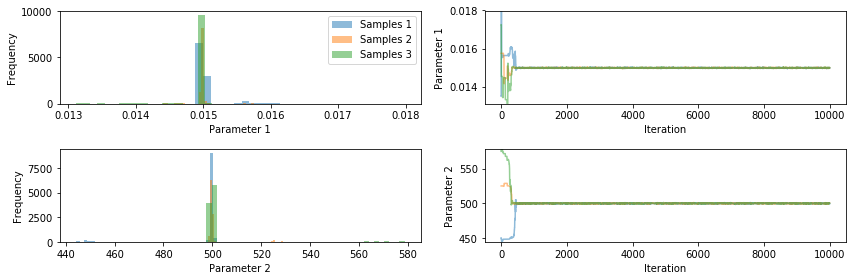

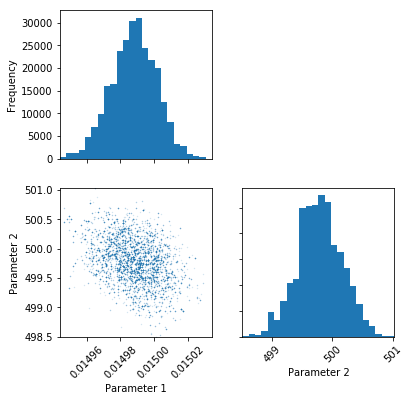

In [25]:
#chains_emu = pints.mcmc_sample(log_posterior_emu, 3, xs)
# Create mcmc routine
mcmc = pints.MCMCController(log_posterior, 3, xs)

# Add stopping criterion
mcmc.set_max_iterations(10000)

# Disable logging mode
mcmc.set_log_to_screen(False)

# Run!
print('Running...')
chains = mcmc.run()
print('Done!')

# Show traces and histograms
pints.plot.trace(chains)

# Discard warm up
chains_thin = chains[:, 2000:, :]

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(chains_thin))

# Look at distribution in chain 0
pints.plot.pairwise(chains_thin[0])

# Show graphs
plt.show()

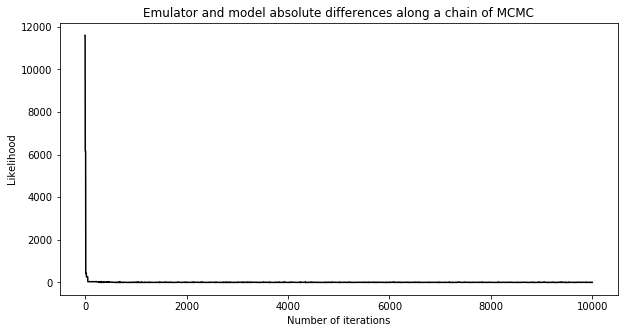

5.393954249130729

In [26]:
chain = chains[0]
emu_prediction = np.apply_along_axis(emu, 1, chain).flatten()
model_prediction = np.apply_along_axis(log_likelihood, 1, chain).flatten()
diffs = np.abs(model_prediction - emu_prediction)

iters = np.linspace(0, 10000, len(chain))
plt.figure(figsize=(10, 5))
plt.title("Emulator and model absolute differences along a chain of MCMC")
plt.xlabel("Number of iterations")
plt.ylabel("Likelihood")
plt.plot(iters, diffs, color = "Black")
plt.show()

diffs[-1]

Running...
[-7.76193723e-03  4.50008986e+02]
-inf


[1.54837193e-02 5.24419041e+02]
-5544.1357421875
accepted


[2.73638106e-02 5.77797133e+02]
-inf


[2.11304421e-02 4.50297025e+02]
-inf


[1.54249674e-02 5.25743607e+02]
-5557.79345703125


[2.88531396e-02 5.75429248e+02]
-inf


[2.82207125e-02 4.48262364e+02]
-inf


[1.80267460e-02 5.24849503e+02]
-15338.2177734375


[7.65599831e-03 5.73551546e+02]
-inf


[1.64059668e-02 4.50445967e+02]
-10977.16015625
accepted


[2.53487026e-02 5.19327035e+02]
-inf


[9.51389338e-04 5.73873817e+02]
-inf


[2.70388206e-03 4.49386152e+02]
-inf


[1.82011179e-02 5.26421276e+02]
-16216.521484375


[5.64783560e-03 5.73946724e+02]
-inf


[1.38588060e-02 4.50515241e+02]
-14024.3173828125


[1.18307972e-02 5.23563289e+02]
-17541.052734375


[1.11614475e-02 5.72351841e+02]
-22184.134765625
accepted


[3.25124072e-02 4.48650219e+02]
-inf


[8.50944709e-03 5.23503987e+02]
-inf


[2.31702758e-02 5.76764702e+02]
-inf


[2.83685846e-02 4.46396738e+02]
-inf


[7.1

[1.89204266e-02 4.60121609e+02]
-15904.8994140625


[4.46783281e-02 5.22934658e+02]
-inf


[1.93029504e-02 5.70066104e+02]
-31158.357421875


[9.53965240e-04 4.58706378e+02]
-inf


[2.35733508e-02 5.24204628e+02]
-inf


[6.45486485e-03 5.73748437e+02]
-inf


[1.63819679e-02 4.62606506e+02]
-7874.5517578125


[2.61594878e-02 5.22206386e+02]
-inf


[1.32129926e-02 5.67395455e+02]
-12841.033203125


[3.20415615e-02 4.60766744e+02]
-inf


[-2.08525119e-03  5.23994711e+02]
-inf


[1.09524444e-03 5.70938287e+02]
-inf


[1.31293661e-02 4.59396839e+02]
-12735.5888671875


[2.4716285e-02 5.2311074e+02]
-inf


[2.65440271e-02 5.68818403e+02]
-inf


[2.33286696e-02 4.59765993e+02]
-inf


[1.22815714e-02 5.22505137e+02]
-16029.7451171875


[1.70647208e-02 5.73488187e+02]
-32585.62890625


[2.09221974e-02 4.61217408e+02]
-inf


[1.90326712e-02 5.27135310e+02]
-19200.98828125


[-5.89049082e-03  5.69657310e+02]
-inf


[1.64000850e-02 4.58031661e+02]
-8922.6513671875


[4.07597730e-03 5.19232789e+02]

[1.56881801e-02 4.61745814e+02]
-6577.0595703125


[1.48472353e-02 5.23474512e+02]
-3302.198486328125


[1.32031552e-02 5.69959603e+02]
-13106.611328125


[1.54022466e-02 4.61687944e+02]
-6485.10791015625
accepted


[1.50466832e-02 5.23494657e+02]
-3656.20361328125


[1.32247481e-02 5.69898300e+02]
-13057.125


[1.54416208e-02 4.61790350e+02]
-6451.953125
accepted


[1.46458494e-02 5.23481259e+02]
-3186.0478515625


[1.34323410e-02 5.69962322e+02]
-12855.06640625


[1.54456756e-02 4.61903114e+02]
-6419.74560546875
accepted


[1.44875284e-02 5.23469907e+02]
-3307.000732421875


[1.33931312e-02 5.69834478e+02]
-12748.4453125


[1.53976080e-02 4.61747502e+02]
-6470.17333984375


[1.44797279e-02 5.23446756e+02]
-3318.69091796875


[1.32707150e-02 5.69932171e+02]
-12952.046875


[1.56618267e-02 4.61885210e+02]
-6508.89990234375


[1.45408260e-02 5.23493145e+02]
-3225.6025390625


[1.35019776e-02 5.69921118e+02]
-12799.7705078125


[1.52505755e-02 4.61960138e+02]
-6521.21533203125


[1.45080



[1.46937296e-02 5.23381704e+02]
-3156.576904296875


[1.33789767e-02 5.69935223e+02]
-12744.66015625


[1.53175700e-02 5.06125568e+02]
-1895.791259765625


[1.46907493e-02 5.23373859e+02]
-3154.155029296875
accepted


[1.33696397e-02 5.69938623e+02]
-12741.46875


[1.54460867e-02 4.66435365e+02]
-5232.17822265625


[1.46848867e-02 5.23362327e+02]
-3152.47705078125
accepted


[1.33764739e-02 5.69936901e+02]
-12742.8115234375


[1.53365654e-02 4.85450054e+02]
-2022.334716796875


[1.46806907e-02 5.23347888e+02]
-3153.603759765625


[1.33713219e-02 5.69938607e+02]
-12740.9521484375
accepted


[1.53362198e-02 4.97899378e+02]
-1535.44189453125


[1.46845430e-02 5.23358343e+02]
-3151.8359375
accepted


[1.33708233e-02 5.69939086e+02]
-12740.8564453125
accepted


[1.53321717e-02 5.09619531e+02]
-2284.545654296875


[1.46840494e-02 5.23337621e+02]
-3148.353271484375
accepted


[1.33698118e-02 5.69937472e+02]
-12741.212890625
accepted


[1.54107956e-02 5.01085574e+02]
-1832.516357421875


[1.

[1.50996742e-02 4.98018962e+02]
-1262.9033203125


[1.44371225e-02 5.09613454e+02]
-2176.56884765625


[1.33725033e-02 5.69927144e+02]
-12740.0771484375
accepted


[1.50386257e-02 4.98688959e+02]
-1231.10986328125


[1.45148561e-02 5.13849784e+02]
-2176.68359375


[1.33730856e-02 5.69926961e+02]
-12740.291015625
accepted


[1.51652819e-02 4.98432836e+02]
-1314.00732421875


[1.45022477e-02 5.13274193e+02]
-2161.300048828125


[1.33742939e-02 5.69923060e+02]
-12740.3095703125
accepted


[1.48875165e-02 5.02132428e+02]
-1256.5771484375


[1.45903473e-02 5.17835371e+02]
-2447.528564453125


[1.33766539e-02 5.69917857e+02]
-12740.6513671875
accepted


[1.50485494e-02 4.99778157e+02]
-1237.09912109375


[1.43990744e-02 5.07756051e+02]
-2256.992919921875


[1.33715747e-02 5.69939236e+02]
-12741.1337890625


[1.50553137e-02 4.97895875e+02]
-1247.85986328125


[1.45257484e-02 5.14320669e+02]
-2195.297607421875


[1.33739996e-02 5.69929214e+02]
-12740.91796875
accepted


[1.50365335e-02 5.00253

[1.49571086e-02 5.00514608e+02]
-1217.255859375
accepted


[1.44843064e-02 5.10908815e+02]
-2088.152099609375


[1.37314804e-02 5.55779601e+02]
-10653.2353515625


[1.49836611e-02 5.00281090e+02]
-1216.60107421875
accepted


[1.45231985e-02 5.12231241e+02]
-2042.4677734375
accepted


[1.35451902e-02 5.63012266e+02]
-11858.572265625


[1.50402814e-02 4.99726134e+02]
-1234.7978515625


[1.45148311e-02 5.11103009e+02]
-2007.758544921875
accepted


[1.35695797e-02 5.62264366e+02]
-11713.78515625


[1.49833919e-02 4.99967317e+02]
-1218.34130859375


[1.45085235e-02 5.11290918e+02]
-2027.929443359375


[1.39063745e-02 5.48862647e+02]
-9710.7724609375
accepted


[1.49511963e-02 5.00361272e+02]
-1218.24658203125
accepted


[1.45367349e-02 5.10792539e+02]
-1954.857666015625
accepted


[1.43970863e-02 5.29540649e+02]
-4425.03466796875
accepted


[1.49344659e-02 5.01260651e+02]
-1222.4208984375


[1.45273921e-02 5.11745767e+02]
-2013.81640625


[1.41706700e-02 5.38395844e+02]
-6713.158203125


[1


[1.44004565e-02 5.29338888e+02]
-4386.17333984375


[1.49234783e-02 5.00704351e+02]
-1219.66796875


[1.49150098e-02 5.03415969e+02]
-1293.955078125


[1.56702549e-02 4.79247383e+02]
-3192.620361328125


[1.49448949e-02 5.00564500e+02]
-1215.39111328125


[1.47099680e-02 5.06073727e+02]
-1498.5810546875


[1.44600950e-02 5.26963075e+02]
-3861.51171875


[1.49383169e-02 5.00502706e+02]
-1215.6044921875


[1.46984167e-02 5.10931269e+02]
-1716.6552734375


[1.48841408e-02 5.10292566e+02]
-1608.600341796875


[1.49422784e-02 5.00590141e+02]
-1214.8349609375


[1.49119945e-02 4.98939898e+02]
-1247.54833984375


[1.55846007e-02 4.82695245e+02]
-2648.17529296875


[1.49430977e-02 5.00764317e+02]
-1214.56494140625


[1.48469883e-02 5.01547861e+02]
-1266.91748046875


[1.54192513e-02 4.89057852e+02]
-1864.541748046875


[1.49245176e-02 5.01025562e+02]
-1221.771484375


[1.50915299e-02 4.96294194e+02]
-1256.63037109375


[1.47681763e-02 5.14815278e+02]
-2018.162841796875


[1.49189547e-02 5.009

[1.49335070e-02 5.00658316e+02]
-1213.4814453125
accepted


[1.49628139e-02 4.99546816e+02]
-1224.83984375


[1.51660458e-02 4.99152100e+02]
-1318.4716796875


[1.49280160e-02 5.00942682e+02]
-1218.27099609375


[1.50707123e-02 4.98354446e+02]
-1245.5087890625


[1.51532391e-02 4.99669388e+02]
-1315.08642578125


[1.49386735e-02 5.00463660e+02]
-1216.1572265625


[1.50065309e-02 5.01236678e+02]
-1234.9833984375


[1.50514646e-02 5.03601643e+02]
-1310.4814453125


[1.49256967e-02 5.00761799e+02]
-1218.0205078125


[1.49042329e-02 5.01145624e+02]
-1228.18017578125


[1.49411113e-02 5.08014877e+02]
-1459.67578125


[1.49345104e-02 5.00621412e+02]
-1213.890625


[1.50162291e-02 4.98403485e+02]
-1237.712890625


[1.50121373e-02 5.05158988e+02]
-1366.2705078125


[1.49226727e-02 5.00853119e+02]
-1220.212890625


[1.49083061e-02 5.01360836e+02]
-1229.39013671875


[1.51438018e-02 4.99985824e+02]
-1316.7177734375


[1.49408364e-02 5.00538728e+02]
-1215.3740234375


[1.48867270e-02 5.02844448e+

[1.50237232e-02 5.04739190e+02]
-1353.470703125


[1.49298978e-02 5.00911787e+02]
-1216.64794921875


[1.49416583e-02 5.00878305e+02]
-1214.57275390625


[1.51505919e-02 4.99719629e+02]
-1315.09423828125


[1.49336765e-02 5.01014401e+02]
-1217.0341796875


[1.49374933e-02 5.00722453e+02]
-1212.59326171875
accepted


[1.51470178e-02 4.99882298e+02]
-1317.3173828125


[1.49303476e-02 5.00732936e+02]
-1214.6171875
accepted


[1.49352136e-02 5.01028046e+02]
-1217.35595703125


[1.50285903e-02 5.04538516e+02]
-1347.94140625


[1.49334668e-02 5.00846774e+02]
-1213.66748046875
accepted


[1.49369460e-02 5.01074564e+02]
-1218.396484375


[1.50945258e-02 5.01940009e+02]
-1287.58544921875
accepted


[1.49323593e-02 5.01159814e+02]
-1220.66943359375


[1.49213892e-02 5.01230950e+02]
-1225.734375


[1.50885443e-02 5.02185153e+02]
-1286.52392578125
accepted


[1.49469250e-02 5.00891824e+02]
-1216.96142578125


[1.48826848e-02 5.01909366e+02]
-1251.99658203125


[1.51703215e-02 4.98974085e+02]
-1321


[1.49475411e-02 5.00585164e+02]
-1215.287109375
accepted


[1.49392867e-02 5.00627548e+02]
-1214.00537109375


[1.50833620e-02 5.02319494e+02]
-1284.20654296875
accepted


[1.49527309e-02 5.00706011e+02]
-1217.849609375


[1.49370137e-02 5.00680969e+02]
-1213.10498046875
accepted


[1.50854022e-02 5.02236838e+02]
-1283.94580078125
accepted


[1.49362803e-02 5.00659558e+02]
-1213.38134765625
accepted


[1.49457021e-02 5.00486638e+02]
-1216.45166015625


[1.50913611e-02 5.01905802e+02]
-1283.64111328125
accepted


[1.49334055e-02 5.00812285e+02]
-1212.99658203125
accepted


[1.49353940e-02 5.00532679e+02]
-1214.92919921875
accepted


[1.51294451e-02 5.00436227e+02]
-1304.32568359375


[1.49365319e-02 5.01027611e+02]
-1217.365234375


[1.49344050e-02 5.00640328e+02]
-1213.6708984375
accepted


[1.50508554e-02 5.03553391e+02]
-1308.494140625


[1.49381762e-02 5.00594958e+02]
-1214.30712890625


[1.49287151e-02 5.00711863e+02]
-1215.82275390625


[1.50853122e-02 5.02394928e+02]
-1286.83251



[1.50512999e-02 4.96533425e+02]
-1262.52783203125


[1.49357965e-02 5.00743038e+02]
-1212.396484375
accepted


[1.4936039e-02 5.0072976e+02]
-1212.55029296875
accepted


[1.50453265e-02 4.99262346e+02]
-1230.74072265625
accepted


[1.49437767e-02 5.00531354e+02]
-1215.74853515625


[1.49349137e-02 5.00732959e+02]
-1212.54052734375
accepted


[1.50227520e-02 5.00423525e+02]
-1234.662109375


[1.49524075e-02 5.00897958e+02]
-1219.07470703125


[1.49367637e-02 5.00683055e+02]
-1213.0859375
accepted


[1.50623677e-02 5.01897179e+02]
-1268.02001953125


[1.49304655e-02 5.00505526e+02]
-1216.1826171875


[1.49304058e-02 5.00632741e+02]
-1214.95068359375


[1.50144612e-02 4.99379992e+02]
-1228.712890625
accepted


[1.49340025e-02 5.00552112e+02]
-1214.73779296875


[1.49312202e-02 5.00805575e+02]
-1213.95458984375


[1.49779270e-02 4.99148043e+02]
-1226.52783203125
accepted


[1.49327332e-02 5.00599256e+02]
-1214.21142578125
accepted


[1.49334441e-02 5.00547675e+02]
-1214.80908203125


[1.

[1.49317881e-02 5.00663214e+02]
-1213.89990234375
accepted


[1.49452656e-02 5.00612289e+02]
-1214.79248046875
accepted


[1.50065822e-02 5.01369244e+02]
-1236.7236328125


[1.49332070e-02 5.00893005e+02]
-1214.58740234375


[1.49492475e-02 5.00469719e+02]
-1216.890625


[1.49267557e-02 5.00645829e+02]
-1217.28125


[1.49378667e-02 5.00597435e+02]
-1214.22265625
accepted


[1.49410121e-02 5.00624589e+02]
-1214.2548828125
accepted


[1.49400186e-02 5.00543872e+02]
-1215.2236328125
accepted


[1.49391092e-02 5.00215995e+02]
-1219.4736328125


[1.49405637e-02 5.00644654e+02]
-1213.94921875
accepted


[1.49720023e-02 4.99158099e+02]
-1226.7451171875


[1.49386787e-02 5.00583557e+02]
-1214.544921875
accepted


[1.49370607e-02 5.00671375e+02]
-1213.2158203125
accepted


[1.49360863e-02 5.00260104e+02]
-1218.59326171875


[1.49353564e-02 5.00598391e+02]
-1214.14404296875
accepted


[1.49381258e-02 5.00653987e+02]
-1213.4541015625
accepted


[1.49307752e-02 4.99359450e+02]
-1231.5419921875


[

[1.49292980e-02 5.00698136e+02]
-1215.3984375


[1.49332329e-02 5.00751996e+02]
-1212.67138671875
accepted


[1.49262137e-02 5.00632824e+02]
-1217.68115234375


[1.49439808e-02 5.00723853e+02]
-1214.66064453125


[1.49347275e-02 5.00848262e+02]
-1213.63720703125


[1.49352808e-02 5.00878303e+02]
-1214.20068359375
accepted


[1.49326895e-02 5.00635150e+02]
-1213.7841796875


[1.49291132e-02 5.00863312e+02]
-1216.087890625


[1.49200526e-02 5.01104001e+02]
-1224.11376953125


[1.49346237e-02 5.00799752e+02]
-1212.693359375
accepted


[1.49327339e-02 5.00697828e+02]
-1213.04345703125
accepted


[1.49128846e-02 5.01140997e+02]
-1225.6630859375


[1.49276194e-02 5.00714589e+02]
-1216.62451171875


[1.49318153e-02 5.00700858e+02]
-1213.564453125


[1.49125954e-02 5.01126748e+02]
-1225.5


[1.49325911e-02 5.01076707e+02]
-1218.7060546875


[1.49317640e-02 5.00747885e+02]
-1213.57275390625
accepted


[1.49285037e-02 5.00864547e+02]
-1216.43310546875
accepted


[1.49319450e-02 5.00540681e+02]
-

[1.49533797e-02 5.00587444e+02]
-1217.27783203125
accepted


[1.49450516e-02 5.00683169e+02]
-1214.82861328125


[1.49255182e-02 5.00660032e+02]
-1218.1845703125


[1.49473048e-02 5.00789431e+02]
-1216.38818359375
accepted


[1.49455118e-02 5.00602573e+02]
-1214.93505859375


[1.49417989e-02 5.00668456e+02]
-1213.751953125
accepted


[1.49441676e-02 5.00500950e+02]
-1216.1689453125
accepted


[1.49515430e-02 5.00608759e+02]
-1216.736328125


[1.49177158e-02 5.00732110e+02]
-1223.41259765625


[1.49604735e-02 5.00347071e+02]
-1217.59619140625


[1.49386271e-02 5.00688721e+02]
-1213.0341796875
accepted


[1.49326935e-02 5.01082440e+02]
-1218.78466796875


[1.49398247e-02 5.00470073e+02]
-1216.18359375
accepted


[1.4938534e-02 5.0069529e+02]
-1212.92529296875
accepted


[1.49524944e-02 5.00547623e+02]
-1216.71484375
accepted


[1.49476923e-02 5.00166557e+02]
-1220.41162109375


[1.49335801e-02 5.00653438e+02]
-1213.53759765625
accepted


[1.49359026e-02 5.00449546e+02]
-1216.03857421875


-1219.02880859375


[1.49362839e-02 5.00793530e+02]
-1212.4931640625
accepted


[1.49524132e-02 5.00643294e+02]
-1217.294921875


[1.49358187e-02 5.00607813e+02]
-1214.01513671875
accepted


[1.49303116e-02 5.01066427e+02]
-1219.57470703125


[1.49377449e-02 5.00567016e+02]
-1214.64013671875
accepted


[1.49270363e-02 5.00744206e+02]
-1217.041015625


[1.49397497e-02 5.00894852e+02]
-1214.51611328125


[1.4938894e-02 5.0073275e+02]
-1212.60888671875
accepted


[1.49322947e-02 5.00546345e+02]
-1214.85986328125


[1.49407113e-02 5.00601456e+02]
-1214.533203125


[1.49599797e-02 5.00628565e+02]
-1219.0400390625


[1.49417750e-02 5.00412513e+02]
-1217.13671875


[1.49338007e-02 5.00754658e+02]
-1212.52392578125
accepted


[1.49273607e-02 5.00542868e+02]
-1217.4951171875


[1.49426917e-02 5.00392922e+02]
-1217.47998046875
accepted


[1.49290052e-02 5.00853248e+02]
-1215.93701171875


[1.49544350e-02 5.00524461e+02]
-1217.08544921875


[1.49289233e-02 5.00460208e+02]
-1217.47314453125
accept

[1.49021573e-02 5.00698451e+02]
-1231.02978515625


[1.49368906e-02 5.00449623e+02]
-1216.16552734375


[1.49412877e-02 5.00622617e+02]
-1214.30859375
accepted


[1.49198051e-02 5.00784106e+02]
-1222.0732421875


[1.49406830e-02 5.00747136e+02]
-1213.4189453125


[1.49308914e-02 5.00778586e+02]
-1214.203125
accepted


[1.49370866e-02 5.00322369e+02]
-1217.86474609375


[1.49449969e-02 5.00773375e+02]
-1215.3955078125


[1.49365935e-02 5.00733078e+02]
-1212.490234375
accepted


[1.49294767e-02 5.01110517e+02]
-1220.92333984375


[1.49361976e-02 5.00751412e+02]
-1212.28662109375
accepted


[1.49171586e-02 5.00764580e+02]
-1223.5517578125


[1.49368830e-02 5.00287481e+02]
-1218.310546875


[1.49373403e-02 5.00826271e+02]
-1213.0810546875
accepted


[1.49290560e-02 5.00752074e+02]
-1215.5576171875


[1.49361933e-02 5.00632809e+02]
-1213.7041015625
accepted


[1.49335701e-02 5.00868747e+02]
-1214.09619140625


[1.49532036e-02 5.00513899e+02]
-1216.79150390625


[1.49291316e-02 5.01015333e+0

[1.49311879e-02 5.00776607e+02]
-1213.9853515625


[1.49621498e-02 5.00345601e+02]
-1217.525390625
accepted


[1.49307485e-02 5.00770994e+02]
-1214.3095703125


[1.49348207e-02 5.00847080e+02]
-1213.6123046875


[1.49550126e-02 5.00471152e+02]
-1216.84619140625
accepted


[1.49329913e-02 5.00645541e+02]
-1213.65283203125
accepted


[1.49347528e-02 5.00539596e+02]
-1214.8662109375


[1.50001944e-02 5.00244543e+02]
-1221.333984375


[1.49297920e-02 5.00467297e+02]
-1216.92822265625


[1.49493111e-02 5.00815781e+02]
-1217.3271484375


[1.49977499e-02 5.00354650e+02]
-1221.498046875


[1.49452115e-02 5.00444715e+02]
-1216.96630859375


[1.49322802e-02 5.00832549e+02]
-1213.78076171875
accepted


[1.49731797e-02 5.00273950e+02]
-1217.13623046875
accepted


[1.49422022e-02 5.00648140e+02]
-1214.06103515625


[1.49228697e-02 5.01122296e+02]
-1223.8408203125


[1.49790206e-02 5.00444952e+02]
-1218.07080078125


[1.49182216e-02 5.00460594e+02]
-1224.115234375


[1.49285206e-02 5.00923164e+02]
-

[1.49314849e-02 5.00220097e+02]
-1218.7900390625
accepted


[1.49451722e-02 5.00752976e+02]
-1215.330078125


[1.49335265e-02 5.00623159e+02]
-1213.90234375
accepted


[1.49271105e-02 5.00442011e+02]
-1218.6357421875
accepted


[1.49443758e-02 5.00682027e+02]
-1214.5869140625


[1.49394859e-02 5.00652485e+02]
-1213.681640625
accepted


[1.48966382e-02 5.00753112e+02]
-1234.783203125


[1.49277840e-02 5.00386913e+02]
-1218.81689453125


[1.49434007e-02 5.00452812e+02]
-1216.74853515625


[1.50611073e-02 5.00078828e+02]
-1243.9013671875


[1.49384603e-02 5.00744401e+02]
-1212.568359375
accepted


[1.49377829e-02 5.00515381e+02]
-1215.38232421875


[1.48484479e-02 5.00654525e+02]
-1282.89111328125


[1.49248838e-02 5.00836375e+02]
-1218.59375


[1.49297503e-02 5.00695339e+02]
-1215.0673828125


[1.49727695e-02 4.99884607e+02]
-1220.3779296875
accepted


[1.49353615e-02 5.00993238e+02]
-1216.59765625


[1.49377485e-02 5.00869496e+02]
-1213.95947265625
accepted


[1.49445527e-02 5.00347467e

[1.49656325e-02 5.00515051e+02]
-1218.173828125


[1.49538852e-02 5.00445222e+02]
-1217.2001953125
accepted


[1.49343806e-02 5.00863728e+02]
-1213.958984375


[1.49764543e-02 5.00512381e+02]
-1218.29248046875


[1.49532564e-02 5.00491387e+02]
-1216.8251953125
accepted


[1.49409801e-02 5.00954857e+02]
-1215.8408203125


[1.49050853e-02 5.01013961e+02]
-1226.04052734375


[1.49456034e-02 5.00515022e+02]
-1216.076171875
accepted


[1.49366071e-02 5.00661328e+02]
-1213.34765625


[1.48807715e-02 5.00684181e+02]
-1253.9814453125


[1.49524421e-02 5.01043409e+02]
-1220.111328125


[1.49338658e-02 5.00743337e+02]
-1212.5166015625
accepted


[1.49009487e-02 5.01142781e+02]
-1229.91796875


[1.49522078e-02 5.00348973e+02]
-1218.2646484375


[1.49306463e-02 5.00834178e+02]
-1214.6806640625


[1.49837913e-02 5.00136469e+02]
-1217.416015625


[1.49504783e-02 5.00644606e+02]
-1216.58154296875
accepted


[1.49264867e-02 5.00762087e+02]
-1217.43994140625


[1.49143043e-02 5.00851406e+02]
-1223.7412

[1.49530734e-02 5.00714382e+02]
-1218.037109375


[1.49408104e-02 5.00584532e+02]
-1214.76611328125


[1.49077797e-02 5.00926036e+02]
-1225.35009765625


[1.49639342e-02 4.99977104e+02]
-1220.95849609375


[1.49375930e-02 5.00817779e+02]
-1212.904296875


[1.4940197e-02 5.0095657e+02]
-1215.869140625


[1.49466349e-02 5.00457383e+02]
-1216.88916015625


[1.49392179e-02 5.00620407e+02]
-1214.09765625


[1.49291749e-02 5.00700148e+02]
-1215.48876953125
accepted


[1.49392547e-02 5.00745299e+02]
-1212.80810546875
accepted


[1.49324097e-02 5.01079426e+02]
-1218.85302734375


[1.49160753e-02 5.00345972e+02]
-1226.3134765625


[1.49360053e-02 5.00735831e+02]
-1212.4765625
accepted


[1.49349665e-02 5.00654634e+02]
-1213.484375


[1.49335884e-02 5.00412540e+02]
-1216.42138671875


[1.49760599e-02 5.00326428e+02]
-1216.31591796875


[1.49330876e-02 5.00689959e+02]
-1213.1162109375


[1.49517307e-02 5.00080005e+02]
-1220.9248046875


[1.49240757e-02 5.00987639e+02]
-1221.2587890625


[1.493268

[1.49531032e-02 5.00769264e+02]
-1218.43359375


[1.49610959e-02 5.00604306e+02]
-1218.8505859375


[1.49336798e-02 5.00622269e+02]
-1213.9072265625


[1.49272114e-02 5.00829577e+02]
-1216.88623046875
accepted


[1.49255392e-02 5.00761902e+02]
-1218.13818359375


[1.49235224e-02 5.00847087e+02]
-1219.58935546875


[1.49164278e-02 5.00985959e+02]
-1223.01025390625


[1.49250127e-02 5.00962666e+02]
-1220.267578125


[1.49377594e-02 5.00685005e+02]
-1213.03564453125


[1.49670220e-02 5.00560688e+02]
-1218.7041015625


[1.49111799e-02 5.01444051e+02]
-1230.1005859375


[1.49439009e-02 5.00646017e+02]
-1214.255859375


[1.49379575e-02 5.00636536e+02]
-1213.67578125
accepted


[1.49335539e-02 5.00985622e+02]
-1216.40576171875


[1.49336590e-02 5.00871883e+02]
-1214.15283203125


[1.49034657e-02 5.01096026e+02]
-1227.99267578125


[1.49375065e-02 5.00827842e+02]
-1213.10546875
accepted


[1.49391716e-02 5.00815935e+02]
-1213.20556640625
accepted


[1.49407496e-02 5.00463135e+02]
-1216.3671875

[1.48920807e-02 5.01621520e+02]
-1239.42626953125


[1.49454828e-02 5.00641965e+02]
-1214.77587890625


[1.49435670e-02 5.00630739e+02]
-1214.42529296875


[1.49280369e-02 5.00904679e+02]
-1217.49267578125


[1.49491076e-02 5.00779534e+02]
-1216.99560546875


[1.49370096e-02 5.00751817e+02]
-1212.2890625
accepted


[1.48680483e-02 5.01871655e+02]
-1251.11767578125


[1.49144956e-02 5.00944339e+02]
-1222.66015625


[1.49376903e-02 5.00650211e+02]
-1213.4501953125


[1.49247745e-02 5.01105856e+02]
-1223.169921875


[1.49353180e-02 5.00740401e+02]
-1212.44287109375
accepted


[1.49510525e-02 5.00745882e+02]
-1217.49755859375


[1.49218049e-02 5.01457030e+02]
-1229.025390625


[1.49507973e-02 5.00389404e+02]
-1218.02001953125


[1.49452415e-02 5.00781548e+02]
-1215.55029296875


[1.49175416e-02 5.01078544e+02]
-1224.1865234375


[1.49498726e-02 5.00618686e+02]
-1216.17919921875


[1.49236548e-02 5.01021251e+02]
-1222.1162109375


[1.49247129e-02 5.00865832e+02]
-1218.7080078125


[1.494442

[1.49015551e-02 5.01236343e+02]
-1230.7216796875


[1.48966031e-02 5.00956301e+02]
-1232.9072265625


[1.49399733e-02 5.00732168e+02]
-1213.0654296875
accepted


[1.49385973e-02 5.00587569e+02]
-1214.4755859375


[1.49189328e-02 5.00741881e+02]
-1222.658203125


[1.49353604e-02 5.00745926e+02]
-1212.37841796875
accepted


[1.49324943e-02 5.00966501e+02]
-1216.376953125


[1.49216663e-02 5.00541148e+02]
-1221.24267578125


[1.49245203e-02 5.00827436e+02]
-1218.86279296875


[1.49281826e-02 5.00695718e+02]
-1216.2197265625


[1.48899546e-02 5.01172761e+02]
-1236.66796875


[1.49462800e-02 5.00692278e+02]
-1215.3359375


[1.49134549e-02 5.01125967e+02]
-1225.3837890625


[1.49430380e-02 5.00693971e+02]
-1214.14208984375
accepted


[1.49315320e-02 5.00951124e+02]
-1216.578125


[1.49196912e-02 5.00830151e+02]
-1221.9892578125


[1.48894181e-02 5.01412092e+02]
-1238.4580078125


[1.49318468e-02 5.00897132e+02]
-1215.32080078125


[1.49333933e-02 5.00229126e+02]
-1218.73583984375


[1.493545


[1.49430907e-02 5.00657667e+02]
-1214.0234375
accepted


[1.49474526e-02 5.00258617e+02]
-1219.51953125


[1.49045362e-02 5.01017879e+02]
-1226.388671875


[1.49352469e-02 5.00490757e+02]
-1215.43603515625
accepted


[1.49285287e-02 5.00633240e+02]
-1216.037109375


[1.48982651e-02 5.01181733e+02]
-1231.83935546875


[1.49319835e-02 5.00622297e+02]
-1214.197265625
accepted


[1.49603046e-02 5.00645106e+02]
-1219.29052734375


[1.49221478e-02 5.00657082e+02]
-1220.6611328125


[1.49255956e-02 5.00685565e+02]
-1218.1220703125


[1.4943164e-02 5.0050359e+02]
-1216.07080078125


[1.49202021e-02 5.00942683e+02]
-1221.76513671875


[1.49329448e-02 5.00486837e+02]
-1215.55078125


[1.49237068e-02 5.00845512e+02]
-1219.4541015625


[1.49188623e-02 5.00734936e+02]
-1222.71875


[1.49262584e-02 5.00798134e+02]
-1217.5986328125


[1.49386038e-02 5.00700437e+02]
-1212.86376953125


[1.49452635e-02 5.00831196e+02]
-1215.89697265625


[1.49322628e-02 5.00413903e+02]
-1216.4462890625
accepted


[1.4



[1.49254998e-02 5.00828950e+02]
-1218.14404296875


[1.49560884e-02 5.00623752e+02]
-1218.525390625


[1.49542802e-02 5.00512351e+02]
-1216.94091796875


[1.49480756e-02 5.00549700e+02]
-1215.7822265625


[1.49584587e-02 5.00354079e+02]
-1217.68896484375


[1.49339534e-02 5.01060453e+02]
-1218.046875


[1.49447499e-02 5.00879736e+02]
-1216.0048828125


[1.49433012e-02 5.00542707e+02]
-1215.56689453125
accepted


[1.49427161e-02 5.00767457e+02]
-1214.427734375


[1.49371993e-02 5.00764977e+02]
-1212.4169921875
accepted


[1.49612726e-02 5.00740339e+02]
-1220.63623046875


[1.49342844e-02 5.01078561e+02]
-1218.44384765625


[1.49219126e-02 5.00885301e+02]
-1220.66162109375


[1.49430410e-02 5.00660267e+02]
-1213.98828125
accepted


[1.49421291e-02 5.01011533e+02]
-1217.09716796875


[1.49379433e-02 5.00689737e+02]
-1212.96630859375
accepted


[1.49437552e-02 5.00613799e+02]
-1214.66943359375


[1.49431366e-02 5.00766200e+02]
-1214.59130859375


[1.49238624e-02 5.00714685e+02]
-1219.384

[1.49404990e-02 5.00137773e+02]
-1220.6455078125


[1.49467171e-02 5.00609676e+02]
-1215.0439453125


[1.49324812e-02 5.00907260e+02]
-1215.185546875


[1.49373449e-02 5.00025391e+02]
-1221.8212890625
accepted


[1.49243444e-02 5.00625204e+02]
-1219.0595703125


[1.49409064e-02 5.00734988e+02]
-1213.47314453125
accepted


[1.49306900e-02 5.00125242e+02]
-1220.166015625
accepted


[1.49375670e-02 5.00657984e+02]
-1213.36279296875
accepted


[1.49381349e-02 5.00892632e+02]
-1214.44970703125
accepted


[1.49355665e-02 5.00249600e+02]
-1218.681640625
accepted


[1.49363845e-02 5.00818184e+02]
-1212.9716796875
accepted


[1.49435586e-02 5.00837313e+02]
-1215.2060546875


[1.49361437e-02 5.00171901e+02]
-1219.7685546875


[1.49430012e-02 5.00801423e+02]
-1214.74365234375


[1.49522366e-02 5.00888255e+02]
-1218.94384765625


[1.49497092e-02 4.99556836e+02]
-1226.23583984375


[1.49487102e-02 5.00773507e+02]
-1216.80615234375


[1.4943799e-02 5.0088432e+02]
-1215.59228515625


[1.49412658e-02 

-1214.505859375


[1.49530739e-02 5.00144848e+02]
-1220.1787109375


[1.49431581e-02 5.00827431e+02]
-1214.96484375
accepted


[1.49318368e-02 5.00697163e+02]
-1213.56591796875
accepted


[1.49696374e-02 4.99757966e+02]
-1222.125


[1.49477119e-02 5.00996632e+02]
-1218.001953125


[1.49273879e-02 5.00989694e+02]
-1219.5537109375


[1.4943367e-02 5.0067781e+02]
-1214.1875
accepted


[1.49460528e-02 5.00787468e+02]
-1215.89697265625
accepted


[1.49462084e-02 5.00726507e+02]
-1215.5390625


[1.49276143e-02 5.00080598e+02]
-1222.5556640625


[1.49570119e-02 5.00863865e+02]
-1220.57568359375


[1.49343211e-02 5.00548140e+02]
-1214.77734375
accepted


[1.49299353e-02 5.00622447e+02]
-1215.31005859375


[1.49434710e-02 5.00744969e+02]
-1214.58935546875
accepted


[1.49368683e-02 5.00744712e+02]
-1212.34423828125
accepted


[1.49686429e-02 5.00346708e+02]
-1217.01708984375


[1.49490559e-02 5.00860310e+02]
-1217.5400390625


[1.49363065e-02 5.00800337e+02]
-1212.62353515625


[1.49599398e-02 

[1.49178618e-02 5.00671056e+02]
-1223.63525390625


[1.49336831e-02 5.00754052e+02]
-1212.55322265625
accepted


[1.49393459e-02 5.00871319e+02]
-1214.001953125
accepted


[1.49298267e-02 5.00563103e+02]
-1215.9560546875
accepted


[1.49279603e-02 5.00639947e+02]
-1216.3984375


[1.49454256e-02 5.00777807e+02]
-1215.59375


[1.49168662e-02 5.00724766e+02]
-1223.93994140625


[1.49390825e-02 5.00506368e+02]
-1215.62841796875


[1.49401305e-02 5.01297566e+02]
-1223.30908203125


[1.49505746e-02 5.00036589e+02]
-1221.4443359375


[1.49454356e-02 5.00746844e+02]
-1215.3857421875


[1.49354095e-02 5.00911616e+02]
-1214.84619140625


[1.49207127e-02 5.00739574e+02]
-1221.57421875


[1.49442388e-02 5.00793019e+02]
-1215.21826171875


[1.49468520e-02 5.00860599e+02]
-1216.7109375


[1.49193861e-02 5.00889165e+02]
-1221.78662109375


[1.49278143e-02 5.00545797e+02]
-1217.22119140625


[1.49315785e-02 5.00976968e+02]
-1217.07470703125


[1.49139876e-02 5.00950409e+02]
-1222.85595703125


[1.4941

[1.49414397e-02 5.00998607e+02]
-1216.80712890625


[1.49379324e-02 5.00648302e+02]
-1213.5009765625
accepted


[1.49206712e-02 5.00603191e+02]
-1221.9150390625


[1.49438819e-02 5.00241135e+02]
-1219.52099609375


[1.49290973e-02 5.00588890e+02]
-1216.09716796875


[1.49354861e-02 5.00737709e+02]
-1212.4697265625
accepted


[1.49308096e-02 5.00668914e+02]
-1214.37353515625


[1.49352341e-02 5.00773543e+02]
-1212.150390625
accepted


[1.49344678e-02 5.00720152e+02]
-1212.712890625
accepted


[1.49379871e-02 5.00877401e+02]
-1214.12451171875


[1.49396813e-02 5.01088240e+02]
-1218.73388671875


[1.49418915e-02 5.00414390e+02]
-1217.125


[1.49348329e-02 5.00920489e+02]
-1215.048828125


[1.49430058e-02 5.00375922e+02]
-1217.7216796875


[1.49408261e-02 5.00770700e+02]
-1213.5849609375
accepted


[1.49365944e-02 5.00947749e+02]
-1215.623046875


[1.49371265e-02 5.00501881e+02]
-1215.47607421875


[1.49386361e-02 5.00705260e+02]
-1212.79736328125
accepted


[1.49442078e-02 5.00787986e+02]

[1.49222576e-02 5.01032482e+02]
-1222.66357421875


[1.49330258e-02 5.01180663e+02]
-1220.81640625


[1.49359713e-02 5.00751410e+02]
-1212.29052734375
accepted


[1.49448271e-02 5.00839578e+02]
-1215.7734375


[1.49368539e-02 5.00772287e+02]
-1212.38427734375
accepted


[1.49196795e-02 5.00663803e+02]
-1222.39501953125


[1.49309411e-02 5.01009784e+02]
-1218.07763671875


[1.49415683e-02 5.00860365e+02]
-1214.427734375


[1.49314503e-02 5.00693255e+02]
-1213.837890625
accepted


[1.49399322e-02 5.00704716e+02]
-1213.00048828125
accepted


[1.49392348e-02 5.00530139e+02]
-1215.330078125


[1.49304628e-02 5.00713873e+02]
-1214.537109375


[1.49425634e-02 5.00848337e+02]
-1214.814453125


[1.49435185e-02 5.00650636e+02]
-1214.16064453125


[1.49300137e-02 5.01206101e+02]
-1222.7490234375


[1.49451491e-02 5.00812437e+02]
-1215.72021484375


[1.49487491e-02 5.00740176e+02]
-1216.58642578125


[1.49350935e-02 5.00683210e+02]
-1213.1357421875
accepted


[1.49504039e-02 5.00270013e+02]
-1219.

[1.49488851e-02 5.00533935e+02]
-1216.0361328125


[1.49364340e-02 5.00561613e+02]
-1214.55126953125


[1.49400558e-02 5.00826752e+02]
-1213.548828125


[1.49346661e-02 5.01089763e+02]
-1218.6962890625


[1.49493714e-02 5.00613707e+02]
-1215.9677734375


[1.49313682e-02 5.00806331e+02]
-1213.84375


[1.49371636e-02 5.00739708e+02]
-1212.39453125
accepted


[1.49387014e-02 5.00872194e+02]
-1214.017578125


[1.49310248e-02 5.00860495e+02]
-1215.01513671875


[1.49394494e-02 5.00813417e+02]
-1213.26513671875


[1.49369933e-02 5.00804922e+02]
-1212.67919921875
accepted


[1.49281514e-02 5.00809386e+02]
-1216.20263671875


[1.49371179e-02 5.00776723e+02]
-1212.470703125
accepted


[1.49231591e-02 5.00672032e+02]
-1219.91259765625


[1.49520515e-02 5.00793852e+02]
-1218.20751953125


[1.49293730e-02 5.00784648e+02]
-1215.3173828125


[1.49356369e-02 5.00427761e+02]
-1216.31005859375


[1.49328267e-02 5.00675723e+02]
-1213.29443359375


[1.49354219e-02 5.01018936e+02]
-1217.16015625


[1.4931

[1.49446927e-02 5.00738542e+02]
-1215.0498046875


[1.49298909e-02 5.00928464e+02]
-1216.98876953125


[1.49475034e-02 5.00493113e+02]
-1216.4794921875
accepted


[1.49472205e-02 5.00617300e+02]
-1215.25


[1.49212232e-02 5.00861430e+02]
-1221.11181640625


[1.49452713e-02 5.00806234e+02]
-1215.72802734375
accepted


[1.49317733e-02 5.00987788e+02]
-1217.1904296875


[1.49396038e-02 5.00679176e+02]
-1213.31787109375


[1.49484557e-02 5.00740998e+02]
-1216.47900390625
accepted


[1.49388915e-02 5.00815979e+02]
-1213.1279296875
accepted


[1.49356799e-02 5.00884931e+02]
-1214.31201171875


[1.49485245e-02 5.00776648e+02]
-1216.75439453125


[1.49462349e-02 5.00728846e+02]
-1215.56396484375


[1.49389647e-02 5.00440854e+02]
-1216.4833984375


[1.49258480e-02 5.00540253e+02]
-1218.33984375


[1.49473271e-02 5.00716692e+02]
-1215.892578125


[1.49334369e-02 5.00665773e+02]
-1213.396484375


[1.49419126e-02 5.00701675e+02]
-1213.75390625
accepted


[1.49481729e-02 5.00448686e+02]
-1217.09570

[1.49332090e-02 5.00915068e+02]
-1215.01904296875
accepted


[1.49352671e-02 5.00749191e+02]
-1212.33740234375
accepted


[1.49383153e-02 5.00862322e+02]
-1213.8076171875


[1.49330701e-02 5.01076691e+02]
-1218.4794921875


[1.49395303e-02 5.00548171e+02]
-1215.12109375


[1.49374731e-02 5.00499262e+02]
-1215.56689453125


[1.49371672e-02 5.00733602e+02]
-1212.46728515625
accepted


[1.49291088e-02 5.00700687e+02]
-1215.53564453125


[1.49253944e-02 5.00965046e+02]
-1220.11376953125


[1.49409537e-02 5.00877633e+02]
-1214.28662109375


[1.49386992e-02 5.00813231e+02]
-1213.05615234375
accepted


[1.49445119e-02 5.00700205e+02]
-1214.72509765625


[1.49457818e-02 5.00650547e+02]
-1214.921875


[1.49321809e-02 5.00725911e+02]
-1213.27392578125
accepted


[1.49377312e-02 5.00690206e+02]
-1212.96875


[1.49355507e-02 5.00825008e+02]
-1213.14453125
accepted


[1.49279662e-02 5.00818650e+02]
-1216.33740234375


[1.49446486e-02 5.00858861e+02]
-1215.8310546875


[1.49401229e-02 5.01087662e+02


[1.49181326e-02 5.00576983e+02]
-1223.7724609375


[1.49391552e-02 5.00322568e+02]
-1218.0703125


[1.49229614e-02 5.00984098e+02]
-1221.6982421875


[1.49414978e-02 5.00513105e+02]
-1215.77880859375


[1.49366711e-02 5.00803407e+02]
-1212.66455078125
accepted


[1.49307969e-02 5.00689328e+02]
-1214.30029296875
accepted


[1.49207911e-02 5.00588675e+02]
-1221.853515625


[1.49423349e-02 5.00687576e+02]
-1213.8447265625


[1.49274976e-02 5.00836913e+02]
-1216.677734375


[1.49409206e-02 5.00718490e+02]
-1213.41455078125
accepted


[1.49434984e-02 5.00740213e+02]
-1214.5703125


[1.49238424e-02 5.00680760e+02]
-1219.4091796875


[1.49499704e-02 5.01016908e+02]
-1218.99169921875


[1.49499385e-02 5.00577432e+02]
-1215.98291015625


[1.49417873e-02 5.00412096e+02]
-1217.14501953125


[1.49497156e-02 5.01247362e+02]
-1223.12841796875


[1.49294532e-02 5.00651143e+02]
-1215.3427734375


[1.49164654e-02 5.00806782e+02]
-1223.4150390625


[1.49476968e-02 5.01076724e+02]
-1219.4345703125


[1.

-1214.6845703125
accepted


[1.49496408e-02 5.00696706e+02]
-1216.61572265625


[1.49309332e-02 5.00999738e+02]
-1217.876953125


[1.49406827e-02 5.00931117e+02]
-1215.32373046875
accepted


[1.49408610e-02 5.00905754e+02]
-1214.7705078125


[1.49346404e-02 5.00833295e+02]
-1213.35009765625
accepted


[1.49360404e-02 5.00804713e+02]
-1212.71923828125
accepted


[1.49425286e-02 5.01181504e+02]
-1220.81201171875


[1.49512960e-02 5.00472397e+02]
-1216.984375


[1.49293847e-02 5.00772877e+02]
-1215.31005859375


[1.49443189e-02 5.00744014e+02]
-1214.9306640625


[1.49406437e-02 5.00450024e+02]
-1216.52783203125
accepted


[1.49372695e-02 5.00169521e+02]
-1219.908203125


[1.49378954e-02 5.00704095e+02]
-1212.79931640625
accepted


[1.49496443e-02 5.00446769e+02]
-1217.2109375


[1.49353346e-02 5.01073205e+02]
-1218.3408203125


[1.49238476e-02 5.00451535e+02]
-1220.4814453125


[1.49362246e-02 5.00427879e+02]
-1216.38720703125
accepted


[1.49279873e-02 5.00411198e+02]
-1218.46484375


[1



[1.49343060e-02 5.00674689e+02]
-1213.2607421875
accepted


[1.49402208e-02 5.01011786e+02]
-1217.076171875


[1.49413090e-02 5.00307575e+02]
-1218.4794921875


[1.49250166e-02 5.00743520e+02]
-1218.52587890625


[1.49434082e-02 5.00688022e+02]
-1214.25244140625
accepted


[1.49360779e-02 5.00799181e+02]
-1212.611328125
accepted


[1.49317233e-02 5.00997739e+02]
-1217.42041015625


[1.49442707e-02 5.00693993e+02]
-1214.60693359375
accepted


[1.49283447e-02 5.00295304e+02]
-1219.51953125


[1.49356244e-02 5.00901557e+02]
-1214.63818359375


[1.49405411e-02 5.00485040e+02]
-1216.05419921875
accepted


[1.49401198e-02 5.01062011e+02]
-1218.169921875


[1.49239780e-02 5.00358951e+02]
-1221.509765625


[1.49492713e-02 5.00607052e+02]
-1215.9013671875
accepted


[1.49425324e-02 5.00707720e+02]
-1214.013671875


[1.49238178e-02 5.00423065e+02]
-1220.8427734375


[1.49422682e-02 5.00787128e+02]
-1214.33203125
accepted


[1.49360649e-02 5.00745384e+02]
-1212.36083984375
accepted


[1.4930446

-1213.47216796875
accepted


[1.49488597e-02 5.00249639e+02]
-1219.51806640625


[1.49257046e-02 5.00858614e+02]
-1217.9833984375


[1.49331296e-02 5.01226957e+02]
-1221.7978515625


[1.49487581e-02 5.00879089e+02]
-1217.5625


[1.49319617e-02 5.00749327e+02]
-1213.42822265625
accepted


[1.49356291e-02 5.01100573e+02]
-1218.9443359375


[1.49032838e-02 5.00812861e+02]
-1229.08984375


[1.49444403e-02 5.01048732e+02]
-1218.248046875


[1.49364529e-02 5.00706173e+02]
-1212.81640625
accepted


[1.49335256e-02 5.00864214e+02]
-1214.0087890625
accepted


[1.49282340e-02 5.00328613e+02]
-1219.19140625


[1.49343921e-02 5.00264213e+02]
-1218.37255859375


[1.49178077e-02 5.00796771e+02]
-1223.00341796875


[1.49442239e-02 5.00683676e+02]
-1214.53955078125


[1.49280339e-02 5.00741625e+02]
-1216.3134765625


[1.49237453e-02 5.01376448e+02]
-1227.46630859375


[1.49330342e-02 5.00753472e+02]
-1212.71875
accepted


[1.49415394e-02 5.00757284e+02]
-1213.8349609375


[1.49424403e-02 5.00917882e+0

[1.49585373e-02 5.00510668e+02]
-1217.36669921875


[1.49214389e-02 5.00791288e+02]
-1221.06591796875


[1.49453265e-02 5.00994226e+02]
-1217.3681640625


[1.49121427e-02 5.01104079e+02]
-1225.234375


[1.49305233e-02 5.00566066e+02]
-1215.55029296875


[1.49396314e-02 5.00814544e+02]
-1213.318359375
accepted


[1.49615940e-02 5.00103572e+02]
-1219.90185546875


[1.49263009e-02 5.00761393e+02]
-1217.5751953125


[1.49370163e-02 5.00655442e+02]
-1213.40966796875
accepted


[1.49214357e-02 5.00946200e+02]
-1221.5263671875


[1.49300616e-02 5.00880628e+02]
-1215.93310546875


[1.49402468e-02 5.01094240e+02]
-1218.8759765625


[1.49133006e-02 5.00964533e+02]
-1223.1845703125


[1.49347642e-02 5.00423000e+02]
-1216.26123046875


[1.49379889e-02 5.00708383e+02]
-1212.74462890625
accepted


[1.49406223e-02 5.00618036e+02]
-1214.30224609375
accepted


[1.49418614e-02 5.00681499e+02]
-1213.6396484375


[1.49387671e-02 5.00772509e+02]
-1212.810546875
accepted


[1.49452727e-02 5.00484501e+02]
-1


[1.49338065e-02 5.01080567e+02]
-1218.47900390625


[1.49220777e-02 5.01105883e+02]
-1223.75


[1.49425757e-02 5.00649293e+02]
-1214.0830078125
accepted


[1.49059576e-02 5.01225380e+02]
-1228.30712890625


[1.49374437e-02 5.00646801e+02]
-1213.49853515625
accepted


[1.49413114e-02 5.00414120e+02]
-1217.0703125


[1.49286581e-02 5.00619323e+02]
-1216.0322265625


[1.49309766e-02 5.00859233e+02]
-1215.01416015625


[1.49359870e-02 5.01144898e+02]
-1219.9169921875


[1.49286239e-02 5.01230624e+02]
-1223.89697265625


[1.49325472e-02 5.00846176e+02]
-1213.91845703125
accepted


[1.49360870e-02 5.00625804e+02]
-1213.791015625
accepted


[1.49268114e-02 5.01459555e+02]
-1228.36962890625


[1.49372294e-02 5.00723881e+02]
-1212.583984375
accepted


[1.49176610e-02 5.00681609e+02]
-1223.72705078125


[1.49289038e-02 5.00659238e+02]
-1215.70068359375


[1.49369212e-02 5.00488918e+02]
-1215.63037109375


[1.49493441e-02 5.00701631e+02]
-1216.54150390625


[1.49249419e-02 5.00772313e+02]
-1218.

[1.49415393e-02 5.00751212e+02]
-1213.8017578125


[1.49426295e-02 5.00698227e+02]
-1214.00732421875


[1.49333284e-02 5.00588513e+02]
-1214.322265625
accepted


[1.49250256e-02 5.00666553e+02]
-1218.5478515625


[1.49356102e-02 5.00922369e+02]
-1215.068359375


[1.49172069e-02 5.00848907e+02]
-1222.744140625


[1.49122868e-02 5.01003517e+02]
-1223.8896484375


[1.49416702e-02 5.00656923e+02]
-1213.89404296875


[1.49210633e-02 5.00313603e+02]
-1223.89404296875


[1.49491761e-02 5.00137714e+02]
-1220.5625


[1.49389332e-02 5.00669611e+02]
-1213.35400390625
accepted


[1.49306726e-02 5.00577665e+02]
-1215.353515625


[1.49517090e-02 5.00169438e+02]
-1220.04541015625


[1.49145334e-02 5.00996061e+02]
-1223.39599609375


[1.49255826e-02 5.00819447e+02]
-1218.08251953125


[1.49518082e-02 5.00434463e+02]
-1217.49755859375


[1.49435895e-02 5.00585875e+02]
-1215.02392578125


[1.49393801e-02 5.00729419e+02]
-1212.80224609375
accepted


[1.49322343e-02 5.00408481e+02]
-1216.51220703125


[1.


[1.49358446e-02 5.00749116e+02]
-1212.3232421875
accepted


[1.49566921e-02 5.00354504e+02]
-1217.82666015625
accepted


[1.49271517e-02 5.00716879e+02]
-1216.96728515625


[1.49309621e-02 5.00931296e+02]
-1216.478515625


[1.49618919e-02 5.00384242e+02]
-1217.20751953125
accepted


[1.49440881e-02 5.00508491e+02]
-1216.06494140625
accepted


[1.49509913e-02 5.00332241e+02]
-1218.53564453125


[1.49620892e-02 5.00582088e+02]
-1218.69873046875


[1.49485977e-02 5.00611435e+02]
-1215.69189453125
accepted


[1.49361739e-02 5.00484318e+02]
-1215.58349609375
accepted


[1.49708819e-02 5.00309723e+02]
-1217.0869140625
accepted


[1.49501241e-02 5.00489868e+02]
-1216.6826171875


[1.49178186e-02 5.00805938e+02]
-1222.94384765625


[1.49898141e-02 5.00094764e+02]
-1218.09228515625


[1.49321392e-02 5.00378354e+02]
-1216.8779296875


[1.49263812e-02 5.00785171e+02]
-1217.5107421875


[1.49958087e-02 5.00259349e+02]
-1219.5380859375
accepted


[1.49652091e-02 5.00507728e+02]
-1218.0908203125
ac


[1.49424973e-02 5.00611193e+02]
-1214.580078125
accepted


[1.49201142e-02 5.00769509e+02]
-1221.9033203125


[1.49666381e-02 5.00370093e+02]
-1217.04443359375
accepted


[1.49367334e-02 5.00962214e+02]
-1215.94189453125


[1.49312224e-02 5.00642156e+02]
-1214.41650390625


[1.49479565e-02 5.00301139e+02]
-1218.99609375


[1.49420595e-02 5.00329882e+02]
-1218.255859375


[1.49412429e-02 5.00693648e+02]
-1213.46337890625
accepted


[1.49630244e-02 5.00403214e+02]
-1217.0
accepted


[1.49319783e-02 5.00577968e+02]
-1214.6435546875
accepted


[1.49221877e-02 5.01055465e+02]
-1223.005859375


[1.49523117e-02 5.00501598e+02]
-1216.669921875
accepted


[1.49386190e-02 5.00495979e+02]
-1215.7216796875


[1.49330471e-02 5.00545066e+02]
-1214.8515625


[1.49255158e-02 5.00695034e+02]
-1218.17431640625
accepted


[1.49318910e-02 5.01067364e+02]
-1218.830078125


[1.49615141e-02 5.00707092e+02]
-1220.23193359375


[1.48975104e-02 5.00747739e+02]
-1234.1376953125


[1.49234683e-02 5.00560395e+02]

[1.49423943e-02 5.00567968e+02]
-1215.14306640625


[1.49319211e-02 5.00605906e+02]
-1214.396484375
accepted


[1.49148676e-02 5.00311905e+02]
-1227.353515625


[1.49584452e-02 5.00378175e+02]
-1217.455078125


[1.49327376e-02 5.00727963e+02]
-1212.86474609375
accepted


[1.49718820e-02 5.00525928e+02]
-1218.37255859375


[1.49491191e-02 5.00589326e+02]
-1215.763671875


[1.49197518e-02 5.00566470e+02]
-1222.68359375


[1.49639934e-02 5.00181016e+02]
-1218.94873046875


[1.49308409e-02 5.00979509e+02]
-1217.51708984375


[1.49309362e-02 5.00641857e+02]
-1214.57177734375


[1.49254772e-02 5.00716648e+02]
-1218.197265625


[1.49279093e-02 5.01095358e+02]
-1221.41650390625


[1.49371582e-02 5.01055311e+02]
-1217.978515625


[1.49405086e-02 5.00837002e+02]
-1213.80859375


[1.49223375e-02 5.00637601e+02]
-1220.5283203125


[1.49380642e-02 5.00766781e+02]
-1212.62109375
accepted


[1.49280940e-02 5.00826334e+02]
-1216.23974609375


[1.49500956e-02 5.00718051e+02]
-1216.93603515625


[1.4952

[1.49253117e-02 5.01238387e+02]
-1225.1162109375


[1.49436897e-02 5.00649479e+02]
-1214.189453125


[1.49282882e-02 5.00590875e+02]
-1216.5166015625


[1.49181753e-02 5.00926276e+02]
-1221.9140625


[1.49292353e-02 5.00613399e+02]
-1215.7783203125


[1.49540214e-02 5.00272600e+02]
-1218.84912109375


[1.49295014e-02 5.00196497e+02]
-1219.9775390625


[1.49265023e-02 5.00972319e+02]
-1219.67431640625


[1.49564273e-02 5.00571074e+02]
-1217.888671875


[1.49330641e-02 5.00803735e+02]
-1212.8447265625
accepted


[1.49393567e-02 5.00331503e+02]
-1217.9697265625


[1.49242818e-02 5.00977030e+02]
-1220.9404296875


[1.49185564e-02 5.01148448e+02]
-1225.03759765625


[1.49216006e-02 5.00591953e+02]
-1221.17431640625


[1.49313937e-02 5.00757870e+02]
-1213.84228515625
accepted


[1.49265059e-02 5.01300829e+02]
-1225.7958984375


[1.49380438e-02 5.00360020e+02]
-1217.46533203125


[1.49205941e-02 5.01123595e+02]
-1224.2900390625


[1.49486823e-02 5.00899065e+02]
-1217.673828125


[1.49320890e-



[1.49479573e-02 5.00721112e+02]
-1216.15576171875


[1.49408466e-02 5.00562723e+02]
-1215.05908203125


[1.49429667e-02 5.00967470e+02]
-1216.37109375


[1.49267222e-02 5.00663045e+02]
-1217.30126953125


[1.49385306e-02 5.00909625e+02]
-1214.8203125


[1.49349388e-02 5.00631381e+02]
-1213.763671875


[1.49385247e-02 5.00768494e+02]
-1212.73388671875
accepted


[1.49394541e-02 5.01285182e+02]
-1223.03076171875


[1.49326029e-02 5.01028899e+02]
-1217.63623046875


[1.49393146e-02 5.00969316e+02]
-1216.13525390625


[1.49528558e-02 5.00254541e+02]
-1219.1181640625


[1.49478989e-02 5.00855815e+02]
-1217.07470703125


[1.49262466e-02 5.00887391e+02]
-1218.09228515625


[1.49483243e-02 5.00453965e+02]
-1217.03857421875


[1.49506149e-02 5.00835155e+02]
-1217.9580078125


[1.49417115e-02 5.00981588e+02]
-1216.44140625


[1.49159893e-02 5.01217877e+02]
-1226.3935546875


[1.49399018e-02 5.00686976e+02]
-1213.25244140625
accepted


[1.49378148e-02 5.01187904e+02]
-1220.8818359375


[1.49341

[1.49497129e-02 5.00676232e+02]
-1216.51025390625


[1.50109617e-02 4.99478333e+02]
-1228.140625


[1.49345064e-02 5.00523876e+02]
-1215.0625


[1.49131688e-02 5.01306114e+02]
-1227.99658203125


[1.49608486e-02 5.00464494e+02]
-1217.09716796875


[1.49498388e-02 5.00925007e+02]
-1218.29541015625


[1.49313171e-02 5.00611190e+02]
-1214.67138671875


[1.49418847e-02 5.00738104e+02]
-1213.89697265625
accepted


[1.49484298e-02 5.00822886e+02]
-1217.044921875


[1.49391318e-02 5.00799595e+02]
-1213.06689453125
accepted


[1.49312566e-02 5.01253708e+02]
-1223.21533203125


[1.49352547e-02 5.00437974e+02]
-1216.103515625


[1.49553706e-02 5.00380714e+02]
-1217.67236328125


[1.49448011e-02 5.00653681e+02]
-1214.6005859375


[1.49379494e-02 5.00627733e+02]
-1213.802734375
accepted


[1.49479353e-02 5.00577542e+02]
-1215.41162109375


[1.49874525e-02 5.00054097e+02]
-1218.14892578125


[1.49487176e-02 5.00639698e+02]
-1215.892578125


[1.49514515e-02 5.00689287e+02]
-1217.2509765625


[1.4870

[1.49185731e-02 5.01334440e+02]
-1227.79248046875


[1.49506306e-02 5.00732728e+02]
-1217.24267578125


[1.49421237e-02 5.00762985e+02]
-1214.1318359375


[1.48817436e-02 5.01544376e+02]
-1247.0654296875


[1.49443926e-02 5.00164260e+02]
-1220.55419921875


[1.49247778e-02 5.00747536e+02]
-1218.69970703125


[1.50136014e-02 5.00443731e+02]
-1229.4375


[1.49546921e-02 5.00808453e+02]
-1219.3095703125
accepted


[1.49305516e-02 5.00876938e+02]
-1215.59521484375


[1.49605342e-02 5.00635990e+02]
-1219.1943359375


[1.49603109e-02 5.00811858e+02]
-1221.453125


[1.49452176e-02 5.00338876e+02]
-1218.3388671875


[1.49666305e-02 5.00481274e+02]
-1217.80224609375


[1.49633027e-02 5.00859431e+02]
-1222.22509765625


[1.49270069e-02 5.01184539e+02]
-1223.6669921875


[1.49678438e-02 5.00598924e+02]
-1219.15673828125


[1.49493323e-02 5.00811961e+02]
-1217.30908203125
accepted


[1.49267729e-02 5.00346791e+02]
-1219.89208984375


[1.49807888e-02 5.00729974e+02]
-1222.67236328125


[1.49581543e

[1.49341273e-02 5.00640722e+02]
-1213.67578125
accepted


[1.49741533e-02 5.00484538e+02]
-1217.92626953125
accepted


[1.49357327e-02 5.01026415e+02]
-1217.32666015625


[1.49319330e-02 5.00755092e+02]
-1213.44482421875
accepted


[1.49493921e-02 5.01087662e+02]
-1219.91064453125


[1.49511899e-02 5.00615288e+02]
-1216.6484375


[1.4927584e-02 5.0061497e+02]
-1216.7412109375


[1.49704091e-02 5.00793114e+02]
-1221.486328125


[1.49422737e-02 5.01151055e+02]
-1220.14599609375


[1.49399607e-02 5.00546373e+02]
-1215.18798828125


[1.49371914e-02 5.01246078e+02]
-1222.14599609375


[1.49326689e-02 5.00804947e+02]
-1213.01953125
accepted


[1.49226858e-02 5.00553100e+02]
-1220.37158203125


[1.49929502e-02 5.00217515e+02]
-1217.93310546875
accepted


[1.49421292e-02 5.00862198e+02]
-1214.69384765625


[1.49147603e-02 5.01194884e+02]
-1226.20556640625


[1.50004611e-02 5.00052569e+02]
-1219.6103515625


[1.49195358e-02 5.00570491e+02]
-1222.8193359375


[1.49224976e-02 5.01006630e+02]
-122

[1.49510616e-02 5.00533749e+02]
-1216.171875


[1.49484865e-02 5.00252888e+02]
-1219.521484375


[1.49185274e-02 5.00100251e+02]
-1228.04931640625


[1.49397726e-02 5.00473025e+02]
-1216.13720703125
accepted


[1.49555289e-02 5.00354260e+02]
-1217.92236328125


[1.49291706e-02 5.00969030e+02]
-1218.18994140625


[1.49315834e-02 5.00609002e+02]
-1214.55029296875
accepted


[1.49141492e-02 5.01228013e+02]
-1226.75634765625


[1.49270774e-02 5.01060151e+02]
-1221.1376953125


[1.49405883e-02 5.00347244e+02]
-1217.8828125


[1.49023862e-02 5.01125987e+02]
-1228.93896484375


[1.49497138e-02 5.00664557e+02]
-1216.4296875


[1.49289140e-02 5.00579841e+02]
-1216.28466796875


[1.49614202e-02 5.00470552e+02]
-1217.24169921875


[1.49563498e-02 5.00693968e+02]
-1219.1318359375


[1.49329577e-02 5.00104007e+02]
-1220.388671875


[1.49067605e-02 5.00769384e+02]
-1227.4541015625


[1.49328995e-02 5.00925992e+02]
-1215.34130859375
accepted


[1.49358294e-02 5.00803399e+02]
-1212.705078125
accepted




[1.49370597e-02 5.00783042e+02]
-1212.5
accepted


[1.49407013e-02 5.00779626e+02]
-1213.578125
accepted


[1.49357629e-02 5.00571962e+02]
-1214.44677734375
accepted


[1.49354896e-02 5.00930836e+02]
-1215.2470703125


[1.49401950e-02 5.01094189e+02]
-1218.87060546875


[1.49481283e-02 5.00587306e+02]
-1215.41455078125


[1.49330088e-02 5.00618530e+02]
-1213.97509765625


[1.49465872e-02 5.00543472e+02]
-1215.76806640625


[1.49268331e-02 5.00879724e+02]
-1217.625


[1.49390230e-02 5.00212106e+02]
-1219.5185546875


[1.49470559e-02 5.00783875e+02]
-1216.2529296875


[1.49123323e-02 5.00790755e+02]
-1225.134765625


[1.49393795e-02 5.00889043e+02]
-1214.38427734375
accepted


[1.49340725e-02 5.00911429e+02]
-1214.90869140625


[1.49407239e-02 5.00232712e+02]
-1219.41015625


[1.49591942e-02 5.00728160e+02]
-1220.24365234375


[1.49389090e-02 5.00852842e+02]
-1213.60693359375
accepted


[1.49270672e-02 5.00771951e+02]
-1217.00927734375


[1.49403734e-02 5.00642761e+02]
-1213.9521484375

-1224.03466796875


[1.49266038e-02 5.01161836e+02]
-1223.4150390625


[1.49175013e-02 5.00730847e+02]
-1223.541015625


[1.49343706e-02 5.00743105e+02]
-1212.44091796875
accepted


[1.49303541e-02 5.01001325e+02]
-1218.2197265625


[1.49616177e-02 5.00569660e+02]
-1218.48291015625


[1.49298951e-02 5.01087024e+02]
-1220.2177734375


[1.49268683e-02 5.01030696e+02]
-1220.662109375


[1.49527532e-02 5.00217786e+02]
-1219.4853515625


[1.49210102e-02 5.00883623e+02]
-1221.15625


[1.49470060e-02 5.00989683e+02]
-1217.708984375


[1.49252589e-02 5.00746420e+02]
-1218.34814453125


[1.49274913e-02 5.00789879e+02]
-1216.6962890625


[1.49380445e-02 5.00684657e+02]
-1213.02880859375
accepted


[1.49414847e-02 5.00396259e+02]
-1217.32568359375


[1.49287040e-02 5.00872976e+02]
-1216.4990234375


[1.49596773e-02 5.00638883e+02]
-1219.13525390625


[1.49625497e-02 5.00000244e+02]
-1220.84521484375


[1.49329645e-02 5.01068191e+02]
-1218.34130859375


[1.49337526e-02 5.00909635e+02]
-1214.886230

-1214.5751953125


[1.49598298e-02 5.00420082e+02]
-1216.9892578125


[1.49393376e-02 5.00799750e+02]
-1213.1259765625
accepted


[1.49305985e-02 5.00575917e+02]
-1215.4130859375


[1.49783187e-02 5.00184660e+02]
-1216.92822265625


[1.49484911e-02 5.00773756e+02]
-1216.72314453125


[1.49228392e-02 5.01041506e+02]
-1222.67822265625


[1.49229662e-02 5.01058874e+02]
-1222.90771484375


[1.49203484e-02 5.01032034e+02]
-1223.017578125


[1.49393038e-02 5.01100559e+02]
-1218.9990234375


[1.49258340e-02 5.01124011e+02]
-1223.04443359375


[1.49356058e-02 5.00423804e+02]
-1216.36083984375
accepted


[1.49359446e-02 5.00911894e+02]
-1214.84716796875


[1.49369846e-02 5.00866504e+02]
-1213.8876953125
accepted


[1.49388146e-02 5.00270654e+02]
-1218.72216796875


[1.49342086e-02 5.00872013e+02]
-1214.12939453125


[1.49155942e-02 5.01041168e+02]
-1223.90234375


[1.49289237e-02 5.00581845e+02]
-1216.26123046875
accepted


[1.49374579e-02 5.00893307e+02]
-1214.45751953125


[1.49219627e-02 5.0

[1.49382688e-02 5.00818004e+02]
-1212.986328125
accepted


[1.49297358e-02 5.01039673e+02]
-1219.3193359375


[1.49420638e-02 5.00894974e+02]
-1214.88330078125


[1.49560919e-02 5.00288648e+02]
-1218.5205078125


[1.49364706e-02 5.00930384e+02]
-1215.24609375
accepted


[1.49430178e-02 5.00742549e+02]
-1214.392578125
accepted


[1.49364457e-02 5.00769913e+02]
-1212.27978515625
accepted


[1.49536396e-02 5.00887867e+02]
-1219.470703125


[1.49436595e-02 5.00689089e+02]
-1214.35205078125
accepted


[1.49684274e-02 5.00526354e+02]
-1218.3203125


[1.49416676e-02 5.00975337e+02]
-1216.302734375


[1.49494080e-02 5.00645403e+02]
-1216.18798828125


[1.49177764e-02 5.01105252e+02]
-1224.53515625


[1.49365315e-02 5.01006363e+02]
-1216.900390625


[1.49442026e-02 5.00735316e+02]
-1214.8251953125
accepted


[1.49347995e-02 5.00265745e+02]
-1218.3916015625


[1.49346780e-02 5.00905129e+02]
-1214.75634765625
accepted


[1.49375781e-02 5.00902716e+02]
-1214.6591796875
accepted


[1.49051408e-02 5

[1.49535554e-02 5.00292405e+02]
-1218.6875


[1.49327127e-02 5.00445386e+02]
-1216.05615234375


[1.49383386e-02 5.00812357e+02]
-1212.966796875
accepted


[1.49498456e-02 5.00927613e+02]
-1218.31640625


[1.49281848e-02 5.00868935e+02]
-1216.69091796875


[1.49375349e-02 5.00976713e+02]
-1216.27197265625


[1.49857595e-02 5.00274602e+02]
-1217.015625


[1.49277428e-02 5.01083634e+02]
-1221.26318359375


[1.49359632e-02 5.00602944e+02]
-1214.0712890625


[1.49479856e-02 5.00444910e+02]
-1217.13525390625


[1.49189098e-02 5.01171794e+02]
-1225.31689453125


[1.49323762e-02 5.00778025e+02]
-1213.1162109375
accepted


[1.49750529e-02 5.00516341e+02]
-1218.31494140625


[1.49268702e-02 5.00970252e+02]
-1219.43798828125


[1.49242216e-02 5.00687736e+02]
-1219.13037109375


[1.49478859e-02 5.00780674e+02]
-1216.5439453125


[1.49323107e-02 5.01047229e+02]
-1218.181640625


[1.49256567e-02 5.00808558e+02]
-1218.0341796875


[1.49367435e-02 5.00817252e+02]
-1212.935546875
accepted


[1.4943381

[1.49299670e-02 5.00875865e+02]
-1215.88623046875
accepted


[1.48866939e-02 5.01296310e+02]
-1239.9189453125


[1.49316912e-02 5.00829994e+02]
-1214.04150390625
accepted


[1.49262869e-02 5.00898829e+02]
-1218.3017578125


[1.49086288e-02 5.00702121e+02]
-1227.48095703125


[1.49165490e-02 5.01004421e+02]
-1223.25634765625


[1.49265843e-02 5.00917566e+02]
-1218.5244140625


[1.49372464e-02 5.00841043e+02]
-1213.3759765625


[1.49133006e-02 5.00954366e+02]
-1223.064453125


[1.49155425e-02 5.00617423e+02]
-1225.302734375


[1.49198477e-02 5.00279373e+02]
-1225.06884765625


[1.49312324e-02 5.00683014e+02]
-1214.02734375
accepted


[1.49219626e-02 5.00937295e+02]
-1221.21044921875


[1.49019573e-02 5.00749677e+02]
-1230.59228515625


[1.49353389e-02 5.00195011e+02]
-1219.380859375


[1.49230572e-02 5.00815085e+02]
-1219.943359375


[1.49366424e-02 5.01164265e+02]
-1220.3505859375


[1.49389989e-02 5.00550013e+02]
-1215.0439453125


[1.49328467e-02 5.00801457e+02]
-1212.85498046875
acce

[1.49345353e-02 5.00760884e+02]
-1212.3330078125
accepted


[1.49469635e-02 5.00788107e+02]
-1216.24755859375


[1.49386343e-02 5.00618337e+02]
-1214.03955078125
accepted


[1.49314247e-02 5.00922821e+02]
-1216.0634765625
accepted


[1.49460292e-02 5.00749319e+02]
-1215.6240234375


[1.49478476e-02 5.00605600e+02]
-1215.40771484375


[1.49161213e-02 5.01222517e+02]
-1226.4443359375


[1.4937589e-02 5.0054029e+02]
-1214.99755859375
accepted


[1.49454249e-02 5.00106735e+02]
-1221.1923828125


[1.49390765e-02 5.01035500e+02]
-1217.57568359375


[1.49477367e-02 5.00554122e+02]
-1215.7001953125
accepted


[1.49629477e-02 4.99854467e+02]
-1222.244140625


[1.49317792e-02 5.00870066e+02]
-1214.80810546875
accepted


[1.4934125e-02 5.0042175e+02]
-1216.294921875
accepted


[1.49312216e-02 5.00718800e+02]
-1213.98095703125
accepted


[1.49441996e-02 5.00793875e+02]
-1215.20703125
accepted


[1.49542586e-02 5.00318236e+02]
-1218.37744140625


[1.49206866e-02 5.01271794e+02]
-1226.4755859375


[

-1216.23046875


[1.49403640e-02 5.00515392e+02]
-1215.63916015625


[1.49289246e-02 5.00568082e+02]
-1216.39794921875


[1.49323308e-02 5.00730720e+02]
-1213.16015625
accepted


[1.49371930e-02 5.00990884e+02]
-1216.57373046875


[1.49559275e-02 5.00848617e+02]
-1220.06005859375


[1.49312346e-02 5.00779419e+02]
-1213.9521484375


[1.49515109e-02 5.00862552e+02]
-1218.48779296875


[1.49534374e-02 5.00795997e+02]
-1218.74951171875


[1.49292427e-02 5.00799565e+02]
-1215.40478515625


[1.49260546e-02 5.00876061e+02]
-1217.96337890625


[1.49437828e-02 5.01032842e+02]
-1217.806640625


[1.49297854e-02 5.00725054e+02]
-1215.03271484375


[1.49345946e-02 5.01308721e+02]
-1223.4638671875


[1.49595546e-02 5.00521863e+02]
-1217.6298828125


[1.49352123e-02 5.00515002e+02]
-1215.14892578125


[1.49173143e-02 5.01126749e+02]
-1224.90380859375


[1.49256599e-02 5.01209206e+02]
-1224.5517578125


[1.49324786e-02 5.00802124e+02]
-1213.06396484375
accepted


[1.49244027e-02 5.00773536e+02]
-1218.

[1.49355693e-02 5.00851645e+02]
-1213.6650390625


[1.49379366e-02 5.00825633e+02]
-1213.0419921875
accepted


[1.49463586e-02 5.00847359e+02]
-1216.4326171875


[1.49247496e-02 5.00704874e+02]
-1218.73828125


[1.49331737e-02 5.00826015e+02]
-1213.27587890625
accepted


[1.49611698e-02 5.00616696e+02]
-1219.0205078125


[1.49392771e-02 5.00581279e+02]
-1214.66015625


[1.49202952e-02 5.00851939e+02]
-1221.6259765625


[1.49237213e-02 5.00742108e+02]
-1219.478515625


[1.49385906e-02 5.00469102e+02]
-1216.07421875


[1.49431707e-02 5.00765513e+02]
-1214.6025390625


[1.49357626e-02 5.00693369e+02]
-1212.994140625
accepted


[1.49269630e-02 5.00666467e+02]
-1217.1220703125


[1.49228699e-02 5.01038497e+02]
-1222.62890625


[1.49425515e-02 5.00421966e+02]
-1217.087890625


[1.49379328e-02 5.00562531e+02]
-1214.73291015625


[1.49468210e-02 5.00816259e+02]
-1216.39111328125


[1.49299416e-02 5.00891799e+02]
-1216.22265625


[1.49214062e-02 5.01022583e+02]
-1222.67822265625


[1.49277287e-


[1.49248119e-02 5.00672273e+02]
-1218.70068359375


[1.49365049e-02 5.00807556e+02]
-1212.75390625
accepted


[1.49314754e-02 5.00704967e+02]
-1213.80029296875


[1.49399789e-02 5.00262651e+02]
-1218.9423828125


[1.49326142e-02 5.01068792e+02]
-1218.51953125


[1.49561709e-02 5.00521661e+02]
-1217.23779296875


[1.49238535e-02 5.00954921e+02]
-1220.72314453125


[1.49337410e-02 5.00640604e+02]
-1213.6865234375


[1.49338263e-02 5.00627706e+02]
-1213.83837890625


[1.49361614e-02 5.00659015e+02]
-1213.39013671875
accepted


[1.49376573e-02 5.01011158e+02]
-1217.02392578125


[1.49319696e-02 5.00681165e+02]
-1213.62353515625
accepted


[1.49228709e-02 5.00749002e+02]
-1220.09912109375


[1.49341396e-02 5.00637792e+02]
-1213.70703125
accepted


[1.49440741e-02 5.00799218e+02]
-1215.1884765625


[1.49431342e-02 5.00300482e+02]
-1218.7080078125


[1.49331482e-02 5.00661244e+02]
-1213.45654296875
accepted


[1.49329375e-02 5.00789209e+02]
-1212.70849609375
accepted


[1.49392591e-02 5.0049



[1.49232281e-02 5.01033214e+02]
-1222.45654296875


[1.49483924e-02 5.00666184e+02]
-1215.94873046875


[1.49572961e-02 5.00441328e+02]
-1216.92529296875
accepted


[1.49334698e-02 5.00686416e+02]
-1213.146484375
accepted


[1.49335594e-02 5.00705221e+02]
-1212.9189453125
accepted


[1.50012916e-02 5.00025045e+02]
-1219.990234375


[1.49290705e-02 5.00986586e+02]
-1218.60107421875


[1.49265743e-02 5.00651683e+02]
-1217.41357421875


[1.50065780e-02 4.99628902e+02]
-1225.4755859375


[1.49314649e-02 5.00696154e+02]
-1213.8173828125


[1.49452787e-02 5.00598021e+02]
-1214.978515625
accepted


[1.49020092e-02 5.00899847e+02]
-1229.22900390625


[1.49289705e-02 5.00729173e+02]
-1215.630859375


[1.49328853e-02 5.00422266e+02]
-1216.3271484375
accepted


[1.49607932e-02 5.00547905e+02]
-1218.10791015625


[1.49363612e-02 5.00778695e+02]
-1212.3173828125
accepted


[1.49285350e-02 5.00821697e+02]
-1215.91748046875
accepted


[1.49735057e-02 4.99846505e+02]
-1220.53857421875


[1.49379330e

[1.49485965e-02 5.00643154e+02]
-1215.86865234375


[1.49361111e-02 5.00831546e+02]
-1213.24560546875
accepted


[1.49484218e-02 5.00661134e+02]
-1215.92578125


[1.49381388e-02 5.00870125e+02]
-1213.96923828125
accepted


[1.49306229e-02 5.00765612e+02]
-1214.40478515625


[1.49798844e-02 5.00218435e+02]
-1216.6162109375


[1.49363285e-02 5.01204035e+02]
-1221.2119140625


[1.49360771e-02 5.00681226e+02]
-1213.12939453125
accepted


[1.49616424e-02 5.00643407e+02]
-1219.419921875


[1.49367809e-02 5.00719616e+02]
-1212.6474609375
accepted


[1.49406804e-02 5.00821876e+02]
-1213.80322265625


[1.49455705e-02 5.00939350e+02]
-1216.732421875


[1.49175026e-02 5.01195655e+02]
-1225.87744140625


[1.49433668e-02 5.00678836e+02]
-1214.1943359375
accepted


[1.49613198e-02 5.00123363e+02]
-1219.72802734375


[1.49352807e-02 5.00958803e+02]
-1215.845703125
accepted


[1.49442418e-02 5.00746107e+02]
-1214.91357421875


[1.49223109e-02 5.00744744e+02]
-1220.513671875


[1.49405602e-02 5.0097161

[1.49328973e-02 5.01090885e+02]
-1218.8798828125


[1.49431965e-02 5.00747271e+02]
-1214.49462890625


[1.49337417e-02 5.01194477e+02]
-1220.9638671875


[1.49407711e-02 5.00550561e+02]
-1215.2109375


[1.49356409e-02 5.00657467e+02]
-1213.42724609375
accepted


[1.49254635e-02 5.00899944e+02]
-1218.76123046875


[1.49295327e-02 5.00335205e+02]
-1218.3828125


[1.49425672e-02 5.00562978e+02]
-1215.22607421875


[1.49400512e-02 5.00418319e+02]
-1216.88916015625


[1.49215239e-02 5.00663953e+02]
-1221.1142578125


[1.49347638e-02 5.00652215e+02]
-1213.52099609375
accepted


[1.49056304e-02 5.00668943e+02]
-1229.22705078125


[1.49277730e-02 5.00667573e+02]
-1216.5283203125


[1.49377714e-02 5.00750058e+02]
-1212.4501953125
accepted


[1.49272195e-02 5.01023863e+02]
-1220.33544921875


[1.49299256e-02 5.00617646e+02]
-1215.3603515625


[1.49310524e-02 5.01034466e+02]
-1218.5234375


[1.49033324e-02 5.01358036e+02]
-1231.283203125


[1.49434914e-02 5.01117813e+02]
-1219.43603515625


[1.49

[1.49400227e-02 5.01065129e+02]
-1218.23876953125


[1.49350308e-02 5.00990262e+02]
-1216.5302734375
accepted


[1.49373780e-02 5.00519327e+02]
-1215.26171875


[1.49342945e-02 5.00669817e+02]
-1213.318359375
accepted


[1.49380195e-02 5.01177859e+02]
-1220.66748046875


[1.49281993e-02 5.00588287e+02]
-1216.5859375
accepted


[1.49315485e-02 5.00171855e+02]
-1219.40380859375


[1.49292862e-02 5.01053964e+02]
-1219.85107421875


[1.49113005e-02 5.00823001e+02]
-1225.17041015625


[1.49302601e-02 5.00274763e+02]
-1218.59033203125


[1.49173402e-02 5.01041792e+02]
-1223.68701171875


[1.49199836e-02 5.00512540e+02]
-1222.71044921875


[1.49379355e-02 5.00929940e+02]
-1215.255859375


[1.49448539e-02 5.00948280e+02]
-1216.4853515625
accepted


[1.49389378e-02 5.00375005e+02]
-1217.35400390625
accepted


[1.49521914e-02 5.00542351e+02]
-1216.58349609375


[1.49523700e-02 5.00914665e+02]
-1219.177734375


[1.49329190e-02 5.00739011e+02]
-1212.76220703125
accepted


[1.49221052e-02 5.0082623

[1.49330110e-02 5.00829826e+02]
-1213.3583984375
accepted


[1.49383822e-02 5.01178682e+02]
-1220.6904296875


[1.49431855e-02 5.00782132e+02]
-1214.7197265625


[1.49255585e-02 5.00808859e+02]
-1218.10546875


[1.49291676e-02 5.00756180e+02]
-1215.4755859375


[1.49133054e-02 5.00505623e+02]
-1227.21044921875


[1.49359423e-02 5.00904303e+02]
-1214.68701171875


[1.49605484e-02 5.00265846e+02]
-1218.388671875


[1.49328655e-02 5.00641496e+02]
-1213.70361328125
accepted


[1.49192708e-02 5.01026670e+02]
-1223.1513671875


[1.49330666e-02 5.00961992e+02]
-1215.98681640625


[1.49220258e-02 4.99943464e+02]
-1227.72265625


[1.49287972e-02 5.00633370e+02]
-1215.8544921875
accepted


[1.49326899e-02 5.00947983e+02]
-1215.89892578125


[1.49437196e-02 5.00237190e+02]
-1219.56396484375


[1.49312044e-02 5.00575363e+02]
-1215.08642578125
accepted


[1.49048643e-02 5.01234947e+02]
-1228.92041015625


[1.49256525e-02 5.00576162e+02]
-1218.1865234375


[1.49312460e-02 5.00602847e+02]
-1214.79394

[1.49336592e-02 5.00413389e+02]
-1216.41015625


[1.49301202e-02 5.00832914e+02]
-1214.9345703125
accepted


[1.49143470e-02 5.00842381e+02]
-1223.82177734375


[1.49472890e-02 5.00124498e+02]
-1220.84375


[1.49435886e-02 5.01039526e+02]
-1217.89990234375


[1.49533081e-02 5.00696645e+02]
-1218.001953125


[1.49451377e-02 5.00784690e+02]
-1215.52783203125


[1.49100526e-02 5.00748355e+02]
-1226.44873046875


[1.49528263e-02 5.00799468e+02]
-1218.54296875


[1.49305905e-02 5.00608895e+02]
-1215.0908203125


[1.49255668e-02 5.01261479e+02]
-1225.400390625


[1.49313237e-02 5.00792555e+02]
-1213.880859375
accepted


[1.49469120e-02 5.00522756e+02]
-1216.05712890625


[1.49127186e-02 5.00820307e+02]
-1224.6669921875


[1.49460387e-02 5.00841695e+02]
-1216.27197265625


[1.49338244e-02 5.00644260e+02]
-1213.64208984375
accepted


[1.49368306e-02 5.00633227e+02]
-1213.67919921875
accepted


[1.49037923e-02 5.00680403e+02]
-1230.23876953125


[1.49446465e-02 5.00572414e+02]
-1215.271484375



[1.49224319e-02 5.00801593e+02]
-1220.40576171875


[1.49397331e-02 5.00730248e+02]
-1212.95751953125
accepted


[1.50153616e-02 4.99768169e+02]
-1225.72412109375


[1.49347988e-02 5.00991986e+02]
-1216.56298828125


[1.49295167e-02 5.00746976e+02]
-1215.2216796875


[1.49245275e-02 5.00813046e+02]
-1218.86279296875


[1.49378413e-02 5.00675632e+02]
-1213.13916015625
accepted


[1.49397581e-02 5.00580677e+02]
-1214.71435546875


[1.49470997e-02 5.00501762e+02]
-1216.34130859375


[1.49208280e-02 5.00692544e+02]
-1221.55810546875


[1.49486768e-02 5.01108923e+02]
-1220.228515625


[1.49408089e-02 5.00458272e+02]
-1216.43359375


[1.49318780e-02 5.00811356e+02]
-1213.568359375
accepted


[1.49315691e-02 5.00397290e+02]
-1216.66748046875


[1.49792421e-02 5.00428797e+02]
-1217.87841796875


[1.49388872e-02 5.01079160e+02]
-1218.52490234375


[1.49535949e-02 5.00702889e+02]
-1218.15380859375


[1.48979269e-02 5.00815450e+02]
-1233.212890625


[1.49245267e-02 5.00702446e+02]
-1218.901367187

[1.49332620e-02 5.00725983e+02]
-1212.701171875
accepted


[1.49388173e-02 5.00973856e+02]
-1216.22900390625
accepted


[1.49969331e-02 4.99903763e+02]
-1220.236328125


[1.49247205e-02 5.00953884e+02]
-1220.24365234375


[1.49658829e-02 5.00972685e+02]
-1223.61083984375


[1.49419426e-02 5.00488634e+02]
-1216.146484375


[1.49204874e-02 5.01102131e+02]
-1224.00341796875


[1.49258080e-02 5.01385056e+02]
-1227.287109375


[1.49132582e-02 5.01343547e+02]
-1228.52783203125


[1.49223863e-02 5.00941374e+02]
-1221.14794921875


[1.49221450e-02 5.01172257e+02]
-1224.72119140625


[1.49350234e-02 5.00811929e+02]
-1212.912109375
accepted


[1.49400199e-02 5.00673278e+02]
-1213.466796875


[1.49649800e-02 5.01194069e+02]
-1225.244140625


[1.49265250e-02 5.00840686e+02]
-1217.38720703125


[1.49371999e-02 5.00855192e+02]
-1213.65478515625
accepted


[1.49008991e-02 5.00751789e+02]
-1231.41455078125


[1.49684812e-02 5.00777600e+02]
-1221.2705078125


[1.49335903e-02 5.01285972e+02]
-1222.95019

[1.49518957e-02 5.00563518e+02]
-1216.587890625


[1.49270292e-02 5.00110890e+02]
-1222.56103515625


[1.49340006e-02 5.00362920e+02]
-1217.00341796875


[1.49456161e-02 5.00632922e+02]
-1214.77587890625
accepted


[1.49351190e-02 5.00555715e+02]
-1214.662109375
accepted


[1.49165544e-02 5.01023459e+02]
-1223.52734375


[1.49602138e-02 5.00725845e+02]
-1220.32763671875


[1.49255301e-02 5.00920735e+02]
-1219.14599609375


[1.49808707e-02 5.00195763e+02]
-1216.8291015625


[1.49428776e-02 5.00770140e+02]
-1214.51416015625
accepted


[1.49510233e-02 4.99967279e+02]
-1222.09033203125


[1.49346164e-02 5.01015978e+02]
-1217.08642578125


[1.49427205e-02 5.00369208e+02]
-1217.791015625


[1.49464867e-02 5.00509257e+02]
-1216.205078125
accepted


[1.49335279e-02 5.00934816e+02]
-1215.38916015625
accepted


[1.49461114e-02 5.00595048e+02]
-1215.0712890625
accepted


[1.49240884e-02 5.01017342e+02]
-1221.8310546875


[1.49173306e-02 5.00870201e+02]
-1222.5263671875


[1.49560951e-02 5.0051432

[1.49513304e-02 5.00420918e+02]
-1217.6533203125


[1.49814990e-02 5.00223739e+02]
-1216.71630859375


[1.48955449e-02 5.01052538e+02]
-1232.830078125


[1.49256963e-02 5.00650138e+02]
-1218.05859375


[1.49574901e-02 5.01270469e+02]
-1224.7392578125


[1.49265725e-02 5.00779256e+02]
-1217.3720703125


[1.49395261e-02 5.00473101e+02]
-1216.11328125
accepted


[1.48796404e-02 5.01256364e+02]
-1247.19873046875


[1.49412010e-02 5.00517443e+02]
-1215.6904296875


[1.49505175e-02 5.00170931e+02]
-1220.12548828125


[1.49398406e-02 5.00337935e+02]
-1217.93212890625


[1.49453840e-02 5.00482861e+02]
-1216.47705078125


[1.49280397e-02 5.00745246e+02]
-1216.306640625
accepted


[1.48986879e-02 5.01258513e+02]
-1232.5390625


[1.49514370e-02 5.00794337e+02]
-1217.98291015625


[1.49363972e-02 5.00663846e+02]
-1213.328125
accepted


[1.49212846e-02 5.00717185e+02]
-1221.25341796875


[1.49536400e-02 5.00242398e+02]
-1219.17724609375


[1.49479931e-02 5.00543772e+02]
-1215.8505859375


[1.502091

[1.49139538e-02 5.00734223e+02]
-1225.1396484375


[1.49242593e-02 5.00522414e+02]
-1219.3798828125


[1.49438555e-02 5.00447165e+02]
-1216.84765625


[1.49209924e-02 5.01038909e+02]
-1222.99560546875


[1.49788600e-02 5.00626238e+02]
-1220.58349609375


[1.49414113e-02 5.00977765e+02]
-1216.3505859375


[1.49116065e-02 5.00981991e+02]
-1223.80029296875


[1.49348007e-02 5.00234214e+02]
-1218.8076171875


[1.49322988e-02 5.00838445e+02]
-1213.89111328125


[1.49069885e-02 5.00973830e+02]
-1225.1044921875


[1.48947412e-02 5.00493569e+02]
-1239.78759765625


[1.49416568e-02 5.00687112e+02]
-1213.58935546875


[1.4939217e-02 5.0074317e+02]
-1212.787109375
accepted


[1.49049884e-02 5.01405820e+02]
-1231.0205078125


[1.49484363e-02 5.00716088e+02]
-1216.298828125


[1.49442616e-02 5.00580785e+02]
-1215.140625


[1.49547197e-02 5.00524811e+02]
-1217.11474609375


[1.49429135e-02 5.00579684e+02]
-1215.03759765625


[1.49644221e-02 5.00603811e+02]
-1219.1806640625


[1.49228295e-02 5.001407

[1.49431728e-02 5.00413338e+02]
-1217.244140625


[1.49462149e-02 5.01079517e+02]
-1219.205078125


[1.49187583e-02 5.01181091e+02]
-1225.48388671875


[1.49385198e-02 5.00566375e+02]
-1214.767578125


[1.49320665e-02 5.00805779e+02]
-1213.35498046875
accepted


[1.49300179e-02 5.01068998e+02]
-1219.7802734375


[1.49492697e-02 5.00278872e+02]
-1219.20166015625


[1.49199648e-02 5.00683124e+02]
-1222.1337890625


[1.49459858e-02 5.00528308e+02]
-1215.92578125


[1.49616822e-02 5.00403881e+02]
-1217.05224609375


[1.49263885e-02 5.00981255e+02]
-1219.91552734375


[1.49347445e-02 5.00731727e+02]
-1212.56494140625
accepted


[1.49307707e-02 5.00600475e+02]
-1215.0732421875


[1.49549092e-02 5.00826507e+02]
-1219.5205078125


[1.49151883e-02 5.00720473e+02]
-1224.83203125


[1.49281666e-02 5.00623872e+02]
-1216.31689453125


[1.49219062e-02 5.01167888e+02]
-1224.70068359375


[1.49552436e-02 5.00760232e+02]
-1219.18017578125


[1.49351542e-02 5.00747820e+02]
-1212.3583984375
accepted


[1

[1.49196815e-02 5.01050596e+02]
-1223.4189453125


[1.49353503e-02 5.00695599e+02]
-1212.98046875
accepted


[1.49446061e-02 5.00724058e+02]
-1214.91845703125
accepted


[1.49441258e-02 5.00363824e+02]
-1217.9462890625


[1.49250378e-02 5.00701321e+02]
-1218.52587890625


[1.49266977e-02 5.00852121e+02]
-1217.25634765625


[1.49433160e-02 5.00539285e+02]
-1215.61083984375


[1.49342476e-02 5.01047471e+02]
-1217.7646484375
accepted


[1.49501986e-02 5.00659457e+02]
-1216.5751953125


[1.49550714e-02 5.00776597e+02]
-1219.23095703125


[1.49444047e-02 5.00713694e+02]
-1214.76904296875
accepted


[1.49297256e-02 5.00529234e+02]
-1216.34814453125


[1.49277377e-02 5.00584652e+02]
-1216.87548828125


[1.49165825e-02 5.00719520e+02]
-1224.1337890625


[1.49442344e-02 5.00648430e+02]
-1214.3798828125
accepted


[1.49320026e-02 5.00896304e+02]
-1215.22119140625


[1.49397482e-02 5.00431709e+02]
-1216.68408203125


[1.49486874e-02 5.00506487e+02]
-1216.37646484375


[1.49179743e-02 5.00989728e+

accepted


[1.49439662e-02 5.00398209e+02]
-1217.48828125


[1.49399049e-02 5.00778796e+02]
-1213.212890625


[1.49748055e-02 5.00215183e+02]
-1217.38720703125
accepted


[1.49319696e-02 5.00997379e+02]
-1217.28173828125


[1.49664388e-02 5.00294533e+02]
-1217.76416015625


[1.49808953e-02 4.99976746e+02]
-1218.166015625


[1.49409032e-02 5.01091680e+02]
-1218.82958984375


[1.49608599e-02 5.00306096e+02]
-1217.966796875


[1.49608841e-02 5.00516922e+02]
-1217.744140625


[1.49549292e-02 5.00722759e+02]
-1218.8017578125


[1.49359461e-02 5.00852996e+02]
-1213.67333984375


[1.49737022e-02 5.00296671e+02]
-1216.86279296875
accepted


[1.49487760e-02 5.00722925e+02]
-1216.4716796875


[1.49360506e-02 5.00830023e+02]
-1213.216796875


[1.49693329e-02 5.00276905e+02]
-1217.57421875


[1.49544404e-02 5.00860482e+02]
-1219.578125


[1.49078954e-02 5.00957109e+02]
-1224.96142578125


[1.49726695e-02 5.00415397e+02]
-1217.09326171875
accepted


[1.49265117e-02 5.00734126e+02]
-1217.4326171875


[1.4930598e-02 5.0073808e+02]
-1214.43359375


[1.49398366e-02 5.00663678e+02]
-1213.5732421875
accepted


[1.49412543e-02 5.00656112e+02]
-1213.86181640625


[1.49368954e-02 5.00780335e+02]
-1212.4453125
accepted


[1.49132478e-02 5.01234022e+02]
-1226.94384765625


[1.49480811e-02 5.00708342e+02]
-1216.115234375


[1.49181709e-02 5.01047678e+02]
-1223.66455078125


[1.49181821e-02 5.00725457e+02]
-1223.18115234375


[1.49293654e-02 5.00718696e+02]
-1215.3427734375
accepted


[1.49390097e-02 5.00613712e+02]
-1214.162109375


[1.49544045e-02 5.00523645e+02]
-1217.07421875


[1.49368553e-02 5.00601798e+02]
-1214.056640625
accepted


[1.49382594e-02 5.00544125e+02]
-1215.044921875
accepted


[1.49318598e-02 5.00650971e+02]
-1213.98291015625


[1.49381111e-02 5.00535288e+02]
-1215.150390625


[1.49435067e-02 5.00688221e+02]
-1214.29345703125
accepted


[1.49550366e-02 5.00226726e+02]
-1219.21728515625


[1.49312003e-02 5.00461813e+02]
-1216.2197265625


[1.49589997e-02 5.00427834e+02]
-12

-1215.31591796875


[1.49390268e-02 5.00406409e+02]
-1216.94482421875


[1.49345399e-02 5.01170558e+02]
-1220.45654296875


[1.49396083e-02 5.00940375e+02]
-1215.505859375


[1.49388112e-02 5.00802242e+02]
-1213.00390625
accepted


[1.49152329e-02 5.01124443e+02]
-1225.13525390625


[1.49239859e-02 5.01054928e+02]
-1222.583984375


[1.49399165e-02 5.00961818e+02]
-1215.978515625


[1.49575227e-02 5.00880222e+02]
-1220.884765625


[1.49318829e-02 5.00672581e+02]
-1213.751953125
accepted


[1.49423241e-02 5.00889893e+02]
-1214.94580078125


[1.49292493e-02 5.00878346e+02]
-1216.318359375


[1.49440307e-02 5.00649282e+02]
-1214.30810546875


[1.49369107e-02 5.01026498e+02]
-1217.34716796875


[1.49219223e-02 5.00852615e+02]
-1220.6943359375


[1.49203757e-02 5.00820107e+02]
-1221.6806640625


[1.49315617e-02 5.00831122e+02]
-1214.1328125


[1.49349856e-02 5.00968986e+02]
-1216.06591796875


[1.49215341e-02 5.00913936e+02]
-1220.94287109375


[1.49335395e-02 5.01012298e+02]
-1216.984863281

[1.49330481e-02 5.00453450e+02]
-1215.94921875


[1.49467185e-02 5.00862781e+02]
-1216.67822265625


[1.49405689e-02 5.00421901e+02]
-1216.89404296875


[1.49280620e-02 5.00724923e+02]
-1216.29443359375


[1.49163883e-02 5.00727855e+02]
-1224.19482421875


[1.49263967e-02 5.01125729e+02]
-1222.79638671875


[1.49372216e-02 5.00499218e+02]
-1215.52783203125


[1.49393495e-02 5.00870562e+02]
-1213.9873046875
accepted


[1.49205093e-02 5.01089148e+02]
-1223.81005859375


[1.49267090e-02 5.00907916e+02]
-1218.26025390625


[1.49460987e-02 5.01053954e+02]
-1218.68408203125


[1.49395853e-02 5.00566136e+02]
-1214.88818359375
accepted


[1.49363587e-02 5.00437673e+02]
-1216.271484375


[1.49630055e-02 5.00386481e+02]
-1217.14111328125


[1.49346333e-02 5.00412062e+02]
-1216.3974609375


[1.49264824e-02 5.00712633e+02]
-1217.462890625


[1.49166067e-02 5.01144581e+02]
-1225.25


[1.49407897e-02 5.00624729e+02]
-1214.234375
accepted


[1.49361150e-02 5.00872354e+02]
-1214.046875
accepted


[1.4

accepted


[1.49531838e-02 5.00816344e+02]
-1218.79443359375


[1.49840082e-02 5.00105601e+02]
-1217.6103515625
accepted


[1.49447576e-02 5.00715096e+02]
-1214.923828125
accepted


[1.49277121e-02 5.00632949e+02]
-1216.58203125


[1.49087580e-02 5.00822882e+02]
-1226.12158203125


[1.49447850e-02 5.00707046e+02]
-1214.87548828125
accepted


[1.49347049e-02 5.00701704e+02]
-1212.92529296875
accepted


[1.49831542e-02 5.00233853e+02]
-1216.791015625
accepted


[1.49644520e-02 5.00665553e+02]
-1219.8876953125


[1.49356608e-02 5.00676024e+02]
-1213.2001953125
accepted


[1.49953456e-02 4.99924490e+02]
-1219.80126953125


[1.49413584e-02 5.00188471e+02]
-1220.05029296875


[1.49275286e-02 5.00515638e+02]
-1217.67578125


[1.50043261e-02 5.00029027e+02]
-1220.94873046875


[1.49592393e-02 5.00588134e+02]
-1218.42626953125


[1.49299179e-02 5.00850518e+02]
-1215.3994140625


[1.49894719e-02 5.00125227e+02]
-1217.89453125
accepted


[1.49369894e-02 5.01046830e+02]
-1217.79345703125


[1.4948


[1.49238094e-02 5.00378548e+02]
-1221.38037109375


[1.49191359e-02 5.00709128e+02]
-1222.619140625


[1.49452178e-02 5.00648526e+02]
-1214.7177734375
accepted


[1.49788913e-02 5.00065874e+02]
-1217.69580078125
accepted


[1.49376993e-02 5.00854298e+02]
-1213.634765625
accepted


[1.49414077e-02 5.00758228e+02]
-1213.77880859375
accepted


[1.49869735e-02 5.00125621e+02]
-1217.7119140625
accepted


[1.49377801e-02 5.01078665e+02]
-1218.5


[1.49170337e-02 5.01132942e+02]
-1225.02734375


[1.49754531e-02 4.99855482e+02]
-1220.00830078125


[1.49241871e-02 5.00949178e+02]
-1220.43408203125


[1.49403223e-02 5.00459754e+02]
-1216.3701171875


[1.49798451e-02 5.00361924e+02]
-1216.955078125
accepted


[1.49435625e-02 5.00492741e+02]
-1216.23779296875


[1.49530187e-02 5.00598108e+02]
-1217.2177734375


[1.49913176e-02 5.00421818e+02]
-1220.75048828125


[1.49503607e-02 5.00646074e+02]
-1216.54833984375


[1.49450735e-02 5.00684407e+02]
-1214.84521484375


[1.50229329e-02 4.99990683e+02]


[1.49256351e-02 5.00662062e+02]
-1218.09814453125


[1.49524815e-02 5.00423423e+02]
-1217.537109375


[1.49722655e-02 4.99995913e+02]
-1219.525390625


[1.49471728e-02 5.01197282e+02]
-1221.68994140625


[1.49244138e-02 5.00916861e+02]
-1219.6572265625


[1.49101434e-02 5.01004225e+02]
-1224.41357421875


[1.49373359e-02 5.01107248e+02]
-1219.11572265625


[1.49378792e-02 5.00632848e+02]
-1213.71826171875
accepted


[1.49423534e-02 5.00376016e+02]
-1217.67578125


[1.49323903e-02 5.01358165e+02]
-1224.955078125


[1.49434453e-02 5.00674212e+02]
-1214.203125
accepted


[1.49605081e-02 5.00977988e+02]
-1222.70947265625


[1.49439860e-02 5.00868943e+02]
-1215.58740234375


[1.49579610e-02 5.00313639e+02]
-1218.1279296875


[1.49130642e-02 5.00699234e+02]
-1225.85400390625


[1.49340356e-02 5.00802118e+02]
-1212.7666015625
accepted


[1.49277233e-02 5.00660495e+02]
-1216.5673828125


[1.48747674e-02 5.00818005e+02]
-1259.5029296875


[1.49397269e-02 5.00962897e+02]
-1216.00390625


[1.4950

[1.49426499e-02 5.00846791e+02]
-1214.84423828125


[1.49149378e-02 5.01024620e+02]
-1223.7490234375


[1.49511648e-02 5.00580580e+02]
-1216.42041015625


[1.49250998e-02 5.00681313e+02]
-1218.4853515625


[1.49345349e-02 5.00637390e+02]
-1213.70068359375


[1.48653941e-02 5.01719235e+02]
-1250.6884765625


[1.49321407e-02 5.00756981e+02]
-1213.29345703125


[1.49288259e-02 5.00865795e+02]
-1216.287109375


[1.48925886e-02 5.01409909e+02]
-1236.642578125


[1.49480315e-02 5.00916065e+02]
-1217.548828125


[1.49372272e-02 5.00869808e+02]
-1213.958984375


[1.49636742e-02 5.00605384e+02]
-1219.19580078125


[1.49319931e-02 5.00853721e+02]
-1214.36572265625
accepted


[1.49555244e-02 5.00695594e+02]
-1218.83154296875


[1.48949054e-02 5.01297009e+02]
-1234.703125


[1.49302413e-02 5.00692701e+02]
-1214.7080078125
accepted


[1.49122132e-02 5.00796545e+02]
-1225.11572265625


[1.49769659e-02 5.00552369e+02]
-1218.92724609375


[1.49296862e-02 5.00550500e+02]
-1216.1611328125


[1.49374022e

[1.49405030e-02 5.00614031e+02]
-1214.34619140625


[1.49334765e-02 5.00726642e+02]
-1212.66162109375
accepted


[1.49199138e-02 5.00945453e+02]
-1221.8583984375


[1.49336428e-02 5.00903492e+02]
-1214.7734375


[1.49494682e-02 5.00651746e+02]
-1216.25390625


[1.49243121e-02 5.01354548e+02]
-1227.03466796875


[1.49587303e-02 5.00878804e+02]
-1221.33203125


[1.49178725e-02 5.01054945e+02]
-1223.8076171875


[1.4907334e-02 5.0153325e+02]
-1232.0791015625


[1.49281449e-02 5.00678774e+02]
-1216.251953125


[1.49359928e-02 5.00825424e+02]
-1213.13037109375
accepted


[1.49319948e-02 5.01022553e+02]
-1217.78662109375
accepted


[1.49385180e-02 5.00554266e+02]
-1214.9404296875


[1.49409388e-02 5.00736832e+02]
-1213.49169921875


[1.49892275e-02 5.00309127e+02]
-1218.4287109375


[1.49541045e-02 5.00812358e+02]
-1219.11474609375


[1.49297585e-02 5.01121001e+02]
-1221.02392578125


[1.4989806e-02 5.0058311e+02]
-1222.96240234375


[1.49440264e-02 5.00810342e+02]
-1215.2451171875
accepted


[1.49362481e-02 5.00599984e+02]
-1214.095703125
accepted


[1.49700980e-02 5.00313686e+02]
-1217.14453125


[1.48779123e-02 5.01243284e+02]
-1249.5107421875


[1.49366008e-02 5.00531755e+02]
-1214.9677734375
accepted


[1.49685230e-02 5.00419056e+02]
-1217.11083984375


[1.49013462e-02 5.00621582e+02]
-1232.3671875


[1.49326447e-02 5.00312054e+02]
-1217.65673828125


[1.49675313e-02 5.00523431e+02]
-1218.283203125


[1.48797947e-02 5.01112012e+02]
-1249.06640625


[1.49295524e-02 5.00516632e+02]
-1216.56787109375


[1.49766375e-02 4.99909029e+02]
-1219.2939453125


[1.49244531e-02 5.00255750e+02]
-1222.44775390625


[1.49402944e-02 5.00652809e+02]
-1213.8017578125
accepted


[1.49833491e-02 5.00333767e+02]
-1217.37109375


[1.49081342e-02 5.00831686e+02]
-1226.26318359375


[1.49354211e-02 5.00107687e+02]
-1220.5458984375


[1.49754170e-02 5.00479212e+02]
-1217.8857421875


[1.49632141e-02 5.00210244e+02]
-1218.7216796875


[1.49478352e-02 5.01032883e+02]
-1218.59326171875


[1.498317

-1214.3388671875


[1.49155571e-02 5.00757336e+02]
-1224.29248046875


[1.49431155e-02 5.01147692e+02]
-1220.08544921875


[1.49273415e-02 5.00706374e+02]
-1216.83154296875


[1.49454485e-02 5.00567300e+02]
-1215.38916015625


[1.49420605e-02 5.00532328e+02]
-1215.58154296875
accepted


[1.49373820e-02 5.00993785e+02]
-1216.6416015625


[1.49581894e-02 5.00441527e+02]
-1216.87548828125


[1.49241793e-02 5.00486465e+02]
-1219.85595703125


[1.49311015e-02 5.01081158e+02]
-1219.50537109375


[1.49430952e-02 5.00361986e+02]
-1217.90625


[1.49306831e-02 5.00789474e+02]
-1214.3515625
accepted


[1.49248511e-02 5.00871453e+02]
-1218.607421875


[1.49099497e-02 5.00617010e+02]
-1227.91162109375


[1.49392934e-02 5.00498750e+02]
-1215.751953125
accepted


[1.49253291e-02 5.00653979e+02]
-1218.3232421875


[1.49352674e-02 5.00740210e+02]
-1212.4501953125
accepted


[1.49411859e-02 5.00390809e+02]
-1217.3671875


[1.49420317e-02 5.01243141e+02]
-1222.15283203125


[1.49266840e-02 5.00845956e+02

[1.49453626e-02 5.00679993e+02]
-1214.9189453125
accepted


[1.49336464e-02 5.00334719e+02]
-1217.35400390625


[1.49420246e-02 5.00735840e+02]
-1213.94873046875


[1.4932733e-02 5.0084152e+02]
-1213.72412109375
accepted


[1.49359710e-02 5.00854699e+02]
-1213.70703125
accepted


[1.49416573e-02 5.00890141e+02]
-1214.67919921875
accepted


[1.49320725e-02 5.00879828e+02]
-1214.84912109375


[1.49435055e-02 5.00545224e+02]
-1215.552734375


[1.49525465e-02 5.00589443e+02]
-1216.9814453125


[1.49325068e-02 5.00962485e+02]
-1216.2919921875


[1.4934454e-02 5.0058041e+02]
-1214.3857421875
accepted


[1.49184986e-02 5.01074367e+02]
-1223.984375


[1.49318757e-02 5.01147864e+02]
-1220.62841796875


[1.49409156e-02 5.00283378e+02]
-1218.759765625


[1.49208132e-02 5.00743501e+02]
-1221.50830078125


[1.49378302e-02 5.00958338e+02]
-1215.8740234375


[1.49281321e-02 5.00745014e+02]
-1216.23876953125


[1.49277632e-02 5.01043037e+02]
-1220.4345703125


[1.49269925e-02 5.01032892e+02]
-1220.637

[1.49249328e-02 5.00805768e+02]
-1218.56494140625


[1.49322128e-02 5.00268170e+02]
-1218.19287109375


[1.49435439e-02 5.00897165e+02]
-1215.55126953125


[1.49461951e-02 5.00871181e+02]
-1216.53857421875


[1.49192432e-02 5.00497265e+02]
-1223.27880859375


[1.49488232e-02 5.00302094e+02]
-1219.02685546875


[1.49279494e-02 5.00770414e+02]
-1216.36279296875


[1.49235205e-02 5.01053495e+02]
-1222.7109375


[1.49491152e-02 5.00558283e+02]
-1215.73193359375


[1.49371125e-02 5.00436336e+02]
-1216.36279296875


[1.49355803e-02 5.00851838e+02]
-1213.6689453125
accepted


[1.49656185e-02 5.00908530e+02]
-1222.82763671875


[1.49375247e-02 5.00730766e+02]
-1212.494140625
accepted


[1.49145737e-02 5.01066329e+02]
-1224.390625


[1.49371633e-02 5.01005829e+02]
-1216.90283203125


[1.49347881e-02 5.00594086e+02]
-1214.2119140625


[1.49636531e-02 5.00958299e+02]
-1223.427734375


[1.49464380e-02 5.00750397e+02]
-1215.78466796875


[1.49290716e-02 5.00908472e+02]
-1217.02001953125


[1.492543

[1.49327346e-02 5.00535777e+02]
-1214.97021484375


[1.49588942e-02 5.00735957e+02]
-1220.30810546875


[1.49528324e-02 5.00735357e+02]
-1218.09375


[1.49317202e-02 5.00536948e+02]
-1215.19091796875


[1.49412859e-02 5.01023636e+02]
-1217.3486328125
accepted


[1.49653649e-02 5.00400721e+02]
-1216.9189453125


[1.49454661e-02 5.00638328e+02]
-1214.7509765625


[1.49391965e-02 5.01283530e+02]
-1222.994140625


[1.49549831e-02 5.00807386e+02]
-1219.41357421875


[1.49565552e-02 5.00606147e+02]
-1218.3515625


[1.49252591e-02 5.00832178e+02]
-1218.3173828125


[1.49350471e-02 5.00530384e+02]
-1214.96728515625
accepted


[1.49368848e-02 5.00919095e+02]
-1215.00439453125


[1.49446273e-02 5.01311001e+02]
-1223.66943359375


[1.49104077e-02 5.00841679e+02]
-1225.30419921875


[1.49474979e-02 5.00754808e+02]
-1216.21435546875


[1.49422038e-02 5.01010292e+02]
-1217.0712890625
accepted


[1.49276905e-02 5.00867509e+02]
-1216.92529296875


[1.49401267e-02 5.00532090e+02]
-1215.39404296875
acce

[1.49370914e-02 5.01115663e+02]
-1219.294921875


[1.49385987e-02 5.00870893e+02]
-1213.98828125


[1.49374676e-02 5.00734979e+02]
-1212.4423828125
accepted


[1.49364928e-02 5.00774178e+02]
-1212.318359375
accepted


[1.49319193e-02 5.00527223e+02]
-1215.1796875


[1.49307308e-02 5.00815021e+02]
-1214.3095703125


[1.49428595e-02 5.01022646e+02]
-1217.423828125


[1.49337404e-02 5.00804859e+02]
-1212.83447265625
accepted


[1.49444365e-02 5.00258899e+02]
-1219.326171875


[1.49303345e-02 5.00678709e+02]
-1214.64599609375
accepted


[1.49366950e-02 5.00828215e+02]
-1213.15234375
accepted


[1.49495594e-02 5.00804874e+02]
-1217.3447265625


[1.49244341e-02 5.00878658e+02]
-1218.90771484375


[1.4931979e-02 5.0094492e+02]
-1216.21728515625


[1.49443343e-02 5.00556846e+02]
-1215.45556640625


[1.49278018e-02 5.00481449e+02]
-1217.86474609375


[1.49246366e-02 5.00835628e+02]
-1218.77490234375


[1.49354587e-02 5.00384186e+02]
-1216.8896484375


[1.4916253e-02 5.0060695e+02]
-1224.9536132

[1.49424234e-02 5.00787352e+02]
-1214.40234375
accepted


[1.49048340e-02 5.00804967e+02]
-1228.240234375


[1.49431772e-02 5.00687699e+02]
-1214.16748046875


[1.49509349e-02 5.00756796e+02]
-1217.52978515625


[1.49561072e-02 5.00242626e+02]
-1218.974609375


[1.49447131e-02 5.00479384e+02]
-1216.4814453125
accepted


[1.49389573e-02 5.00366485e+02]
-1217.466796875


[1.49314436e-02 5.00618179e+02]
-1214.53369140625
accepted


[1.49632933e-02 5.00233136e+02]
-1218.49267578125


[1.49430577e-02 5.00926704e+02]
-1215.5986328125


[1.49539132e-02 5.00788545e+02]
-1218.87451171875


[1.49420729e-02 5.00374203e+02]
-1217.67138671875
accepted


[1.49459719e-02 5.00626721e+02]
-1214.8671875
accepted


[1.49518050e-02 5.00483599e+02]
-1216.87158203125


[1.49452798e-02 5.00444531e+02]
-1216.97216796875
accepted


[1.49508739e-02 5.01105986e+02]
-1220.46875


[1.49398273e-02 5.00537071e+02]
-1215.2958984375
accepted


[1.49435834e-02 5.00386483e+02]
-1217.6171875


[1.49523054e-02 5.00817408e


[1.49311680e-02 5.00697597e+02]
-1214.02734375


[1.49407758e-02 5.00588386e+02]
-1214.7119140625


[1.49245099e-02 5.00946266e+02]
-1220.2041015625


[1.49377702e-02 5.00769136e+02]
-1212.5703125
accepted


[1.49155223e-02 5.01182963e+02]
-1225.93212890625


[1.49400076e-02 5.00464465e+02]
-1216.2763671875
accepted


[1.49485027e-02 5.00800399e+02]
-1216.916015625


[1.49237844e-02 5.00636118e+02]
-1219.4638671875


[1.49405827e-02 5.00718125e+02]
-1213.27001953125
accepted


[1.49378715e-02 5.00723081e+02]
-1212.5712890625
accepted


[1.49180625e-02 5.01192364e+02]
-1225.75830078125


[1.49476841e-02 5.00651728e+02]
-1215.58447265625


[1.49363206e-02 5.00563557e+02]
-1214.53076171875


[1.49383614e-02 5.00648597e+02]
-1213.56787109375


[1.49531376e-02 5.00590126e+02]
-1217.20654296875


[1.49416316e-02 5.00902660e+02]
-1214.83984375


[1.49342345e-02 5.01122717e+02]
-1219.40625


[1.49506932e-02 5.00619293e+02]
-1216.486328125


[1.49435300e-02 5.00851104e+02]
-1215.2724609375


[



[1.49269630e-02 5.00621125e+02]
-1217.14013671875


[1.49376634e-02 5.00673936e+02]
-1213.16796875
accepted


[1.49361437e-02 5.00701015e+02]
-1212.89013671875
accepted


[1.49422479e-02 5.00717098e+02]
-1213.95263671875


[1.49236236e-02 5.01139054e+02]
-1223.94775390625


[1.49395196e-02 5.00499998e+02]
-1215.7578125


[1.49424316e-02 5.00809476e+02]
-1214.5283203125


[1.49225008e-02 5.01225765e+02]
-1225.4501953125


[1.49455580e-02 5.00519987e+02]
-1216.00830078125


[1.49322781e-02 5.00953627e+02]
-1216.2373046875


[1.49381381e-02 5.00898407e+02]
-1214.56884765625
accepted


[1.49327786e-02 5.00430816e+02]
-1216.22900390625


[1.49465597e-02 5.00839370e+02]
-1216.4521484375


[1.49308202e-02 5.01060474e+02]
-1219.18310546875


[1.49442682e-02 5.00855523e+02]
-1215.638671875


[1.49234002e-02 5.00683815e+02]
-1219.732421875


[1.49310552e-02 5.00734404e+02]
-1214.0986328125
accepted


[1.49329134e-02 5.00584120e+02]
-1214.38671875


[1.49327440e-02 5.00916184e+02]
-1215.2299804

[1.49558289e-02 5.00612858e+02]
-1218.35498046875


[1.49507684e-02 5.00434700e+02]
-1217.4384765625


[1.49377720e-02 5.00535477e+02]
-1215.09326171875


[1.49289738e-02 5.00456963e+02]
-1217.47509765625


[1.49542697e-02 5.00514681e+02]
-1216.96435546875


[1.49330881e-02 5.00625502e+02]
-1213.88525390625
accepted


[1.49422756e-02 5.00677823e+02]
-1213.779296875


[1.49492064e-02 5.00616085e+02]
-1215.9228515625


[1.49157840e-02 5.00783563e+02]
-1223.92431640625


[1.49226402e-02 5.00977048e+02]
-1221.67724609375


[1.49227838e-02 5.01027222e+02]
-1222.484375


[1.49316147e-02 5.00652526e+02]
-1214.099609375
accepted


[1.49357961e-02 5.00764376e+02]
-1212.14404296875
accepted


[1.49408806e-02 5.00466162e+02]
-1216.337890625


[1.49362938e-02 5.00646859e+02]
-1213.53369140625
accepted


[1.49390212e-02 5.00551780e+02]
-1215.021484375


[1.49385347e-02 5.00251970e+02]
-1218.94091796875


[1.49289523e-02 5.00786054e+02]
-1215.62646484375


[1.49302191e-02 5.00877645e+02]
-1215.78710

[1.49470818e-02 5.00785382e+02]
-1216.27099609375


[1.49226599e-02 5.00799533e+02]
-1220.23681640625


[1.49404869e-02 5.00709895e+02]
-1213.2001953125
accepted


[1.49462692e-02 5.01196491e+02]
-1221.4931640625


[1.49312020e-02 5.01011982e+02]
-1217.982421875


[1.49348833e-02 5.00341648e+02]
-1217.39306640625


[1.49476667e-02 5.00984443e+02]
-1217.890625


[1.49568206e-02 5.00288557e+02]
-1218.4638671875


[1.49467180e-02 5.00481394e+02]
-1216.58447265625


[1.49376294e-02 5.00600948e+02]
-1214.1357421875
accepted


[1.48974064e-02 5.01009401e+02]
-1231.787109375


[1.49370973e-02 5.00515902e+02]
-1215.27294921875


[1.49491509e-02 5.00619562e+02]
-1215.921875


[1.49272921e-02 5.00684872e+02]
-1216.87548828125


[1.49416825e-02 5.00962213e+02]
-1216.017578125


[1.49478783e-02 5.00953439e+02]
-1217.75537109375


[1.49790361e-02 5.00714253e+02]
-1221.88671875


[1.49552530e-02 5.00926509e+02]
-1220.3525390625


[1.49361376e-02 5.00569283e+02]
-1214.46728515625
accepted


[1.488825

[1.49349887e-02 5.00614905e+02]
-1213.95556640625
accepted


[1.49043789e-02 5.01453816e+02]
-1231.96044921875


[1.49347825e-02 5.00807357e+02]
-1212.83251953125
accepted


[1.49261601e-02 5.00643467e+02]
-1217.72021484375


[1.49281385e-02 5.00768795e+02]
-1216.2255859375


[1.49380002e-02 5.00940430e+02]
-1215.4853515625


[1.49378588e-02 5.00581233e+02]
-1214.4521484375


[1.49309463e-02 5.00545637e+02]
-1215.5244140625


[1.49312509e-02 5.00906756e+02]
-1215.83154296875


[1.49329434e-02 5.00381128e+02]
-1216.818359375


[1.49274045e-02 5.00986045e+02]
-1219.47216796875


[1.49346561e-02 5.00779681e+02]
-1212.2998046875
accepted


[1.49199628e-02 5.00657899e+02]
-1222.21826171875


[1.48995198e-02 5.01273080e+02]
-1232.2666015625


[1.49382638e-02 5.00987633e+02]
-1216.51904296875


[1.49355375e-02 5.00402624e+02]
-1216.6572265625


[1.49001416e-02 5.00738019e+02]
-1232.134765625


[1.49260467e-02 5.00820377e+02]
-1217.74365234375


[1.49456938e-02 5.00761266e+02]
-1215.5815429687

[1.49366733e-02 5.00554487e+02]
-1214.65576171875


[1.49493940e-02 5.00538293e+02]
-1216.0078125
accepted


[1.49461761e-02 5.00387864e+02]
-1217.7607421875


[1.49464193e-02 5.00774395e+02]
-1215.943359375


[1.49417516e-02 5.00506933e+02]
-1215.8837890625
accepted


[1.49382804e-02 5.00686313e+02]
-1213.01708984375


[1.49369525e-02 5.01107363e+02]
-1219.1103515625


[1.49310227e-02 5.00143079e+02]
-1219.873046875


[1.49381125e-02 5.00689460e+02]
-1212.9697265625
accepted


[1.49132720e-02 5.00548268e+02]
-1226.990234375


[1.49471957e-02 5.00209485e+02]
-1220.05419921875


[1.49418641e-02 5.00255056e+02]
-1219.21826171875


[1.49326978e-02 5.00528717e+02]
-1215.06005859375


[1.49543083e-02 5.00480538e+02]
-1216.8251953125


[1.49257875e-02 5.00813331e+02]
-1217.93603515625


[1.49329365e-02 5.00666945e+02]
-1213.39599609375


[1.49583392e-02 5.00429843e+02]
-1216.96484375


[1.49355628e-02 5.01122520e+02]
-1219.423828125


[1.49441239e-02 5.00799391e+02]
-1215.21240234375


[1.49

[1.49467820e-02 5.01437199e+02]
-1226.4931640625


[1.49365729e-02 5.00832356e+02]
-1213.236328125


[1.49466876e-02 5.01009433e+02]
-1217.93896484375


[1.49353109e-02 5.00518413e+02]
-1215.1015625


[1.49233347e-02 5.00695102e+02]
-1219.77490234375


[1.49441987e-02 5.00863347e+02]
-1215.6552734375
accepted


[1.49214267e-02 5.00762993e+02]
-1221.107421875


[1.49586925e-02 5.00423842e+02]
-1217.00634765625


[1.49437203e-02 5.00921398e+02]
-1215.7783203125


[1.49221431e-02 5.00688879e+02]
-1220.65380859375


[1.49273428e-02 5.00758773e+02]
-1216.81298828125
accepted


[1.4935755e-02 5.0075902e+02]
-1212.20751953125
accepted


[1.49247426e-02 5.00540072e+02]
-1218.95166015625


[1.49387774e-02 5.00410691e+02]
-1216.86669921875
accepted


[1.49369179e-02 5.00664732e+02]
-1213.30224609375


[1.49316939e-02 5.00746477e+02]
-1213.625


[1.49201514e-02 5.00694653e+02]
-1221.970703125


[1.49246120e-02 5.01020449e+02]
-1221.6240234375


[1.49240189e-02 5.00797912e+02]
-1219.2431640625


[

accepted


[1.49213651e-02 5.01183651e+02]
-1225.0361328125


[1.49233712e-02 5.00615632e+02]
-1219.7734375


[1.49197450e-02 5.00654691e+02]
-1222.38330078125


[1.4942676e-02 5.0088588e+02]
-1215.0849609375
accepted


[1.49507503e-02 5.00742311e+02]
-1217.3564453125


[1.49348312e-02 5.00742128e+02]
-1212.4375
accepted


[1.49390193e-02 5.00932508e+02]
-1215.32666015625
accepted


[1.49336720e-02 5.00850817e+02]
-1213.7412109375
accepted


[1.49392924e-02 5.00666681e+02]
-1213.4521484375


[1.49184677e-02 5.01056284e+02]
-1223.7275390625


[1.49391256e-02 5.00854238e+02]
-1213.63818359375
accepted


[1.49217477e-02 5.00649977e+02]
-1220.95849609375


[1.49362084e-02 5.01227992e+02]
-1221.73193359375


[1.49351816e-02 5.00820129e+02]
-1213.06640625
accepted


[1.49405046e-02 5.01116050e+02]
-1219.35302734375


[1.49529889e-02 5.00921140e+02]
-1219.4599609375


[1.49388885e-02 5.00968088e+02]
-1216.10009765625


[1.49286290e-02 5.00582568e+02]
-1216.41357421875


[1.49298334e-02 5.0099

[1.49331393e-02 5.00398908e+02]
-1216.5966796875


[1.49486579e-02 5.00794591e+02]
-1216.93310546875


[1.49371478e-02 5.00995663e+02]
-1216.67822265625


[1.49344501e-02 5.00515757e+02]
-1215.16015625


[1.49471146e-02 5.00891957e+02]
-1217.0341796875


[1.49350256e-02 5.00685801e+02]
-1213.1064453125
accepted


[1.49301821e-02 5.00633807e+02]
-1215.0615234375


[1.49412931e-02 5.00533462e+02]
-1215.490234375
accepted


[1.49254582e-02 5.00446952e+02]
-1219.51904296875


[1.49206862e-02 5.00332359e+02]
-1223.90234375


[1.49483419e-02 5.00535185e+02]
-1215.98583984375


[1.49383935e-02 5.00564561e+02]
-1214.7724609375


[1.49213551e-02 5.00413994e+02]
-1222.50244140625


[1.49333451e-02 5.00489384e+02]
-1215.50830078125
accepted


[1.49438862e-02 5.00775085e+02]
-1214.95654296875


[1.49518811e-02 5.00499814e+02]
-1216.6650390625


[1.49480148e-02 5.00468179e+02]
-1216.83544921875


[1.49273428e-02 5.01063277e+02]
-1221.06689453125


[1.49245298e-02 5.00233328e+02]
-1222.6689453125




[1.49245585e-02 5.00781249e+02]
-1218.85205078125


[1.49486795e-02 5.00581457e+02]
-1215.5712890625


[1.49259710e-02 5.01146252e+02]
-1223.41943359375


[1.49428009e-02 5.01107265e+02]
-1219.19873046875


[1.49584163e-02 5.01070952e+02]
-1222.60693359375


[1.49373718e-02 5.00970001e+02]
-1216.12255859375


[1.49409611e-02 5.00360489e+02]
-1217.7451171875


[1.49591423e-02 5.00560452e+02]
-1218.0595703125


[1.49409485e-02 5.00681997e+02]
-1213.48095703125
accepted


[1.49341736e-02 5.00747712e+02]
-1212.4375
accepted


[1.49582517e-02 5.00516294e+02]
-1217.404296875


[1.49438406e-02 5.00761799e+02]
-1214.85107421875


[1.49433567e-02 5.00997190e+02]
-1217.0283203125


[1.49604116e-02 5.01052176e+02]
-1223.13671875


[1.49370978e-02 5.00599116e+02]
-1214.08154296875


[1.49176408e-02 5.01046839e+02]
-1223.720703125


[1.49272092e-02 5.00798074e+02]
-1216.8974609375


[1.49331386e-02 5.00751665e+02]
-1212.69482421875
accepted


[1.49216959e-02 5.00845750e+02]
-1220.845703125


[1.493

[1.49465203e-02 5.00562175e+02]
-1215.5205078125


[1.49588756e-02 5.00483025e+02]
-1217.07177734375


[1.49320422e-02 5.00957078e+02]
-1216.4306640625


[1.49342259e-02 5.00624377e+02]
-1213.86474609375


[1.49540810e-02 5.00548444e+02]
-1217.27880859375


[1.49382148e-02 5.00691819e+02]
-1212.93505859375
accepted


[1.49408061e-02 5.00709382e+02]
-1213.33642578125


[1.49379166e-02 5.00669296e+02]
-1213.21337890625
accepted


[1.49376734e-02 5.00685312e+02]
-1213.0322265625
accepted


[1.49467487e-02 5.00575490e+02]
-1215.36279296875


[1.49474830e-02 5.00434627e+02]
-1217.23681640625


[1.49419825e-02 5.00809762e+02]
-1214.32763671875
accepted


[1.49358090e-02 5.00660321e+02]
-1213.38671875
accepted


[1.49516523e-02 5.00578815e+02]
-1216.57861328125


[1.49351089e-02 5.00827340e+02]
-1213.2099609375
accepted


[1.49456203e-02 5.00600829e+02]
-1214.96435546875
accepted


[1.49439216e-02 5.00711894e+02]
-1214.55908203125


[1.49326491e-02 5.00724052e+02]
-1212.93017578125
accepted



-1220.5830078125


[1.49426319e-02 5.00697705e+02]
-1214.0048828125
accepted


[1.49466648e-02 5.00539701e+02]
-1215.82275390625


[1.49281917e-02 5.00495944e+02]
-1217.51025390625


[1.49456802e-02 5.00435422e+02]
-1217.11474609375


[1.49397386e-02 5.00849355e+02]
-1213.63720703125
accepted


[1.49367678e-02 5.00368116e+02]
-1217.22900390625


[1.49419433e-02 5.00572731e+02]
-1215.03515625
accepted


[1.4945984e-02 5.0084255e+02]
-1216.2587890625


[1.49255728e-02 5.00237770e+02]
-1221.95703125


[1.49426824e-02 5.00523784e+02]
-1215.75439453125
accepted


[1.49480990e-02 5.00919002e+02]
-1217.59375


[1.49447665e-02 5.00537957e+02]
-1215.72607421875
accepted


[1.49415342e-02 5.00412144e+02]
-1217.1171875


[1.49313472e-02 5.00935183e+02]
-1216.35107421875


[1.49626944e-02 5.00235405e+02]
-1218.5166015625


[1.49396367e-02 5.00422571e+02]
-1216.79296875


[1.49395552e-02 5.00819392e+02]
-1213.33740234375
accepted


[1.49360501e-02 5.00571875e+02]
-1214.43798828125
accepted


[1.494

[1.49266419e-02 5.00340418e+02]
-1220.04931640625
accepted


[1.49579667e-02 5.01004428e+02]
-1221.94873046875


[1.49387582e-02 5.00171320e+02]
-1220.029296875


[1.49224221e-02 5.00011213e+02]
-1226.65869140625


[1.49458955e-02 4.99976314e+02]
-1222.4130859375


[1.49404301e-02 5.00303068e+02]
-1218.451171875


[1.49327186e-02 4.99953634e+02]
-1222.66064453125


[1.49406653e-02 5.00820679e+02]
-1213.78759765625
accepted


[1.49361432e-02 5.00795880e+02]
-1212.548828125
accepted


[1.49168365e-02 5.00076168e+02]
-1229.4013671875


[1.49313685e-02 5.00639804e+02]
-1214.36181640625


[1.49307270e-02 5.00533286e+02]
-1215.7646484375


[1.49237430e-02 5.00563427e+02]
-1219.517578125
accepted


[1.49506192e-02 5.00424701e+02]
-1217.56103515625


[1.49391693e-02 5.01065855e+02]
-1218.23974609375


[1.49161811e-02 5.00622264e+02]
-1224.90771484375


[1.49151907e-02 5.01030906e+02]
-1223.80517578125


[1.49355223e-02 5.01202054e+02]
-1221.15869140625


[1.49116027e-02 5.00609174e+02]
-1227.3

[1.49438040e-02 5.01275904e+02]
-1222.892578125


[1.49292769e-02 5.00806420e+02]
-1215.37939453125
accepted


[1.49382288e-02 5.00599240e+02]
-1214.251953125
accepted


[1.49247054e-02 5.00100480e+02]
-1224.15087890625


[1.49424608e-02 5.00808493e+02]
-1214.5380859375
accepted


[1.49241401e-02 5.00615353e+02]
-1219.21484375


[1.49266583e-02 5.00855748e+02]
-1217.28369140625


[1.49160945e-02 5.00803238e+02]
-1223.5927734375


[1.49244725e-02 5.00897138e+02]
-1219.22607421875


[1.49252447e-02 5.00873172e+02]
-1218.3369140625


[1.49391173e-02 5.00603046e+02]
-1214.33056640625
accepted


[1.49290738e-02 5.00542146e+02]
-1216.57177734375


[1.49553114e-02 5.01264020e+02]
-1224.33056640625


[1.49384625e-02 5.00590064e+02]
-1214.41943359375
accepted


[1.49466550e-02 5.00393899e+02]
-1217.7138671875


[1.49410969e-02 5.00957721e+02]
-1215.9072265625


[1.49335821e-02 5.00499005e+02]
-1215.3876953125
accepted


[1.49442719e-02 5.00602036e+02]
-1214.8642578125


[1.49298736e-02 5.005880

[1.49389903e-02 5.00731278e+02]
-1212.64599609375


[1.49465737e-02 5.00316095e+02]
-1218.71630859375


[1.49267268e-02 5.00610416e+02]
-1217.32861328125


[1.49483692e-02 5.00687737e+02]
-1216.0830078125
accepted


[1.49387627e-02 5.00577638e+02]
-1214.64501953125
accepted


[1.49277678e-02 5.00708266e+02]
-1216.51806640625


[1.49500651e-02 5.00809880e+02]
-1217.57177734375


[1.49346522e-02 5.00584034e+02]
-1214.33740234375
accepted


[1.49263417e-02 5.00919238e+02]
-1218.68310546875


[1.49393815e-02 5.00739394e+02]
-1212.83984375
accepted


[1.49232080e-02 5.00893049e+02]
-1219.81591796875


[1.49281462e-02 5.00719068e+02]
-1216.23779296875


[1.49442468e-02 5.01013096e+02]
-1217.515625


[1.49434217e-02 5.00713104e+02]
-1214.37841796875
accepted


[1.49339170e-02 5.00775055e+02]
-1212.4755859375
accepted


[1.49391916e-02 5.00787431e+02]
-1212.99755859375
accepted


[1.49381753e-02 5.00980606e+02]
-1216.3642578125


[1.49354118e-02 5.01291611e+02]
-1223.10888671875


[1.49463915e

accepted


[1.49626643e-02 5.00948423e+02]
-1223.11474609375


[1.49578139e-02 5.00485620e+02]
-1216.9697265625


[1.49336675e-02 5.00683169e+02]
-1213.17578125
accepted


[1.49562232e-02 5.00932226e+02]
-1220.7548828125


[1.49380862e-02 5.00725596e+02]
-1212.53662109375
accepted


[1.49205794e-02 5.00747861e+02]
-1221.64501953125


[1.49400200e-02 5.00861831e+02]
-1213.8466796875
accepted


[1.49277130e-02 5.00634092e+02]
-1216.58349609375


[1.49391279e-02 5.00965561e+02]
-1216.0498046875


[1.49313305e-02 5.00956737e+02]
-1216.79931640625


[1.49385304e-02 5.00856639e+02]
-1213.6875


[1.49330775e-02 5.00573312e+02]
-1214.51318359375
accepted


[1.49383509e-02 5.01264222e+02]
-1222.55712890625


[1.49473744e-02 5.00824103e+02]
-1216.6552734375


[1.49417460e-02 5.00680665e+02]
-1213.59228515625
accepted


[1.49304763e-02 5.00497424e+02]
-1216.2587890625


[1.49251499e-02 5.01218395e+02]
-1224.84619140625


[1.49467250e-02 5.00712535e+02]
-1215.63623046875


[1.49269684e-02 5.012001

[1.4930573e-02 5.0038126e+02]
-1217.361328125


[1.49294520e-02 5.00320501e+02]
-1218.57080078125


[1.49553548e-02 5.00763571e+02]
-1219.2490234375


[1.49356409e-02 5.00514731e+02]
-1215.1357421875


[1.49513944e-02 5.00560528e+02]
-1216.3994140625
accepted


[1.49448775e-02 5.00697134e+02]
-1214.845703125
accepted


[1.49351435e-02 5.00682630e+02]
-1213.14111328125
accepted


[1.49435405e-02 5.00937143e+02]
-1215.89697265625
accepted


[1.49458504e-02 5.00631580e+02]
-1214.8486328125
accepted


[1.49378841e-02 5.00693843e+02]
-1212.92333984375
accepted


[1.49331216e-02 5.01036919e+02]
-1217.56982421875


[1.49465253e-02 5.00707190e+02]
-1215.52880859375


[1.49290787e-02 5.01426422e+02]
-1227.345703125


[1.49531016e-02 5.00865998e+02]
-1219.1123046875


[1.49546716e-02 5.00493985e+02]
-1216.759765625
accepted


[1.49609081e-02 5.00887138e+02]
-1222.23876953125


[1.49370812e-02 5.01102279e+02]
-1219.0029296875


[1.49713254e-02 5.00444515e+02]
-1217.41015625
accepted


[1.49232405



[1.49449908e-02 5.00480636e+02]
-1216.486328125


[1.49456883e-02 5.00452928e+02]
-1216.88818359375


[1.49520820e-02 5.00417389e+02]
-1217.6337890625


[1.49175486e-02 5.00855054e+02]
-1222.5986328125


[1.49373620e-02 5.00793214e+02]
-1212.63232421875
accepted


[1.49417650e-02 5.00457001e+02]
-1216.54736328125


[1.49348806e-02 5.00826010e+02]
-1213.1953125


[1.49330951e-02 5.00758147e+02]
-1212.6982421875
accepted


[1.49600130e-02 5.00410389e+02]
-1217.0654296875


[1.49263962e-02 5.00953319e+02]
-1219.34765625


[1.49406199e-02 5.00990270e+02]
-1216.61376953125


[1.49498702e-02 5.00232963e+02]
-1219.58056640625


[1.49514162e-02 5.00823046e+02]
-1218.17724609375


[1.49167132e-02 5.00827479e+02]
-1223.099609375


[1.49339039e-02 5.00679989e+02]
-1213.20556640625
accepted


[1.49287391e-02 5.00912264e+02]
-1217.2724609375


[1.49359589e-02 5.00492383e+02]
-1215.43310546875


[1.49424210e-02 5.00812874e+02]
-1214.546875


[1.49364339e-02 5.00984340e+02]
-1216.4208984375


[1.49

[1.49358481e-02 5.01017943e+02]
-1217.1435546875


[1.49334364e-02 5.00594378e+02]
-1214.25
accepted


[1.49437523e-02 5.00606272e+02]
-1214.767578125


[1.49257541e-02 5.00794091e+02]
-1217.97119140625


[1.49339297e-02 5.00327273e+02]
-1217.48779296875


[1.49451574e-02 5.00755560e+02]
-1215.3447265625


[1.49357352e-02 5.00761320e+02]
-1212.18115234375
accepted


[1.49418182e-02 5.00254077e+02]
-1219.22509765625


[1.49357377e-02 5.00918040e+02]
-1214.97509765625
accepted


[1.49441295e-02 5.01248933e+02]
-1222.310546875


[1.49302051e-02 5.00646030e+02]
-1214.92626953125
accepted


[1.49211438e-02 5.00847940e+02]
-1221.17822265625


[1.49329819e-02 5.00724579e+02]
-1212.76220703125


[1.49255654e-02 5.00576665e+02]
-1218.24658203125


[1.49289134e-02 5.00846191e+02]
-1215.845703125


[1.49273813e-02 5.00684261e+02]
-1216.81396484375


[1.49357885e-02 5.00599082e+02]
-1214.119140625
accepted


[1.49474379e-02 5.00666202e+02]
-1215.58642578125
accepted


[1.49519045e-02 5.01127067e+0

-1213.0009765625
accepted


[1.49191948e-02 5.00953115e+02]
-1222.1064453125


[1.49328187e-02 5.00980076e+02]
-1216.48388671875


[1.49385004e-02 5.00710265e+02]
-1212.70361328125
accepted


[1.49517705e-02 5.00624025e+02]
-1216.9228515625


[1.49543641e-02 5.00784588e+02]
-1219.017578125


[1.49564482e-02 5.00392396e+02]
-1217.47412109375


[1.49445384e-02 5.00733678e+02]
-1214.9521484375
accepted


[1.49336301e-02 5.00958417e+02]
-1215.84814453125


[1.49425926e-02 5.01024604e+02]
-1217.408203125


[1.49182116e-02 5.01006374e+02]
-1223.06103515625


[1.49315690e-02 5.00519086e+02]
-1215.45068359375


[1.49322251e-02 5.00807320e+02]
-1213.30224609375
accepted


[1.49921797e-02 5.00137647e+02]
-1218.04296875


[1.49476498e-02 5.00692296e+02]
-1215.8447265625
accepted


[1.49362687e-02 5.01004470e+02]
-1216.853515625


[1.49477297e-02 5.00740364e+02]
-1216.201171875


[1.49372604e-02 5.01076074e+02]
-1218.43212890625


[1.49564359e-02 5.00742498e+02]
-1219.50439453125


[1.49592526e-02

[1.49207434e-02 5.00612368e+02]
-1221.828125


[1.49175641e-02 5.00455167e+02]
-1224.5888671875


[1.49772663e-02 4.99929512e+02]
-1219.01611328125


[1.49361168e-02 5.00862428e+02]
-1213.8486328125
accepted


[1.49383188e-02 5.00783834e+02]
-1212.78125
accepted


[1.49208151e-02 5.01132564e+02]
-1224.38134765625


[1.49314059e-02 5.00830315e+02]
-1214.2021484375
accepted


[1.49368449e-02 5.00812334e+02]
-1212.83447265625
accepted


[1.49194374e-02 5.01112046e+02]
-1224.345703125


[1.49068346e-02 5.00489266e+02]
-1230.44873046875


[1.49487039e-02 5.00676451e+02]
-1216.1318359375


[1.49151816e-02 5.00985319e+02]
-1223.1611328125


[1.49177817e-02 5.01322273e+02]
-1227.70849609375


[1.49330134e-02 5.00778946e+02]
-1212.70263671875
accepted


[1.49216440e-02 5.00731395e+02]
-1221.0048828125


[1.49336761e-02 5.01252174e+02]
-1222.22021484375


[1.49351012e-02 5.00992060e+02]
-1216.568359375


[1.49587764e-02 5.00564603e+02]
-1218.0751953125


[1.49334136e-02 5.01011124e+02]
-1216.960


[1.49342628e-02 5.00814837e+02]
-1213.00634765625
accepted


[1.49145213e-02 5.00967933e+02]
-1222.9951171875


[1.49390041e-02 5.00539198e+02]
-1215.189453125


[1.49324165e-02 5.00756926e+02]
-1213.08984375
accepted


[1.49152059e-02 5.00903970e+02]
-1222.83251953125


[1.49397188e-02 5.00663313e+02]
-1213.56201171875
accepted


[1.49300875e-02 5.00575518e+02]
-1215.693359375


[1.49596598e-02 5.00467630e+02]
-1216.98486328125


[1.49285749e-02 5.01113656e+02]
-1221.447265625


[1.49328824e-02 5.00648319e+02]
-1213.6201171875


[1.49765075e-02 5.00516142e+02]
-1218.33740234375


[1.49281866e-02 5.00750901e+02]
-1216.19677734375


[1.49283928e-02 5.00625472e+02]
-1216.1611328125


[1.49216855e-02 5.00818197e+02]
-1220.88232421875


[1.49567489e-02 5.00660499e+02]
-1219.05126953125


[1.49261061e-02 5.00895911e+02]
-1218.3369140625


[1.49022042e-02 5.00835015e+02]
-1229.6416015625


[1.49347068e-02 5.00715974e+02]
-1212.7548828125
accepted


[1.49286186e-02 5.00894763e+02]
-1216.9829

accepted


[1.49116019e-02 5.00842105e+02]
-1224.8486328125


[1.49280998e-02 5.00728560e+02]
-1216.26953125


[1.49511818e-02 5.00487784e+02]
-1216.77490234375


[1.49603289e-02 5.01070274e+02]
-1223.224609375


[1.49511824e-02 5.00749475e+02]
-1217.572265625


[1.49477276e-02 5.00280360e+02]
-1219.25537109375


[1.49319856e-02 5.00754982e+02]
-1213.4072265625
accepted


[1.49368143e-02 5.00573407e+02]
-1214.40771484375


[1.48982004e-02 5.01009463e+02]
-1231.177734375


[1.49306251e-02 5.01113159e+02]
-1220.4443359375


[1.49336987e-02 5.00780770e+02]
-1212.52685546875
accepted


[1.49107742e-02 5.00787547e+02]
-1225.7529296875


[1.49421316e-02 5.00564162e+02]
-1215.16552734375
accepted


[1.49346230e-02 5.00705322e+02]
-1212.8857421875


[1.49229406e-02 5.00748102e+02]
-1220.05126953125


[1.49346071e-02 5.00578753e+02]
-1214.3984375
accepted


[1.49158692e-02 5.00797975e+02]
-1223.736328125


[1.49670361e-02 5.00154494e+02]
-1218.962890625


[1.49278785e-02 5.00394039e+02]
-1218.6

[1.49541309e-02 5.00699468e+02]
-1218.3349609375


[1.49230384e-02 5.00643222e+02]
-1220.0126953125


[1.49362506e-02 5.00467258e+02]
-1215.8388671875


[1.49426431e-02 5.00808658e+02]
-1214.62158203125


[1.49398894e-02 5.00549494e+02]
-1215.13818359375
accepted


[1.49667442e-02 5.00070968e+02]
-1219.810546875


[1.49472503e-02 5.00747471e+02]
-1216.06689453125


[1.49470763e-02 5.00298155e+02]
-1218.98095703125


[1.49607926e-02 5.00511446e+02]
-1217.662109375


[1.49620756e-02 5.00823869e+02]
-1221.78564453125


[1.49350661e-02 5.00409360e+02]
-1216.4853515625


[1.49534019e-02 5.00061234e+02]
-1220.9755859375


[1.49355458e-02 5.00860435e+02]
-1213.8369140625
accepted


[1.49370452e-02 5.00416199e+02]
-1216.6240234375


[1.49472103e-02 5.00289604e+02]
-1219.09912109375


[1.49338359e-02 5.00945929e+02]
-1215.5947265625


[1.49444219e-02 5.00276246e+02]
-1219.1025390625


[1.4936925e-02 5.0055420e+02]
-1214.69970703125
accepted


[1.49385390e-02 5.00927646e+02]
-1215.21240234375




[1.49405972e-02 5.00945651e+02]
-1215.63623046875
accepted


[1.49552266e-02 5.00110483e+02]
-1220.3427734375


[1.49543940e-02 5.00510749e+02]
-1216.93212890625


[1.49438990e-02 5.01480566e+02]
-1227.39453125


[1.49535608e-02 5.00528914e+02]
-1216.986328125


[1.49274252e-02 5.00629722e+02]
-1216.79638671875
accepted


[1.49405234e-02 5.00899301e+02]
-1214.6240234375
accepted


[1.49456143e-02 5.00351392e+02]
-1218.2001953125


[1.49007889e-02 5.01032090e+02]
-1228.97705078125


[1.49403057e-02 5.00626366e+02]
-1214.16162109375
accepted


[1.49284100e-02 5.00717918e+02]
-1216.04150390625


[1.49141420e-02 5.00868673e+02]
-1223.61328125


[1.49344750e-02 5.00592823e+02]
-1214.23291015625
accepted


[1.49373760e-02 5.00455117e+02]
-1216.14111328125


[1.49297340e-02 5.00783194e+02]
-1215.05029296875
accepted


[1.49408032e-02 5.00320356e+02]
-1218.26123046875


[1.49338906e-02 5.00652572e+02]
-1213.54248046875
accepted


[1.49446933e-02 5.00844917e+02]
-1215.7548828125
accepted


[1.4

[1.49527242e-02 5.00881705e+02]
-1219.080078125


[1.49396548e-02 5.00887083e+02]
-1214.34521484375
accepted


[1.49913707e-02 5.00498575e+02]
-1221.99560546875


[1.49536295e-02 5.00396482e+02]
-1217.68115234375


[1.49398935e-02 5.01074286e+02]
-1218.43115234375


[1.49814930e-02 4.99954225e+02]
-1218.333984375


[1.49547972e-02 5.00847276e+02]
-1219.625


[1.49437737e-02 5.00550964e+02]
-1215.494140625


[1.49285061e-02 5.00302343e+02]
-1219.33447265625


[1.49403923e-02 5.01401610e+02]
-1225.583984375


[1.49468963e-02 5.00698303e+02]
-1215.60595703125
accepted


[1.49545050e-02 5.00701386e+02]
-1218.4892578125


[1.49525146e-02 5.00771838e+02]
-1218.228515625


[1.49572236e-02 5.00205111e+02]
-1219.25341796875


[1.49716574e-02 5.00692607e+02]
-1220.328125


[1.49551585e-02 5.00779574e+02]
-1219.2841796875


[1.49450793e-02 5.00724454e+02]
-1215.1044921875
accepted


[1.49367171e-02 5.00506064e+02]
-1215.3525390625
accepted


[1.49424312e-02 5.00695375e+02]
-1213.91943359375
accep

-1219.888671875


[1.49273505e-02 5.00581176e+02]
-1217.1201171875


[1.49380011e-02 4.99933930e+02]
-1223.09716796875


[1.49317075e-02 5.00796603e+02]
-1213.59814453125


[1.49317405e-02 5.00194220e+02]
-1219.07958984375


[1.49332116e-02 5.00398899e+02]
-1216.59521484375


[1.49453268e-02 5.00717115e+02]
-1215.146484375


[1.49492230e-02 5.00659394e+02]
-1216.21435546875


[1.49453849e-02 5.00783064e+02]
-1215.61279296875


[1.49119509e-02 5.01093060e+02]
-1225.10400390625


[1.49195211e-02 5.01002417e+02]
-1222.75439453125


[1.49433783e-02 5.00463091e+02]
-1216.61083984375


[1.49469211e-02 5.00848026e+02]
-1216.650390625


[1.49339422e-02 5.00834927e+02]
-1213.4130859375
accepted


[1.49360535e-02 5.00424239e+02]
-1216.41796875


[1.49464139e-02 5.01003625e+02]
-1217.76953125


[1.49366769e-02 5.00873195e+02]
-1214.033203125
accepted


[1.49244393e-02 5.00865001e+02]
-1218.9111328125


[1.49343022e-02 5.00887110e+02]
-1214.41845703125


[1.49520523e-02 5.00636229e+02]
-1217.11083

accepted


[1.49376982e-02 5.01035627e+02]
-1217.56005859375


[1.49459378e-02 5.00216449e+02]
-1219.97119140625


[1.49639778e-02 5.00726053e+02]
-1220.591796875


[1.49627668e-02 5.00744977e+02]
-1220.81982421875


[1.49241115e-02 5.00595188e+02]
-1219.23974609375


[1.49560857e-02 5.00413806e+02]
-1217.29052734375
accepted


[1.49646110e-02 5.00544971e+02]
-1218.50927734375


[1.49341840e-02 5.00628077e+02]
-1213.8232421875


[1.49549710e-02 5.00475585e+02]
-1216.80615234375
accepted


[1.49247566e-02 5.01179905e+02]
-1224.34521484375


[1.49375830e-02 5.01001038e+02]
-1216.80224609375


[1.49511866e-02 5.00697192e+02]
-1217.2060546875
accepted


[1.49387772e-02 5.00504037e+02]
-1215.63134765625


[1.49292461e-02 5.00491104e+02]
-1216.9892578125


[1.49365546e-02 5.00342329e+02]
-1217.5498046875
accepted


[1.49332168e-02 5.00818448e+02]
-1213.1279296875
accepted


[1.49323977e-02 5.00704414e+02]
-1213.1669921875
accepted


[1.49469027e-02 5.00133510e+02]
-1220.79541015625


[1.4922

[1.49393703e-02 5.01141821e+02]
-1219.8994140625


[1.49206772e-02 5.01120789e+02]
-1224.234375


[1.49426731e-02 5.00535361e+02]
-1215.59814453125


[1.49382113e-02 5.00971007e+02]
-1216.15478515625


[1.49220101e-02 5.00832192e+02]
-1220.66650390625


[1.49562673e-02 5.00222669e+02]
-1219.15576171875


[1.49607146e-02 5.00699841e+02]
-1220.046875


[1.49334495e-02 5.01089495e+02]
-1218.66943359375


[1.49542004e-02 5.01172291e+02]
-1222.27392578125


[1.49442450e-02 5.00605641e+02]
-1214.814453125


[1.49330788e-02 5.00870454e+02]
-1214.1533203125
accepted


[1.49420871e-02 5.00619227e+02]
-1214.4326171875
accepted


[1.49159251e-02 5.01009825e+02]
-1223.41357421875


[1.49309890e-02 5.01157382e+02]
-1221.255859375


[1.49617032e-02 5.00367849e+02]
-1217.3564453125


[1.49179626e-02 5.01125308e+02]
-1224.7998046875


[1.49186053e-02 5.01076165e+02]
-1223.990234375


[1.49392964e-02 5.00278185e+02]
-1218.6689453125


[1.49329458e-02 5.01004149e+02]
-1216.9208984375


[1.49465382e-02 5

[1.49303860e-02 5.00639586e+02]
-1214.89453125


[1.49409220e-02 5.00867083e+02]
-1214.16845703125
accepted


[1.49473620e-02 5.00350352e+02]
-1218.32080078125


[1.49246724e-02 5.00670829e+02]
-1218.80126953125


[1.49440824e-02 5.00846083e+02]
-1215.49560546875


[1.49385179e-02 5.00196132e+02]
-1219.6796875


[1.49538819e-02 5.00545041e+02]
-1217.18017578125


[1.49437375e-02 5.00748586e+02]
-1214.72119140625
accepted


[1.49302688e-02 5.00438905e+02]
-1216.9521484375


[1.49088333e-02 5.01068921e+02]
-1225.45654296875


[1.49510805e-02 5.00757962e+02]
-1217.591796875


[1.49347152e-02 5.00733437e+02]
-1212.5439453125
accepted


[1.49457235e-02 5.00862041e+02]
-1216.29345703125


[1.49335407e-02 5.00853196e+02]
-1213.791015625
accepted


[1.49284817e-02 5.00785545e+02]
-1215.96923828125


[1.49153821e-02 5.01544229e+02]
-1231.1943359375


[1.49296456e-02 5.00844508e+02]
-1215.421875


[1.49300933e-02 5.00711489e+02]
-1214.80908203125


[1.49201832e-02 5.01014867e+02]
-1222.803222656

[1.49566191e-02 5.00768898e+02]
-1219.7626953125


[1.49547791e-02 5.00840566e+02]
-1219.57080078125


[1.49259427e-02 5.00419966e+02]
-1219.53759765625


[1.49681296e-02 5.00529089e+02]
-1218.35107421875


[1.49436411e-02 5.00626834e+02]
-1214.48291015625


[1.49257054e-02 5.00868817e+02]
-1218.0009765625


[1.49359639e-02 5.00325393e+02]
-1217.71875


[1.49289793e-02 5.00960967e+02]
-1218.12939453125


[1.49473543e-02 5.00464756e+02]
-1216.837890625


[1.49376518e-02 5.00738424e+02]
-1212.39697265625
accepted


[1.49418736e-02 5.00869432e+02]
-1214.6171875


[1.49307658e-02 5.00346994e+02]
-1217.5966796875


[1.49501452e-02 5.00646636e+02]
-1216.4716796875


[1.49356877e-02 5.00641134e+02]
-1213.62255859375
accepted


[1.49344683e-02 5.00625116e+02]
-1213.85009765625
accepted


[1.49473302e-02 5.00743375e+02]
-1216.07177734375


[1.49308258e-02 5.00482124e+02]
-1216.22314453125


[1.49376673e-02 5.00437314e+02]
-1216.40234375


[1.49363237e-02 5.01016161e+02]
-1217.11181640625


[1.4

[1.49303225e-02 5.00872594e+02]
-1215.62939453125


[1.49476506e-02 5.00705476e+02]
-1215.9365234375


[1.49408346e-02 5.00900665e+02]
-1214.65966796875


[1.49279305e-02 5.00970678e+02]
-1218.8828125


[1.49203365e-02 5.00884438e+02]
-1221.44384765625


[1.49423108e-02 5.00656790e+02]
-1213.95751953125


[1.49334057e-02 5.00845858e+02]
-1213.65380859375
accepted


[1.49295111e-02 5.00996160e+02]
-1218.5625


[1.49366803e-02 5.00521922e+02]
-1215.12255859375


[1.49530685e-02 5.00628490e+02]
-1217.4404296875


[1.49348940e-02 5.00918713e+02]
-1215.01025390625


[1.49341424e-02 5.00778207e+02]
-1212.4150390625
accepted


[1.49361290e-02 5.00718591e+02]
-1212.6796875
accepted


[1.49413324e-02 5.00785545e+02]
-1213.89990234375
accepted


[1.49318162e-02 5.00794985e+02]
-1213.51953125
accepted


[1.49173453e-02 5.01311648e+02]
-1227.609375


[1.49327457e-02 5.01191121e+02]
-1221.1826171875


[1.49336058e-02 5.00604514e+02]
-1214.12158203125
accepted


[1.49367199e-02 5.00328826e+02]
-1217

-1217.17919921875


[1.49463179e-02 5.00823883e+02]
-1216.25341796875


[1.49350903e-02 5.01100154e+02]
-1218.9287109375


[1.49373310e-02 5.00546882e+02]
-1214.8642578125


[1.49229276e-02 5.00240258e+02]
-1223.595703125


[1.49197485e-02 5.00934066e+02]
-1221.72705078125


[1.49345453e-02 5.00533253e+02]
-1214.9482421875


[1.49461342e-02 5.00954696e+02]
-1217.07958984375


[1.49408036e-02 5.01134128e+02]
-1219.75439453125


[1.49304364e-02 5.01056293e+02]
-1219.29736328125


[1.49303269e-02 5.00787661e+02]
-1214.61669921875


[1.49336662e-02 5.00971633e+02]
-1216.1083984375
accepted


[1.49319049e-02 5.00765387e+02]
-1213.462890625


[1.49299912e-02 5.00834050e+02]
-1215.02685546875
accepted


[1.49246620e-02 5.01041142e+02]
-1222.00341796875


[1.49385643e-02 5.00645287e+02]
-1213.6435546875
accepted


[1.49309316e-02 5.00779070e+02]
-1214.17431640625
accepted


[1.49447207e-02 5.00962791e+02]
-1216.63330078125
accepted


[1.49267765e-02 5.00288590e+02]
-1220.58935546875


[1.49345

-1218.72412109375


[1.49306493e-02 5.00883134e+02]
-1215.6728515625


[1.49244119e-02 5.01180440e+02]
-1224.4189453125


[1.49388398e-02 5.00738552e+02]
-1212.61328125
accepted


[1.49463473e-02 5.01037021e+02]
-1218.4052734375


[1.49456426e-02 5.00972283e+02]
-1217.0322265625


[1.49373636e-02 5.00799708e+02]
-1212.67041015625
accepted


[1.49482722e-02 5.00131375e+02]
-1220.69775390625


[1.49369775e-02 5.00403513e+02]
-1216.7841796875


[1.49359938e-02 5.00982679e+02]
-1216.376953125


[1.49346225e-02 5.00794955e+02]
-1212.6015625
accepted


[1.49410636e-02 5.00905433e+02]
-1214.7802734375


[1.49345246e-02 5.00702737e+02]
-1212.919921875
accepted


[1.49196688e-02 5.01105692e+02]
-1224.20703125


[1.49442907e-02 5.01057002e+02]
-1218.37939453125


[1.49416779e-02 5.01000035e+02]
-1216.8388671875


[1.48998169e-02 5.01166695e+02]
-1230.8134765625


[1.49389189e-02 5.00487919e+02]
-1215.8583984375


[1.49271757e-02 5.00856292e+02]
-1216.9697265625


[1.49337627e-02 5.00590776e+02]


[1.49402943e-02 5.00270345e+02]
-1218.87158203125


[1.49719490e-02 4.99998708e+02]
-1219.57373046875


[1.49017019e-02 5.00608778e+02]
-1232.29052734375


[1.49333242e-02 5.00528007e+02]
-1215.0517578125


[1.49850719e-02 5.00028299e+02]
-1218.12060546875


[1.49243940e-02 5.01031068e+02]
-1221.9423828125


[1.49440852e-02 5.00620630e+02]
-1214.61083984375


[1.49036829e-02 5.00563015e+02]
-1231.5693359375


[1.49455027e-02 5.00751541e+02]
-1215.4453125


[1.49274227e-02 5.00725872e+02]
-1216.7646484375


[1.49298876e-02 5.00913916e+02]
-1216.6982421875


[1.49364055e-02 5.01291389e+02]
-1223.119140625


[1.49327322e-02 5.00740443e+02]
-1212.86376953125


[1.49651927e-02 5.00309133e+02]
-1217.708984375


[1.49476260e-02 5.01024772e+02]
-1218.3974609375


[1.49381489e-02 5.01025423e+02]
-1217.3408203125


[1.49413795e-02 5.00321460e+02]
-1218.30126953125


[1.49446323e-02 5.00213507e+02]
-1219.92919921875


[1.49424700e-02 5.00669599e+02]
-1213.814453125


[1.49420777e-02 5.00525216e+0

[1.49241603e-02 5.01084241e+02]
-1223.03173828125


[1.49855676e-02 5.00493117e+02]
-1220.47412109375


[1.49526040e-02 5.01100417e+02]
-1220.6806640625


[1.49187718e-02 5.00719000e+02]
-1222.837890625


[1.49457062e-02 5.01067761e+02]
-1218.875


[1.49221968e-02 5.00945756e+02]
-1221.2822265625


[1.49389655e-02 5.00607889e+02]
-1214.24169921875


[1.49233940e-02 5.00793596e+02]
-1219.7001953125


[1.49371603e-02 5.01229111e+02]
-1221.77001953125


[1.49334999e-02 5.01176227e+02]
-1220.564453125


[1.49671109e-02 5.00631298e+02]
-1219.52490234375


[1.49328517e-02 5.00767610e+02]
-1212.767578125
accepted


[1.49366708e-02 5.00942157e+02]
-1215.50341796875


[1.49088971e-02 5.01105181e+02]
-1225.85693359375


[1.49464824e-02 5.00517592e+02]
-1216.09716796875
accepted


[1.49169330e-02 5.00268745e+02]
-1226.87158203125


[1.49148328e-02 5.00917744e+02]
-1222.82177734375


[1.49477318e-02 5.00952513e+02]
-1217.69091796875


[1.49389122e-02 5.00560965e+02]
-1214.89306640625


[1.49269364

[1.49378385e-02 5.01192907e+02]
-1220.99267578125


[1.49489089e-02 5.00043146e+02]
-1221.513671875


[1.49133695e-02 5.00587235e+02]
-1226.71630859375


[1.49344135e-02 5.01052661e+02]
-1217.88037109375


[1.49353496e-02 5.00246810e+02]
-1218.69775390625
accepted


[1.49213470e-02 5.01231317e+02]
-1225.74755859375


[1.49363130e-02 5.00590778e+02]
-1214.205078125
accepted


[1.49482709e-02 5.00347928e+02]
-1218.4111328125
accepted


[1.49411932e-02 5.00624156e+02]
-1214.27880859375
accepted


[1.49278729e-02 5.00538529e+02]
-1217.2626953125


[1.49704155e-02 5.00216331e+02]
-1217.9970703125
accepted


[1.49349349e-02 5.00622789e+02]
-1213.86328125
accepted


[1.49519334e-02 5.00982266e+02]
-1219.48828125


[1.49745700e-02 5.00287906e+02]
-1216.84033203125
accepted


[1.49488672e-02 5.00630333e+02]
-1215.8857421875


[1.49440755e-02 5.00508387e+02]
-1216.0673828125
accepted


[1.49761142e-02 5.00445838e+02]
-1217.501953125
accepted


[1.48883647e-02 5.01227343e+02]
-1238.17041015625




[1.49043388e-02 5.00933337e+02]
-1227.1376953125


[1.49428684e-02 5.00554483e+02]
-1215.3671875


[1.49289410e-02 5.00798577e+02]
-1215.6279296875


[1.49518048e-02 5.01119284e+02]
-1220.8623046875


[1.49095620e-02 5.01278703e+02]
-1227.9951171875


[1.49409446e-02 5.00328072e+02]
-1218.1728515625


[1.49319794e-02 5.00874308e+02]
-1214.787109375
accepted


[1.49445853e-02 5.00981889e+02]
-1216.97705078125


[1.49190973e-02 5.00890174e+02]
-1221.85595703125


[1.49709079e-02 5.00964046e+02]
-1223.51611328125


[1.49460037e-02 5.00761966e+02]
-1215.703125


[1.49368376e-02 5.00554378e+02]
-1214.6796875
accepted


[1.49573566e-02 5.00226890e+02]
-1219.02978515625


[1.49142757e-02 5.01356886e+02]
-1228.609375


[1.49282638e-02 5.00235360e+02]
-1220.29150390625


[1.49143135e-02 5.00819936e+02]
-1224.076171875


[1.49688518e-02 5.00475931e+02]
-1217.74951171875


[1.49446554e-02 5.00488797e+02]
-1216.35595703125


[1.49498284e-02 5.00789666e+02]
-1217.34130859375


[1.49449572e-02 5.005

-1216.60888671875
accepted


[1.49539406e-02 5.00953263e+02]
-1220.0419921875


[1.49627026e-02 5.00660386e+02]
-1219.759765625


[1.49571035e-02 5.00764876e+02]
-1219.916015625


[1.49352660e-02 5.00826975e+02]
-1213.19482421875
accepted


[1.50357101e-02 4.99675391e+02]
-1232.68603515625


[1.49601707e-02 5.01017356e+02]
-1222.86083984375


[1.49638266e-02 5.00665213e+02]
-1219.87744140625


[1.49624229e-02 5.00832804e+02]
-1221.8935546875


[1.49387988e-02 5.00705731e+02]
-1212.81689453125
accepted


[1.49575071e-02 4.99854588e+02]
-1222.68115234375


[1.50041965e-02 4.99484106e+02]
-1226.875


[1.49515566e-02 5.00422651e+02]
-1217.63330078125


[1.49481591e-02 5.00100834e+02]
-1221.00537109375


[1.49766529e-02 5.00133887e+02]
-1217.62890625
accepted


[1.49303966e-02 5.01065553e+02]
-1219.51220703125


[1.49248989e-02 5.01560605e+02]
-1230.1865234375


[1.49463062e-02 5.00501703e+02]
-1216.29443359375
accepted


[1.49272018e-02 5.00610093e+02]
-1217.017578125


[1.49448934e-02 5.0

[1.49714431e-02 5.00291494e+02]
-1217.1845703125


[1.49605198e-02 5.00667710e+02]
-1219.6064453125


[1.49238462e-02 5.00957114e+02]
-1220.775390625


[1.49610333e-02 5.00900928e+02]
-1222.37939453125


[1.49488066e-02 5.00420330e+02]
-1217.50390625


[1.49309872e-02 5.00910367e+02]
-1216.04296875


[1.49432255e-02 5.00198085e+02]
-1220.04150390625


[1.49365878e-02 5.00778425e+02]
-1212.36767578125
accepted


[1.49437574e-02 5.00429257e+02]
-1217.0712890625


[1.49408719e-02 5.01208034e+02]
-1221.36328125


[1.48905254e-02 5.01369148e+02]
-1237.26416015625


[1.49351933e-02 5.00395238e+02]
-1216.70703125


[1.49096297e-02 5.01412004e+02]
-1229.90380859375


[1.49178550e-02 5.01050326e+02]
-1223.74267578125


[1.49243494e-02 5.00499460e+02]
-1219.5927734375


[1.49362235e-02 5.00668886e+02]
-1213.2734375
accepted


[1.49362338e-02 5.00865561e+02]
-1213.90283203125
accepted


[1.49287349e-02 5.00684586e+02]
-1215.8173828125


[1.49491215e-02 5.00629215e+02]
-1215.97119140625


[1.49533

[1.49087529e-02 5.01188644e+02]
-1226.85107421875


[1.49564274e-02 5.00580074e+02]
-1218.005859375
accepted


[1.49302121e-02 5.00565080e+02]
-1215.72802734375


[1.49558215e-02 5.01177201e+02]
-1222.60205078125


[1.49292675e-02 5.00641745e+02]
-1215.51025390625
accepted


[1.49386997e-02 5.00984149e+02]
-1216.44921875


[1.48931867e-02 5.01121049e+02]
-1234.05517578125


[1.49623248e-02 5.00360289e+02]
-1217.39306640625


[1.49409498e-02 5.00917665e+02]
-1215.03369140625


[1.49688258e-02 5.00198951e+02]
-1218.34912109375


[1.49265484e-02 5.00636679e+02]
-1217.4375


[1.49397464e-02 5.00615468e+02]
-1214.2490234375


[1.49535472e-02 4.99893794e+02]
-1222.611328125


[1.49386612e-02 5.00465061e+02]
-1216.134765625


[1.49344998e-02 5.00887634e+02]
-1214.42236328125


[1.49379339e-02 5.00294579e+02]
-1218.3203125


[1.49401495e-02 5.00527425e+02]
-1215.45458984375
accepted


[1.49215265e-02 5.01037925e+02]
-1222.87744140625


[1.49874716e-02 4.99681211e+02]
-1220.4951171875


[1.4933

[1.49157476e-02 5.01225103e+02]
-1226.5283203125


[1.49579451e-02 5.00372790e+02]
-1217.5478515625


[1.49388866e-02 5.00868330e+02]
-1213.93798828125


[1.48995782e-02 5.00701183e+02]
-1232.9091796875


[1.49417094e-02 5.00445514e+02]
-1216.69384765625


[1.49504741e-02 5.00557511e+02]
-1216.07275390625


[1.49018507e-02 5.01084932e+02]
-1228.72802734375


[1.49583251e-02 5.00315903e+02]
-1218.07470703125


[1.49482066e-02 5.00413246e+02]
-1217.5576171875


[1.49031379e-02 5.00850032e+02]
-1228.79150390625


[1.49468359e-02 5.00506976e+02]
-1216.2578125


[1.49488053e-02 5.00801604e+02]
-1217.0341796875


[1.49179174e-02 5.00542361e+02]
-1224.04248046875


[1.49455377e-02 5.00381279e+02]
-1217.80859375


[1.49577684e-02 5.00801115e+02]
-1220.4228515625


[1.49146827e-02 5.00422556e+02]
-1226.70654296875


[1.49909877e-02 5.00337910e+02]
-1219.32421875


[1.49460246e-02 5.00898248e+02]
-1216.6650390625


[1.49373395e-02 5.00510854e+02]
-1215.3779296875
accepted


[1.49469070e-02 5.001

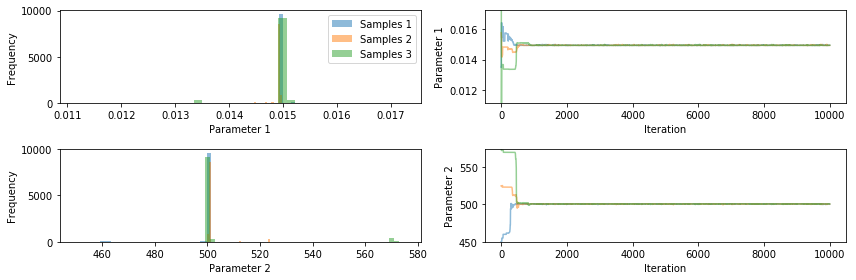

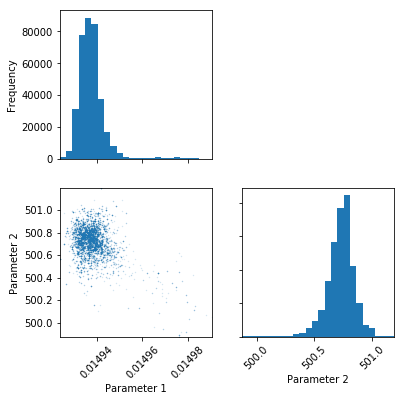

In [27]:
#chains_emu = pints.mcmc_sample(log_posterior_emu, 3, xs)
# Create mcmc routine
mcmc = pints.MCMCController(log_posterior_emu, 3, xs)

# Add stopping criterion
mcmc.set_max_iterations(10000)

# Disable logging mode
mcmc.set_log_to_screen(False)

# Run!
print('Running...')
chains_emu = mcmc.run()
print('Done!')

# Show traces and histograms
pints.plot.trace(chains_emu)

# Discard warm up
chains_emu_thin = chains_emu[:, 2000:, :]

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(chains_emu_thin))

# Look at distribution in chain 0
pints.plot.pairwise(chains_emu_thin[0])

# Show graphs
plt.show()

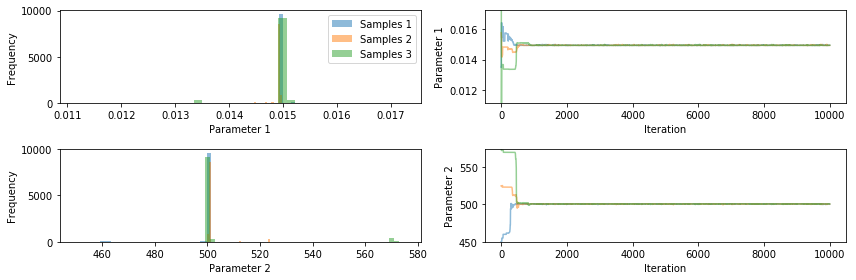

In [28]:
pints.plot.trace(chains_emu)
plt.show()

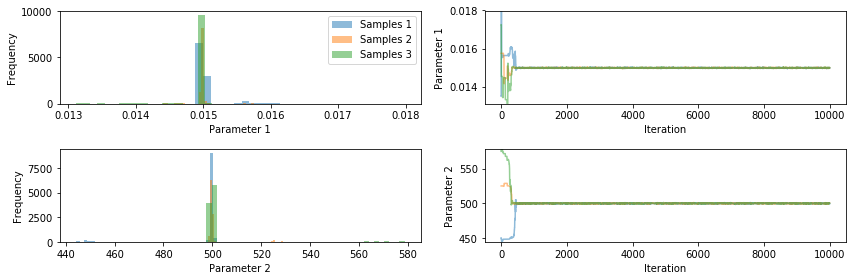

In [29]:
pints.plot.trace(chains)
plt.show()

In [30]:
chain_emu = chains_emu[0]
chain_emu = chain_emu[2000:]
chain = chains[0]
chain = chain[2000:]

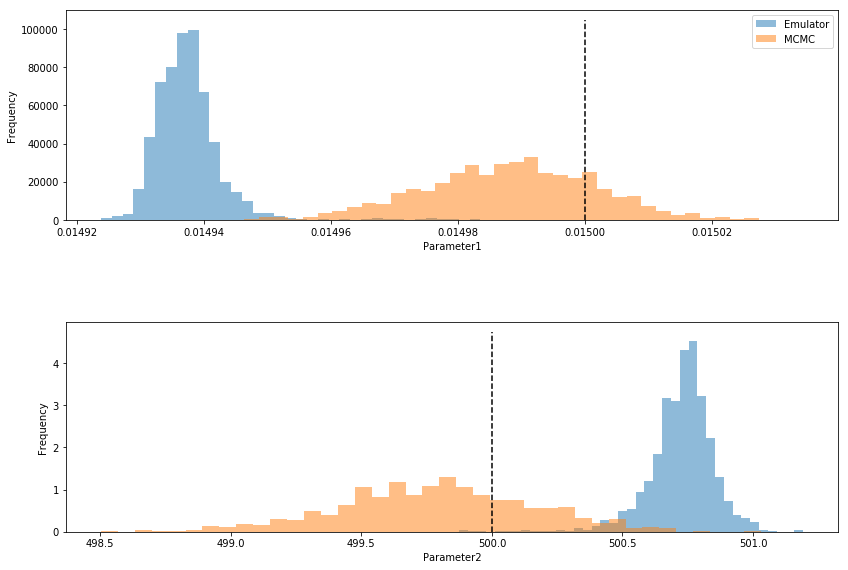

In [31]:
fig, axes = pints.plot.histogram([chain_emu, chain], ref_parameters=true_parameters, sample_names=["Emulator", "MCMC"])
fig.set_size_inches(14, 9)
plt.show()

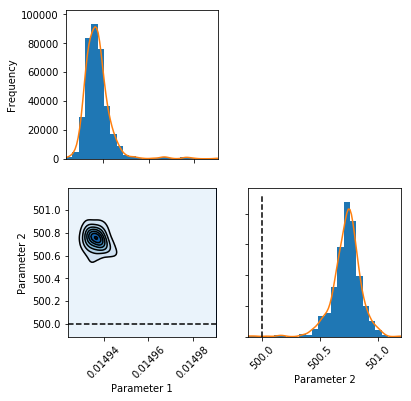

In [32]:
thinned_chain_emu = chain_emu[::10]
pints.plot.pairwise(thinned_chain_emu, kde=True, ref_parameters=true_parameters)
plt.show()

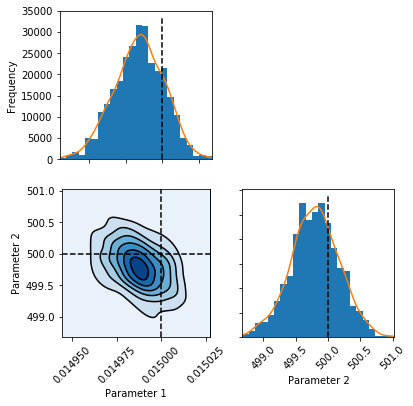

In [33]:
thinned_chain = chain[::10]
pints.plot.pairwise(thinned_chain, kde=True, ref_parameters=true_parameters)
plt.show()

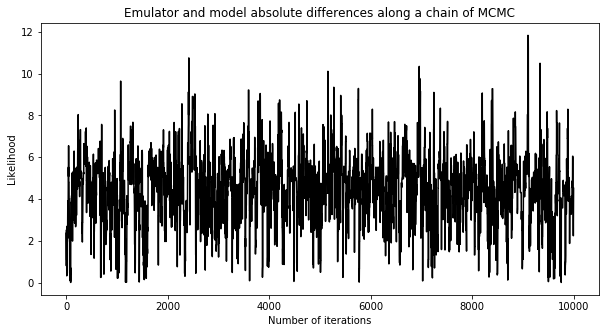

4.515713719619271

In [34]:
emu_prediction = np.apply_along_axis(emu, 1, chain_emu).flatten()
model_prediction = np.apply_along_axis(log_likelihood, 1, chain).flatten()
diffs = np.abs(model_prediction - emu_prediction)

iters = np.linspace(0, 10000, len(chain_emu))
plt.figure(figsize=(10, 5))
plt.title("Emulator and model absolute differences along a chain of MCMC")
plt.xlabel("Number of iterations")
plt.ylabel("Likelihood")
plt.plot(iters, diffs, color = "Black")
plt.show()

diffs[-1]

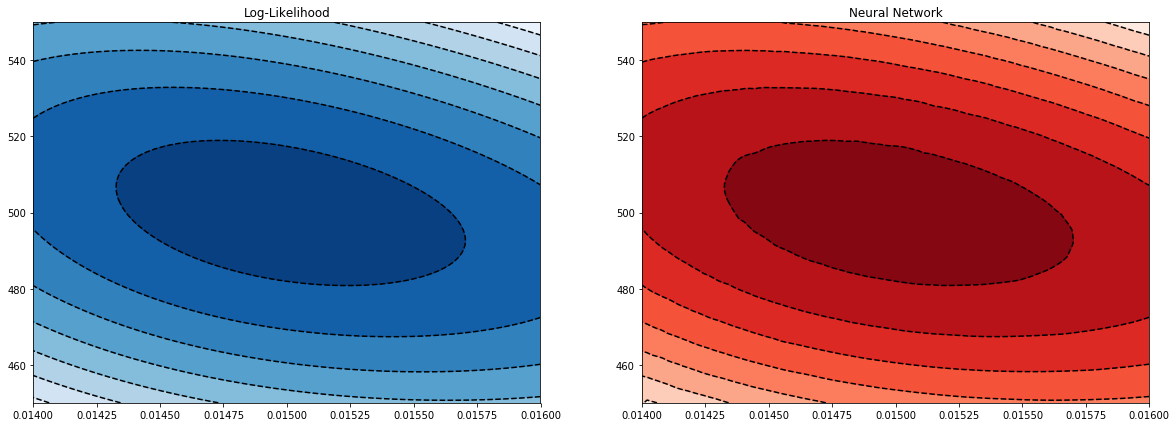

In [35]:
# Create grid
x = [p[0] for p in input_parameters]
y = [p[1] for p in input_parameters]
xmin, xmax = np.min(x), np.max(x)
ymin, ymax = np.min(y), np.max(y)
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
params = [list(n) for n in zip(xx, yy)]
ll = np.apply_along_axis(log_likelihood, 1, params)
ll_emu = np.apply_along_axis(emu, 1, params)
ll_emu = [list(e[0][0]) for e in ll_emu]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
ax1.title.set_text('Log-Likelihood')
ax2.title.set_text('Neural Network')
ax1.contourf(xx, yy, ll, cmap='Blues', extent=[xmin, xmax, ymin, ymax])
ax1.contour(xx, yy, ll, colors='k')
ax2.contourf(xx, yy, ll_emu, cmap='Reds', extent=[xmin, xmax, ymin, ymax])
ax2.contour(xx, yy, ll_emu, colors='k')
plt.show()

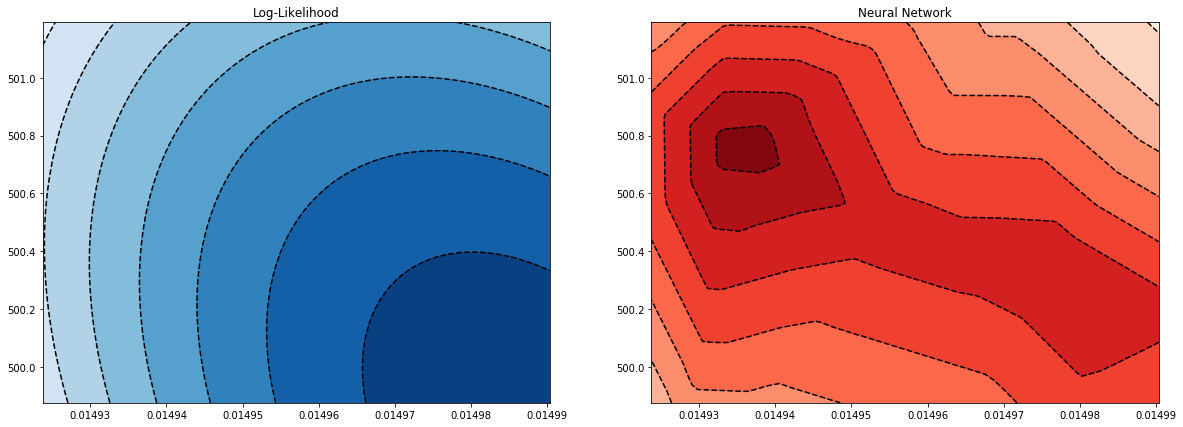

In [36]:
# Create grid
x = [p[0] for p in chain_emu]
y = [p[1] for p in chain_emu]
xmin, xmax = np.min(x), np.max(x)
ymin, ymax = np.min(y), np.max(y)
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
params = [list(n) for n in zip(xx, yy)]
ll = np.apply_along_axis(log_likelihood, 1, params)
ll_emu = np.apply_along_axis(emu, 1, params)
ll_emu = [list(e[0][0]) for e in ll_emu]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
ax1.title.set_text('Log-Likelihood')
ax2.title.set_text('Neural Network')
ax1.contourf(xx, yy, ll, cmap='Blues', extent=[xmin, xmax, ymin, ymax])
ax1.contour(xx, yy, ll, colors='k')
ax2.contourf(xx, yy, ll_emu, cmap='Reds', extent=[xmin, xmax, ymin, ymax])
ax2.contour(xx, yy, ll_emu, colors='k')
plt.show()

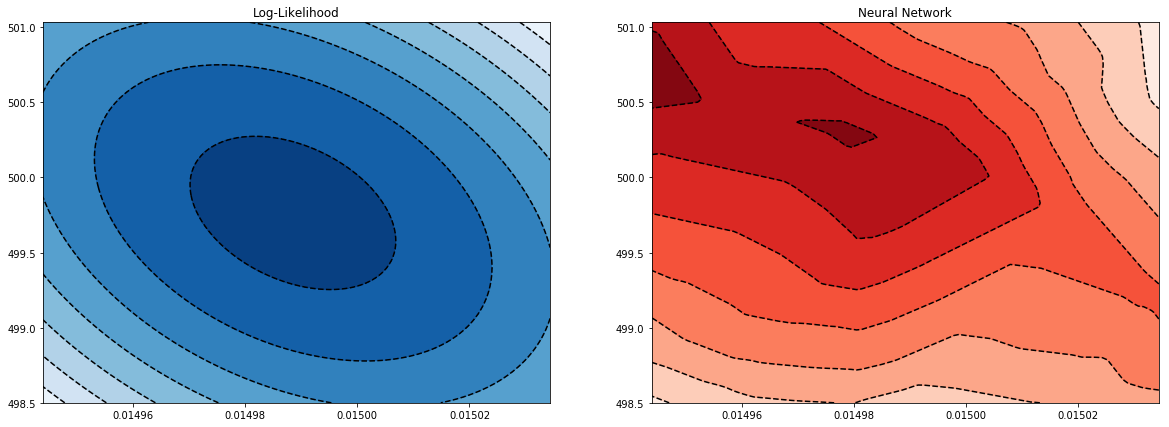

In [37]:
# Create grid
x = [p[0] for p in chain]
y = [p[1] for p in chain]
xmin, xmax = np.min(x), np.max(x)
ymin, ymax = np.min(y), np.max(y)
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
params = [list(n) for n in zip(xx, yy)]
ll = np.apply_along_axis(log_likelihood, 1, params)
ll_emu = np.apply_along_axis(emu, 1, params)
ll_emu = [list(e[0][0]) for e in ll_emu]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
ax1.title.set_text('Log-Likelihood')
ax2.title.set_text('Neural Network')
ax1.contourf(xx, yy, ll, cmap='Blues', extent=[xmin, xmax, ymin, ymax])
ax1.contour(xx, yy, ll, colors='k')
ax2.contourf(xx, yy, ll_emu, cmap='Reds', extent=[xmin, xmax, ymin, ymax])
ax2.contour(xx, yy, ll_emu, colors='k')
plt.show()

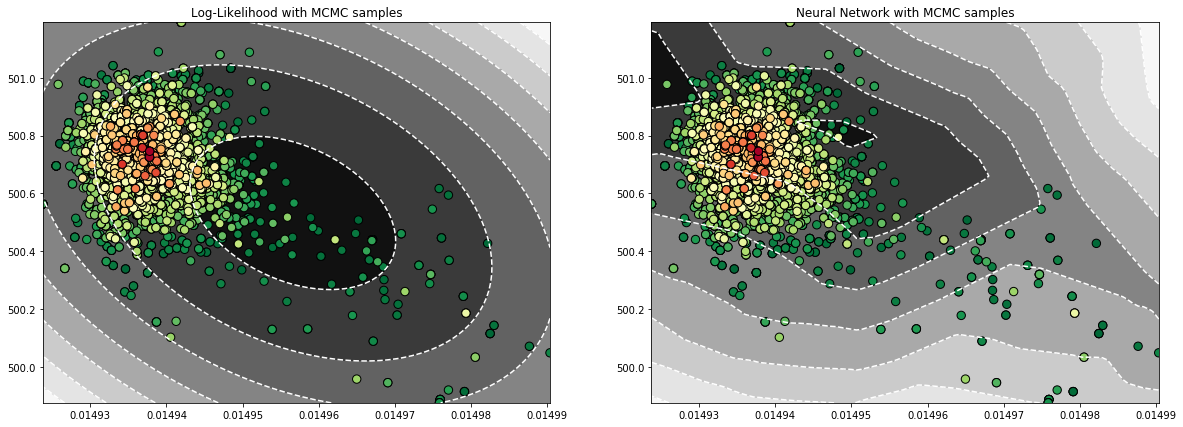

In [38]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
ax1.title.set_text('Log-Likelihood with MCMC samples')
ax2.title.set_text('Neural Network with MCMC samples')                                                                  

# Plot chain_emu
x = [p[0] for p in chain_emu]
y = [p[1] for p in chain_emu]
xmin, xmax = np.min(x), np.max(x)
ymin, ymax = np.min(y), np.max(y)
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]

# Sort according to likelihood error
idx = diffs.argsort()
x_sorted = np.array(x)[idx]
y_sorted = np.array(y)[idx]
diffs_sorted = diffs[idx]

# Add contour lines of log-likelihood
ax1.contourf(xx, yy, ll, cmap='Greys', extent=[xmin, xmax, ymin, ymax])
ax1.contour(xx, yy, ll, colors='w')

# Plot chain_emu    
ax1.set_xlim([xmin, xmax])                                                                           
ax1.set_ylim([ymin, ymax])
ax1.scatter(x_sorted, y_sorted, c=diffs_sorted, s=70, edgecolor='k', cmap="RdYlGn_r")

# Add contour lines of emulated likelihood
ax2.contourf(xx, yy, ll_emu, cmap='Greys', extent=[xmin, xmax, ymin, ymax])
ax2.contour(xx, yy, ll_emu, colors='w')

# Plot chain_emu    
ax2.set_xlim([xmin, xmax])                                                                           
ax2.set_ylim([ymin, ymax])
ax2.scatter(x_sorted, y_sorted, c=diffs_sorted, s=70, edgecolor='k', cmap="RdYlGn_r")

plt.show()

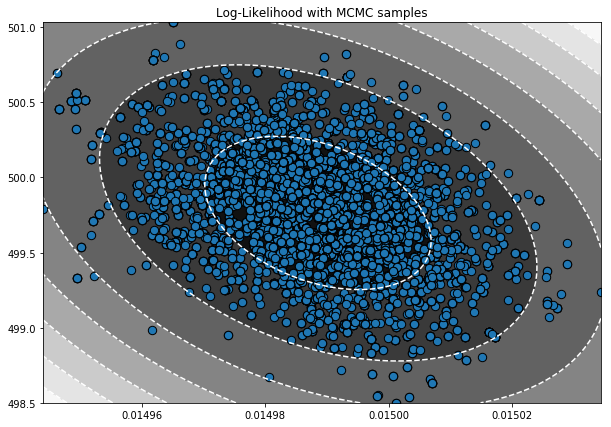

In [39]:
fig, ax = plt.subplots(figsize=(10,7))                   
ax.title.set_text('Log-Likelihood with MCMC samples')

# Show density 
#ax.imshow(np.rot90(ll), cmap=plt.cm.Blues, extent=[xmin, xmax, ymin, ymax])                                                                     

# Plot chain_emu
x = [p[0] for p in chain]
y = [p[1] for p in chain]
xmin, xmax = np.min(x), np.max(x)
ymin, ymax = np.min(y), np.max(y)
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]

idx = diffs.argsort()
x_sorted = np.array(x)[idx]
y_sorted = np.array(y)[idx]
diffs_sorted = diffs[idx]

# Add contour lines
ax.contourf(xx, yy, ll, cmap='Greys', extent=[xmin, xmax, ymin, ymax])
plt.contour(xx, yy, ll, colors='w')

# Plot chain_emu    
ax.set_xlim([xmin, xmax])                                                                           
ax.set_ylim([ymin, ymax])

ax.scatter(x, y, s=70, edgecolor='k', cmap="RdYlGn_r")
#fig.colorbar(ax)
plt.show()